For the cosserat rod equations, there are two kinematic equations (one related to translations and another related to rotations) and two dynamic equations (again, one related to translations and another related to rotations). So we tackle this problem in increasing levels of complexity via these milestones:

1) first tackle translations (which are easier to implement) by testing the equations on an elastic beam that is fixed on one end and has a small axial force on the one end. Because the beam is elastic, and the axial force is small, the entire beam behaves like a spring. We can then plot look at how much the beam stretches, which should correspond with analytical spring equations. This is milestone 1.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time

# This class is not completely general: only supports uniform mass and single radius
class cosserat_rod:
    # initialize the rod
    def __init__(self, n_elements: int = 100, tot_length = 3.0, rod_density = 5E3, 
                 rod_radius = 0.25, E = 1E6, G = 1E4, velocities = 0, internal_forces = 0):
        
        '''Set up quantities that describe the rod'''
        self.tot_length = tot_length
        self.G = G
        self.E = E
        self.n_elements = n_elements
        self.n_nodes = self.n_elements+1
        element_length = tot_length/n_elements
        
        # initially straight rod
        # self.positions = np.vstack((np.zeros((2,self.n_nodes)),np.arange(0.0, tot_length+element_length, element_length)))
        
        # initially v shaped rod at 45 degree angle
        self.positions = np.zeros((3, self.n_nodes))
        self.positions[2] = np.arange(0.0, (tot_length+element_length)*np.cos(np.pi/4), element_length*np.cos(np.pi/4))
        self.positions[0] = np.arange(0.0, (tot_length+element_length)*np.sin(np.pi/4), element_length*np.sin(np.pi/4))
        self.positions[0, int(self.n_nodes/2.0):] = -self.positions[0, int(self.n_nodes/2.0):] + tot_length*np.cos(np.pi/4)
        
        self.lengths_bold = self.positions[:, 1:] - self.positions[:, :-1]
        self.lengths_norm = np.linalg.norm(self.lengths_bold, axis=0, keepdims=True)
        self.reference_lengths_bold = self.positions[:, 1:] - self.positions[:, :-1]
        self.reference_lengths_norm = np.linalg.norm(self.reference_lengths_bold, axis=0, keepdims=True)
        
        self.directors = np.zeros((3, 3, self.n_elements))
        self.directors[2] = self.lengths_bold/self.lengths_norm
        self.directors[1] = [[0]*self.n_elements, [1]*self.n_elements, [0]*self.n_elements]
        self.directors[0] = np.transpose(np.cross(self.directors[1], self.directors[2], 0, 0))
        
        self.rod_area = np.pi*rod_radius*rod_radius
        self.areas = self.rod_area*np.ones(self.n_elements,)
        
        element_mass = rod_density*element_length*self.rod_area
        self.masses = element_mass*np.ones(self.n_nodes,)
        self.masses[0] *= 0.5
        self.masses[-1] *= 0.5
        
        '''Rotational stuff'''
        
        # moment of inertia about each director
        element_I = np.array([1/12 * element_mass * (3 * np.square(rod_radius) + np.square(element_length)), \
                     1/12 * element_mass * (3 * np.square(rod_radius) + np.square(element_length)), \
                     0.5 * element_mass * rod_radius * rod_radius])
                                        
        self.I_ref = np.zeros((3, self.n_elements))
        self.I_ref[0,:] = element_I[0]
        self.I_ref[1,:] = element_I[1]
        self.I_ref[2,:] = element_I[2]
        
        # Bend/twist matrix
        self.B_ref = np.zeros((3, 3, n_elements - 1))
        self.J_ref = np.zeros((3, 3, n_elements))
        self.inv_J_ref = np.zeros((3, 3, n_elements))
        for idx in range(n_elements - 1):
            self.B_ref[:, :, idx] = np.diag(element_I) * np.array([self.E, self.E, self.G])
            self.J_ref[:, :, idx] = np.diag(rod_density*self.reference_lengths_norm[:, idx]*self.I_ref[:, idx])
            self.inv_J_ref[:, :, idx] = np.linalg.inv(self.J_ref[:, :, idx]) # rather calculate this now
            
        # These have one more dim than B_ref, so I just do the last one here
        self.J_ref[:, :, n_elements - 1] = np.diag(rod_density*self.reference_lengths_norm[:, n_elements - 1] \
                                                   *self.I_ref[:, n_elements - 1])
        self.inv_J_ref[:, :, n_elements - 1] = np.linalg.inv(self.J_ref[:, :, n_elements - 1]) 
            
#         lengths_next = np.roll(self.lengths_bold, -1, 1)
#         self.D_ref = (lengths_next[:, :-1] + self.lengths_bold[:, :-1])/2

        lengths_next = np.roll(self.lengths_norm, -1, 1)
        self.D_ref = (lengths_next[:, :-1] + self.lengths_norm[:, :-1])/2
        
        Q_next = np.roll(self.directors, -1, 2)[:, :, :-1]
        self.kappa_ref = -self.inverse_rotate(self.directors[:, :, :-1], Q_next) / self.D_ref     
        
        '''Set up quantities that will capture motion'''
        # This way of doing it is bad and should be fixed, will throw error if you try to input your own vals
        self.velocities = velocities if velocities else np.zeros((3, self.n_nodes)) 
        self.internal_forces = internal_forces if internal_forces else np.zeros((3, self.n_nodes))
        self.ang_vels = np.zeros((3, self.n_elements))
        
        self.dilatations = self.lengths_norm / self.reference_lengths_norm
        
        self.shear_stiffness_matrix = np.zeros((3, 3, n_elements)) # S
        alpha_c = 4.0 / 3.0
        self.shear_stiffness_matrix[0, 0, :] = alpha_c * self.G * self.areas # S1
        self.shear_stiffness_matrix[1, 1, :] = alpha_c * self.G * self.areas # S2
        self.shear_stiffness_matrix[2, 2, :] = self.E * self.areas # S2
        
        self.tangents = self.lengths_bold / self.lengths_norm 
        
        self.shear_stretch_strains = self.dilatations * self.tangents - self.directors[:, 2, :]
        
        # to get sigma in material frame
        self.shear_stretch_strains = np.einsum('ijk, jk-> ik', self.directors, self.shear_stretch_strains)

    def inverse_rotate(self, t_frameone, t_frametwo):
        """ Finds the angle and axes of rotation given any two frames

        Parameters
        ----------
        t_frameone : frame/np.array
            If frame object, then t_frame is given by the process function of
            the frame
            Else just a numpy array (vector/collection of vectors) which you
            want to find the angle of
        t_frametwo : frame/np.array
            If frame object, then t_frame is given by the process function of
            the frame
            Else just a numpy array (vector/collection of vectors) which you
            want to find the angle of
        Both obey t_frametwo = R @ t_frameone
    
        Returns
        -------
        angle : float
            Returns the angle about which the frame rotates
        axis : list/float like
            Returns the axis about which the frames differ
        """
        # trying to make it work without looping through elements, so R has n_elem - 1 k dimension
        # this einsum is Q*R.T for two matrices Q and R
        R = np.einsum('ijk, ljk -> ilk', t_frametwo, t_frameone)
        
        angle = np.arccos((np.trace(R)-1.0)/2.0)
        K = (R-np.transpose(R, (1,0,2)))/(2.0*np.sin(angle))
        about = np.array([-K[1,2,:], K[0,2,:], -K[0,1,:]])        
        about = np.nan_to_num(about, 0)
        
        return about
    
    def rotate_rodrigues(self, t_frame, t_angle, about=[0.0,0.0,1.0], rad=True):
        """Rotates about one of the axes

        Parameters
        ----------
        t_frame : frame/np.array
            If frame object, then t_frame is given by the process function of
            the frame
            Else just a numpy array (vector/collection of vectors) which you
            want to rotate
        t_angle : float
            Angle of rotation, in degrees. Use `rad` to change behavior
        about : list/np.array
            Rotation axis specified in the world coordinates
        rad : bool
            Defaults to False. True indicates that the t_angle is in degrees rather
            than in radians. False indicates radians.

        Returns
        -------
        rot_frame : np.array 
            The rotated frame
        """
        # Check if its in radian or degree
        # Default assumed to be rad
        if not rad:
            t_angle = np.deg2rad(t_angle)

        def normalize(v):
            """ Normalize a vector/ matrix """
            norm = np.linalg.norm(v, None, 0) # along directions
            # norm[np.isclose(norm, 0.0)] = 10000 # kind of a hack, makes anything near 0 really tiny
            return v / (norm + 1E-14)

        def skew_symmetrize(v):
            """ Generate an orthogonal matrix from vector elements"""
            # Hard coded. Others are more verbose or not worth it
            temp = np.zeros((3, 3, self.n_elements))
            for elem in range(self.n_elements):
                temp[:, :, elem] = [[0.0,-v[2, elem],v[1, elem]], [v[2, elem],0.0,-v[0, elem]], \
                                    [-v[1, elem],v[0, elem],0.0]]
            return temp
        

        # Convert about to np.array and normalize it
        about = normalize(np.array(about))

        # Form the 2D Euler rotation matrix
        c_angle = np.cos(t_angle)
        s_angle = np.sin(t_angle)

        # DS for 3D Euler rotation matrix
        # Composed of 2D matrices
        I = np.zeros((3, 3, self.n_elements))
        for idx in range(self.n_elements):
            I[:, :, idx] = np.eye(3)
        K_mat = skew_symmetrize(about)
        # rot_matrix = I + K_mat @ (s_angle * I + (1-c_angle)* K_mat)
        rot_matrix = I + (s_angle * K_mat + (1.0 - c_angle) * np.einsum('ijk, lik-> ljk', K_mat,  K_mat))   
        # print(rot_matrix, U_mat)

        if not (np.allclose(rot_matrix, I)):
            # actually do the rotation
            return np.einsum('ijk, lik-> ljk', rot_matrix,  t_frame)
        else:
            return np.einsum('ijk, lik-> ljk', rot_matrix,  t_frame)
            #raise RuntimeError("Not rotating because rotation is identity")
            
    def deltaH_operator(self, t_x): 
        n_pad = [(0,0)] * t_x.ndim
        n_pad[t_x.ndim - 1] = (0,1)
        temp = np.pad(t_x, n_pad, 'constant', constant_values=(0,0))
        return temp - np.roll(temp, 1, t_x.ndim - 1)
    
    def Ah_operator(self, t_x):        
        n_pad = [(0,0)] * t_x.ndim
        n_pad[t_x.ndim - 1] = (0,1)
        temp = np.pad(t_x, n_pad, 'constant', constant_values=(0,0))
        return (temp + np.roll(temp, 1, t_x.ndim - 1)) / 2
    
    # should be called after Newton2 updates all the class vars at dt/2 --- currently w_n is coming back incorrectly
    def Newton2Rot(self, temp_Q):                
        Q_next = np.roll(temp_Q, -1, 2)[:, :, :-1]
        self.kappa_ref = -self.inverse_rotate(temp_Q[:,:,:-1], Q_next) / self.D_ref 
        
        self.kappa_ref = np.nan_to_num(self.kappa_ref)
        
        BK_product = np.einsum('ijk, jk -> ik', self.B_ref, self.kappa_ref) # matrix vector product, 3 x n_elem-1 output
        
        
        # 0 axis of inputs should be along directors, 1 is n_elem-1, output transposed to get dims back to 3 x n_elem-1
        KB_cross = np.transpose(np.cross(self.kappa_ref, BK_product, 0, 0)) 
        
        # bend twist internal couple, get these to be 3 x n_elem
        self.bend_twist_couple = self.deltaH_operator(BK_product) + self.Ah_operator(KB_cross*self.D_ref)
        
        # shear stretch internal couple
        # Q is 3 x 3 x n_elem, self. tangents is 3 x n_elem, output is 3 x n_elem
        Qt_product = np.einsum('ijk, jk-> ik', temp_Q, self.tangents)
        Ssigma_product = np.einsum('ijk, jk-> ik', self.shear_stiffness_matrix, self.shear_stretch_strains)
        # both 3 x n_elem
        self.shear_stretch_couple = np.transpose(np.cross(Qt_product, Ssigma_product, 0, 0))*self.reference_lengths_bold
                                                   
        dwdt = np.einsum('ijk, jk-> ik', self.inv_J_ref, (self.bend_twist_couple + self.shear_stretch_couple + self.ext_couples))
        return dwdt
    
    # F = ma type calculations - key is to use position at half time step to recalc internal forces, then a
    def Newton2(self, temp_x):        
        # update vals to use force_rule at dt/2
        self.lengths_bold = temp_x[:, 1:] - temp_x[:, :-1]
        self.lengths_norm = np.linalg.norm(self.lengths_bold, axis=0, keepdims=True)

        self.dilatations = self.lengths_norm / self.reference_lengths_norm
        self.tangents = self.lengths_bold / self.lengths_norm
        
        self.shear_stretch_strains = self.dilatations * self.tangents - self.directors[:, 2, :]
        
        # to get it in material frame
        # this einsum is matrix-vector multiplication for 3 x 3 x k and 3 x k
        self.shear_stretch_strains = np.einsum('ijk, jk-> ik', self.directors, self.shear_stretch_strains)
        
        self.internal_forces = np.einsum('jil, jkl, kl -> il ', self.directors, \
                                         self.shear_stiffness_matrix, self.shear_stretch_strains)
        
        node_forces = self.deltaH_operator(self.internal_forces)
        
        # potentially to implement damping
#         nu = 0.3
#         elem_vels = (self.velocities[:,1:] + self.velocities[:,:-1])/2
#         damping = -elem_vels*self.lengths_bold*nu
#         damping = self.modified_diff(damping)

        dvdt = (node_forces + self.ext_forces) / self.masses    
        return dvdt

    def position_verlet(self, dt, x, v, force_rule):
        temp_x = x + 0.5*dt*v
        v_n = v + dt * force_rule(temp_x)
        x_n = temp_x + 0.5 * dt * v_n
        return x_n, v_n
    
    def position_verletRot(self, dt, Q, w, force_rule):
        print(Q)
        temp_rot_axis = -0.5*dt*w
        temp_Q = self.rotate_rodrigues(Q, np.linalg.norm(temp_rot_axis), temp_rot_axis)
        w_n = w + dt * force_rule(temp_Q)
        rot_axis = w_n*0.5*dt
        Q_n = self.rotate_rodrigues(temp_Q, np.linalg.norm(rot_axis), rot_axis)
        print('new')
        print(Q_n)
        return Q_n, w_n

    # run the simulation, specifying external conditions ** for now it's just for first benchmark
    def run(self, ext_forces, ext_couples, t_total = 100, dt = 3E-4):
        self.ext_forces = ext_forces
        self.ext_couples = ext_couples
        n_iterations = int(np.ceil(t_total/dt))
        self.position_history = np.zeros((3, self.n_nodes, n_iterations))
        self.position_history[:, :, 0] = self.positions
        for time_step in range(n_iterations):
            self.positions, self.velocities = self.position_verlet(dt, self.positions, self.velocities, self.Newton2)
            self.directors, self.ang_vels = self.position_verletRot(dt, self.directors, self.ang_vels, self.Newton2Rot)
            # constrain the first element to the wall -- not needed for milestone 2
            #self.positions[:,0] = np.zeros(3,)
            #self.velocities[:,0] = np.zeros(3,)
            self.position_history[:, :, time_step] = self.positions
        return (self.positions, self.position_history)
        
        # print what disp should be
#         print()
#         print('Theoretical displacement (m): ', end = '')
#         print(ext_forces[-1,-1]*self.tot_length/(self.E*self.rod_area-ext_forces[-1,-1]))
#         print()
         

[[ 1.06066017 -1.06066017]
 [ 0.          0.        ]
 [ 1.06066017  1.06066017]]


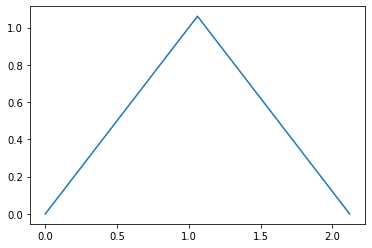

<Figure size 432x288 with 0 Axes>

In [2]:
# prove initial v shape
v_case = cosserat_rod(2)
plt.plot(v_case.positions[2], v_case.positions[0])
plt.figure()
print(v_case.lengths_bold)

[[[ 0.70710678  0.70710678]
  [ 0.         -0.        ]
  [-0.70710678  0.70710678]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70710678 -0.70710678]
  [ 0.          0.        ]
  [ 0.70710678  0.70710678]]]
new
[[[ 0.70710278  0.70710278]
  [ 0.          0.        ]
  [-0.70711078  0.70711078]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70711078 -0.70711078]
  [ 0.          0.        ]
  [ 0.70710278  0.70710278]]]
[[[ 0.70710278  0.70710278]
  [ 0.          0.        ]
  [-0.70711078  0.70711078]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70711078 -0.70711078]
  [ 0.          0.        ]
  [ 0.70710278  0.70710278]]]
new
[[[ 0.70709878  0.70709878]
  [ 0.          0.        ]
  [-0.70711478  0.70711478]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70711478 -0.70711478]
  [ 0.          0.

new
[[[ 0.70698277  0.70698277]
  [ 0.          0.        ]
  [-0.70723077  0.70723077]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70723077 -0.70723077]
  [ 0.          0.        ]
  [ 0.70698277  0.70698277]]]
[[[ 0.70698277  0.70698277]
  [ 0.          0.        ]
  [-0.70723077  0.70723077]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70723077 -0.70723077]
  [ 0.          0.        ]
  [ 0.70698277  0.70698277]]]
new
[[[ 0.70697877  0.70697877]
  [ 0.          0.        ]
  [-0.70723477  0.70723477]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70723477 -0.70723477]
  [ 0.          0.        ]
  [ 0.70697877  0.70697877]]]
[[[ 0.70697877  0.70697877]
  [ 0.          0.        ]
  [-0.70723477  0.70723477]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70723477 -0.70723477]
  [ 0.          0.

[[[ 0.70690275  0.70690275]
  [ 0.          0.        ]
  [-0.70731075  0.70731075]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70731075 -0.70731075]
  [ 0.          0.        ]
  [ 0.70690275  0.70690275]]]
new
[[[ 0.70689875  0.70689875]
  [ 0.          0.        ]
  [-0.70731475  0.70731475]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70731475 -0.70731475]
  [ 0.          0.        ]
  [ 0.70689875  0.70689875]]]
[[[ 0.70689875  0.70689875]
  [ 0.          0.        ]
  [-0.70731475  0.70731475]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70731475 -0.70731475]
  [ 0.          0.        ]
  [ 0.70689875  0.70689875]]]
new
[[[ 0.70689475  0.70689475]
  [ 0.          0.        ]
  [-0.70731875  0.70731875]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70731875 -0.70731875]
  [ 0.          0.

new
[[[ 0.70679871  0.70679871]
  [ 0.          0.        ]
  [-0.70741471  0.70741471]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70741471 -0.70741471]
  [ 0.          0.        ]
  [ 0.70679871  0.70679871]]]
[[[ 0.70679871  0.70679871]
  [ 0.          0.        ]
  [-0.70741471  0.70741471]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70741471 -0.70741471]
  [ 0.          0.        ]
  [ 0.70679871  0.70679871]]]
new
[[[ 0.70679471  0.70679471]
  [ 0.          0.        ]
  [-0.70741871  0.70741871]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70741871 -0.70741871]
  [ 0.          0.        ]
  [ 0.70679471  0.70679471]]]
[[[ 0.70679471  0.70679471]
  [ 0.          0.        ]
  [-0.70741871  0.70741871]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70741871 -0.70741871]
  [ 0.          0.

new
[[[ 0.70667465  0.70667465]
  [ 0.          0.        ]
  [-0.70753865  0.70753865]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70753865 -0.70753865]
  [ 0.          0.        ]
  [ 0.70667465  0.70667465]]]
[[[ 0.70667465  0.70667465]
  [ 0.          0.        ]
  [-0.70753865  0.70753865]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70753865 -0.70753865]
  [ 0.          0.        ]
  [ 0.70667465  0.70667465]]]
new
[[[ 0.70667065  0.70667065]
  [ 0.          0.        ]
  [-0.70754265  0.70754265]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70754265 -0.70754265]
  [ 0.          0.        ]
  [ 0.70667065  0.70667065]]]
[[[ 0.70667065  0.70667065]
  [ 0.          0.        ]
  [-0.70754265  0.70754265]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70754265 -0.70754265]
  [ 0.          0.

new
[[[ 0.70657858  0.70657858]
  [ 0.          0.        ]
  [-0.70763458  0.70763458]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70763458 -0.70763458]
  [ 0.          0.        ]
  [ 0.70657858  0.70657858]]]
[[[ 0.70657858  0.70657858]
  [ 0.          0.        ]
  [-0.70763458  0.70763458]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70763458 -0.70763458]
  [ 0.          0.        ]
  [ 0.70657858  0.70657858]]]
new
[[[ 0.70657458  0.70657458]
  [ 0.          0.        ]
  [-0.70763858  0.70763858]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70763858 -0.70763858]
  [ 0.          0.        ]
  [ 0.70657458  0.70657458]]]
[[[ 0.70657458  0.70657458]
  [ 0.          0.        ]
  [-0.70763858  0.70763858]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70763858 -0.70763858]
  [ 0.          0.

  [ 0.70643446  0.70643446]]]
[[[ 0.70643446  0.70643446]
  [ 0.          0.        ]
  [-0.70777846  0.70777846]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70777846 -0.70777846]
  [ 0.          0.        ]
  [ 0.70643446  0.70643446]]]
new
[[[ 0.70643046  0.70643046]
  [ 0.          0.        ]
  [-0.70778246  0.70778246]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70778246 -0.70778246]
  [ 0.          0.        ]
  [ 0.70643046  0.70643046]]]
[[[ 0.70643046  0.70643046]
  [ 0.          0.        ]
  [-0.70778246  0.70778246]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70778246 -0.70778246]
  [ 0.          0.        ]
  [ 0.70643046  0.70643046]]]
new
[[[ 0.70642645  0.70642645]
  [ 0.          0.        ]
  [-0.70778645  0.70778645]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70778645 -

[[[ 0.70633036  0.70633036]
  [ 0.          0.        ]
  [-0.70788236  0.70788236]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70788236 -0.70788236]
  [ 0.          0.        ]
  [ 0.70633036  0.70633036]]]
new
[[[ 0.70632635  0.70632635]
  [ 0.          0.        ]
  [-0.70788635  0.70788635]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70788635 -0.70788635]
  [ 0.          0.        ]
  [ 0.70632635  0.70632635]]]
[[[ 0.70632635  0.70632635]
  [ 0.          0.        ]
  [-0.70788635  0.70788635]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70788635 -0.70788635]
  [ 0.          0.        ]
  [ 0.70632635  0.70632635]]]
new
[[[ 0.70632235  0.70632235]
  [ 0.          0.        ]
  [-0.70789035  0.70789035]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70789035 -0.70789035]
  [ 0.          0.

new
[[[ 0.70621422  0.70621422]
  [ 0.          0.        ]
  [-0.70799822  0.70799822]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70799822 -0.70799822]
  [ 0.          0.        ]
  [ 0.70621422  0.70621422]]]
[[[ 0.70621422  0.70621422]
  [ 0.          0.        ]
  [-0.70799822  0.70799822]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70799822 -0.70799822]
  [ 0.          0.        ]
  [ 0.70621422  0.70621422]]]
new
[[[ 0.70621021  0.70621021]
  [ 0.          0.        ]
  [-0.70800221  0.70800221]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70800221 -0.70800221]
  [ 0.          0.        ]
  [ 0.70621021  0.70621021]]]
[[[ 0.70621021  0.70621021]
  [ 0.          0.        ]
  [-0.70800221  0.70800221]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70800221 -0.70800221]
  [ 0.          0.

[[[ 0.70614613  0.70614613]
  [ 0.          0.        ]
  [-0.70806613  0.70806613]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70806613 -0.70806613]
  [ 0.          0.        ]
  [ 0.70614613  0.70614613]]]
new
[[[ 0.70614212  0.70614212]
  [ 0.          0.        ]
  [-0.70807012  0.70807012]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70807012 -0.70807012]
  [ 0.          0.        ]
  [ 0.70614212  0.70614212]]]
[[[ 0.70614212  0.70614212]
  [ 0.          0.        ]
  [-0.70807012  0.70807012]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70807012 -0.70807012]
  [ 0.          0.        ]
  [ 0.70614212  0.70614212]]]
new
[[[ 0.70613812  0.70613812]
  [ 0.          0.        ]
  [-0.70807412  0.70807412]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70807412 -0.70807412]
  [ 0.          0.

new
[[[ 0.70607002  0.70607002]
  [ 0.          0.        ]
  [-0.70814202  0.70814202]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70814202 -0.70814202]
  [ 0.          0.        ]
  [ 0.70607002  0.70607002]]]
[[[ 0.70607002  0.70607002]
  [ 0.          0.        ]
  [-0.70814202  0.70814202]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70814202 -0.70814202]
  [ 0.          0.        ]
  [ 0.70607002  0.70607002]]]
new
[[[ 0.70606602  0.70606602]
  [ 0.          0.        ]
  [-0.70814602  0.70814602]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70814602 -0.70814602]
  [ 0.          0.        ]
  [ 0.70606602  0.70606602]]]
[[[ 0.70606602  0.70606602]
  [ 0.          0.        ]
  [-0.70814602  0.70814602]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70814602 -0.70814602]
  [ 0.          0.

new
[[[ 0.70599791  0.70599791]
  [ 0.          0.        ]
  [-0.70821391  0.70821391]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70821391 -0.70821391]
  [ 0.          0.        ]
  [ 0.70599791  0.70599791]]]
[[[ 0.70599791  0.70599791]
  [ 0.          0.        ]
  [-0.70821391  0.70821391]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70821391 -0.70821391]
  [ 0.          0.        ]
  [ 0.70599791  0.70599791]]]
new
[[[ 0.70599391  0.70599391]
  [ 0.          0.        ]
  [-0.70821791  0.70821791]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70821791 -0.70821791]
  [ 0.          0.        ]
  [ 0.70599391  0.70599391]]]
[[[ 0.70599391  0.70599391]
  [ 0.          0.        ]
  [-0.70821791  0.70821791]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70821791 -0.70821791]
  [ 0.          0.

[[[ 0.70585768  0.70585768]
  [ 0.          0.        ]
  [-0.70835368  0.70835368]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70835368 -0.70835368]
  [ 0.          0.        ]
  [ 0.70585768  0.70585768]]]
new
[[[ 0.70585367  0.70585367]
  [ 0.          0.        ]
  [-0.70835767  0.70835767]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70835767 -0.70835767]
  [ 0.          0.        ]
  [ 0.70585367  0.70585367]]]
[[[ 0.70585367  0.70585367]
  [ 0.          0.        ]
  [-0.70835767  0.70835767]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70835767 -0.70835767]
  [ 0.          0.        ]
  [ 0.70585367  0.70585367]]]
new
[[[ 0.70584967  0.70584967]
  [ 0.          0.        ]
  [-0.70836167  0.70836167]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70836167 -0.70836167]
  [ 0.          0.

new
[[[ 0.70577353  0.70577353]
  [ 0.          0.        ]
  [-0.70843753  0.70843753]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70843753 -0.70843753]
  [ 0.          0.        ]
  [ 0.70577353  0.70577353]]]
[[[ 0.70577353  0.70577353]
  [ 0.          0.        ]
  [-0.70843753  0.70843753]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70843753 -0.70843753]
  [ 0.          0.        ]
  [ 0.70577353  0.70577353]]]
new
[[[ 0.70576952  0.70576952]
  [ 0.          0.        ]
  [-0.70844152  0.70844152]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70844152 -0.70844152]
  [ 0.          0.        ]
  [ 0.70576952  0.70576952]]]
[[[ 0.70576952  0.70576952]
  [ 0.          0.        ]
  [-0.70844152  0.70844152]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70844152 -0.70844152]
  [ 0.          0.

new
[[[ 0.70568135  0.70568135]
  [ 0.          0.        ]
  [-0.70852935  0.70852935]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70852935 -0.70852935]
  [ 0.          0.        ]
  [ 0.70568135  0.70568135]]]
[[[ 0.70568135  0.70568135]
  [ 0.          0.        ]
  [-0.70852935  0.70852935]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70852935 -0.70852935]
  [ 0.          0.        ]
  [ 0.70568135  0.70568135]]]
new
[[[ 0.70567734  0.70567734]
  [ 0.          0.        ]
  [-0.70853334  0.70853334]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70853334 -0.70853334]
  [ 0.          0.        ]
  [ 0.70567734  0.70567734]]]
[[[ 0.70567734  0.70567734]
  [ 0.          0.        ]
  [-0.70853334  0.70853334]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70853334 -0.70853334]
  [ 0.          0.

[[[ 0.7056092  0.7056092]
  [ 0.         0.       ]
  [-0.7086012  0.7086012]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7086012 -0.7086012]
  [ 0.         0.       ]
  [ 0.7056092  0.7056092]]]
new
[[[ 0.70560519  0.70560519]
  [ 0.          0.        ]
  [-0.70860519  0.70860519]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70860519 -0.70860519]
  [ 0.          0.        ]
  [ 0.70560519  0.70560519]]]
[[[ 0.70560519  0.70560519]
  [ 0.          0.        ]
  [-0.70860519  0.70860519]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70860519 -0.70860519]
  [ 0.          0.        ]
  [ 0.70560519  0.70560519]]]
new
[[[ 0.70560118  0.70560118]
  [ 0.          0.        ]
  [-0.70860918  0.70860918]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70860918 -0.70860918]
  [ 0.          0.        ]
  [ 0.70

new
[[[ 0.70550497  0.70550497]
  [ 0.          0.        ]
  [-0.70870497  0.70870497]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70870497 -0.70870497]
  [ 0.          0.        ]
  [ 0.70550497  0.70550497]]]
[[[ 0.70550497  0.70550497]
  [ 0.          0.        ]
  [-0.70870497  0.70870497]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70870497 -0.70870497]
  [ 0.          0.        ]
  [ 0.70550497  0.70550497]]]
new
[[[ 0.70550096  0.70550096]
  [ 0.          0.        ]
  [-0.70870896  0.70870896]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70870896 -0.70870896]
  [ 0.          0.        ]
  [ 0.70550096  0.70550096]]]
[[[ 0.70550096  0.70550096]
  [ 0.          0.        ]
  [-0.70870896  0.70870896]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70870896 -0.70870896]
  [ 0.          0.

new
[[[ 0.70543682  0.70543682]
  [ 0.          0.        ]
  [-0.70877281  0.70877281]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70877281 -0.70877281]
  [ 0.          0.        ]
  [ 0.70543682  0.70543682]]]
[[[ 0.70543682  0.70543682]
  [ 0.          0.        ]
  [-0.70877281  0.70877281]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70877281 -0.70877281]
  [ 0.          0.        ]
  [ 0.70543682  0.70543682]]]
new
[[[ 0.70543281  0.70543281]
  [ 0.          0.        ]
  [-0.7087768   0.7087768 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7087768  -0.7087768 ]
  [ 0.          0.        ]
  [ 0.70543281  0.70543281]]]
[[[ 0.70543281  0.70543281]
  [ 0.          0.        ]
  [-0.7087768   0.7087768 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7087768  -0.7087768 ]
  [ 0.          0.

  [ 0.70536063  0.70536063]]]
new
[[[ 0.70535662  0.70535662]
  [ 0.          0.        ]
  [-0.70885262  0.70885262]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70885262 -0.70885262]
  [ 0.          0.        ]
  [ 0.70535662  0.70535662]]]
[[[ 0.70535662  0.70535662]
  [ 0.          0.        ]
  [-0.70885262  0.70885262]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70885262 -0.70885262]
  [ 0.          0.        ]
  [ 0.70535662  0.70535662]]]
new
[[[ 0.70535261  0.70535261]
  [ 0.          0.        ]
  [-0.70885661  0.70885661]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70885661 -0.70885661]
  [ 0.          0.        ]
  [ 0.70535261  0.70535261]]]
[[[ 0.70535261  0.70535261]
  [ 0.          0.        ]
  [-0.70885661  0.70885661]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70885661 -

new
[[[ 0.70524835  0.70524835]
  [ 0.          0.        ]
  [-0.70896034  0.70896034]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70896034 -0.70896034]
  [ 0.          0.        ]
  [ 0.70524835  0.70524835]]]
[[[ 0.70524835  0.70524835]
  [ 0.          0.        ]
  [-0.70896034  0.70896034]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70896034 -0.70896034]
  [ 0.          0.        ]
  [ 0.70524835  0.70524835]]]
new
[[[ 0.70524434  0.70524434]
  [ 0.          0.        ]
  [-0.70896433  0.70896433]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70896433 -0.70896433]
  [ 0.          0.        ]
  [ 0.70524434  0.70524434]]]
[[[ 0.70524434  0.70524434]
  [ 0.          0.        ]
  [-0.70896433  0.70896433]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70896433 -0.70896433]
  [ 0.          0.

[[[ 0.70513203  0.70513203]
  [ 0.          0.        ]
  [-0.70907603  0.70907603]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70907603 -0.70907603]
  [ 0.          0.        ]
  [ 0.70513203  0.70513203]]]
[[[ 0.70513203  0.70513203]
  [ 0.          0.        ]
  [-0.70907603  0.70907603]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70907603 -0.70907603]
  [ 0.          0.        ]
  [ 0.70513203  0.70513203]]]
new
[[[ 0.70512802  0.70512802]
  [ 0.          0.        ]
  [-0.70908002  0.70908002]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70908002 -0.70908002]
  [ 0.          0.        ]
  [ 0.70512802  0.70512802]]]
[[[ 0.70512802  0.70512802]
  [ 0.          0.        ]
  [-0.70908002  0.70908002]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70908002 -0.70908002]
  [ 0.          0.    

new
[[[ 0.70506384  0.70506384]
  [ 0.          0.        ]
  [-0.70914384  0.70914384]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70914384 -0.70914384]
  [ 0.          0.        ]
  [ 0.70506384  0.70506384]]]
[[[ 0.70506384  0.70506384]
  [ 0.          0.        ]
  [-0.70914384  0.70914384]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70914384 -0.70914384]
  [ 0.          0.        ]
  [ 0.70506384  0.70506384]]]
new
[[[ 0.70505983  0.70505983]
  [ 0.          0.        ]
  [-0.70914782  0.70914782]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70914782 -0.70914782]
  [ 0.          0.        ]
  [ 0.70505983  0.70505983]]]
[[[ 0.70505983  0.70505983]
  [ 0.          0.        ]
  [-0.70914782  0.70914782]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70914782 -0.70914782]
  [ 0.          0.

new
[[[ 0.70496756  0.70496756]
  [ 0.          0.        ]
  [-0.70923955  0.70923955]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70923955 -0.70923955]
  [ 0.          0.        ]
  [ 0.70496756  0.70496756]]]
[[[ 0.70496756  0.70496756]
  [ 0.          0.        ]
  [-0.70923955  0.70923955]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70923955 -0.70923955]
  [ 0.          0.        ]
  [ 0.70496756  0.70496756]]]
new
[[[ 0.70496355  0.70496355]
  [ 0.          0.        ]
  [-0.70924354  0.70924354]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70924354 -0.70924354]
  [ 0.          0.        ]
  [ 0.70496355  0.70496355]]]
[[[ 0.70496355  0.70496355]
  [ 0.          0.        ]
  [-0.70924354  0.70924354]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70924354 -0.70924354]
  [ 0.          0.

new
[[[ 0.70489935  0.70489935]
  [ 0.          0.        ]
  [-0.70930734  0.70930734]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70930734 -0.70930734]
  [ 0.          0.        ]
  [ 0.70489935  0.70489935]]]
[[[ 0.70489935  0.70489935]
  [ 0.          0.        ]
  [-0.70930734  0.70930734]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70930734 -0.70930734]
  [ 0.          0.        ]
  [ 0.70489935  0.70489935]]]
new
[[[ 0.70489534  0.70489534]
  [ 0.          0.        ]
  [-0.70931133  0.70931133]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70931133 -0.70931133]
  [ 0.          0.        ]
  [ 0.70489534  0.70489534]]]
[[[ 0.70489534  0.70489534]
  [ 0.          0.        ]
  [-0.70931133  0.70931133]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70931133 -0.70931133]
  [ 0.          0.

[[[ 0.70476291  0.70476291]
  [ 0.          0.        ]
  [-0.70944291  0.70944291]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70944291 -0.70944291]
  [ 0.          0.        ]
  [ 0.70476291  0.70476291]]]
new
[[[ 0.7047589   0.7047589 ]
  [ 0.          0.        ]
  [-0.70944689  0.70944689]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70944689 -0.70944689]
  [ 0.          0.        ]
  [ 0.7047589   0.7047589 ]]]
[[[ 0.7047589   0.7047589 ]
  [ 0.          0.        ]
  [-0.70944689  0.70944689]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70944689 -0.70944689]
  [ 0.          0.        ]
  [ 0.7047589   0.7047589 ]]]
new
[[[ 0.70475489  0.70475489]
  [ 0.          0.        ]
  [-0.70945088  0.70945088]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70945088 -0.70945088]
  [ 0.          0.

new
[[[ 0.70467863  0.70467863]
  [ 0.          0.        ]
  [-0.70952662  0.70952662]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70952662 -0.70952662]
  [ 0.          0.        ]
  [ 0.70467863  0.70467863]]]
[[[ 0.70467863  0.70467863]
  [ 0.          0.        ]
  [-0.70952662  0.70952662]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70952662 -0.70952662]
  [ 0.          0.        ]
  [ 0.70467863  0.70467863]]]
new
[[[ 0.70467462  0.70467462]
  [ 0.          0.        ]
  [-0.70953061  0.70953061]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70953061 -0.70953061]
  [ 0.          0.        ]
  [ 0.70467462  0.70467462]]]
[[[ 0.70467462  0.70467462]
  [ 0.          0.        ]
  [-0.70953061  0.70953061]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70953061 -0.70953061]
  [ 0.          0.

[[[ 0.70458631  0.70458631]
  [ 0.          0.        ]
  [-0.7096183   0.7096183 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7096183  -0.7096183 ]
  [ 0.          0.        ]
  [ 0.70458631  0.70458631]]]
[[[ 0.70458631  0.70458631]
  [ 0.          0.        ]
  [-0.7096183   0.7096183 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7096183  -0.7096183 ]
  [ 0.          0.        ]
  [ 0.70458631  0.70458631]]]
new
[[[ 0.7045823   0.7045823 ]
  [ 0.          0.        ]
  [-0.70962229  0.70962229]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70962229 -0.70962229]
  [ 0.          0.        ]
  [ 0.7045823   0.7045823 ]]]
[[[ 0.7045823   0.7045823 ]
  [ 0.          0.        ]
  [-0.70962229  0.70962229]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70962229 -0.70962229]
  [ 0.          0.    

new
[[[ 0.70450602  0.70450602]
  [ 0.          0.        ]
  [-0.70969801  0.70969801]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70969801 -0.70969801]
  [ 0.          0.        ]
  [ 0.70450602  0.70450602]]]
[[[ 0.70450602  0.70450602]
  [ 0.          0.        ]
  [-0.70969801  0.70969801]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70969801 -0.70969801]
  [ 0.          0.        ]
  [ 0.70450602  0.70450602]]]
new
[[[ 0.70450201  0.70450201]
  [ 0.          0.        ]
  [-0.709702    0.709702  ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.709702   -0.709702  ]
  [ 0.          0.        ]
  [ 0.70450201  0.70450201]]]
[[[ 0.70450201  0.70450201]
  [ 0.          0.        ]
  [-0.709702    0.709702  ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.709702   -0.709702  ]
  [ 0.          0.

new
[[[ 0.70441769  0.70441769]
  [ 0.          0.        ]
  [-0.70978568  0.70978568]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70978568 -0.70978568]
  [ 0.          0.        ]
  [ 0.70441769  0.70441769]]]
[[[ 0.70441769  0.70441769]
  [ 0.          0.        ]
  [-0.70978568  0.70978568]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70978568 -0.70978568]
  [ 0.          0.        ]
  [ 0.70441769  0.70441769]]]
new
[[[ 0.70441368  0.70441368]
  [ 0.          0.        ]
  [-0.70978967  0.70978967]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70978967 -0.70978967]
  [ 0.          0.        ]
  [ 0.70441368  0.70441368]]]
[[[ 0.70441368  0.70441368]
  [ 0.          0.        ]
  [-0.70978967  0.70978967]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70978967 -0.70978967]
  [ 0.          0.

new
[[[ 0.70432534  0.70432534]
  [ 0.          0.        ]
  [-0.70987732  0.70987732]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70987732 -0.70987732]
  [ 0.          0.        ]
  [ 0.70432534  0.70432534]]]
[[[ 0.70432534  0.70432534]
  [ 0.          0.        ]
  [-0.70987732  0.70987732]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70987732 -0.70987732]
  [ 0.          0.        ]
  [ 0.70432534  0.70432534]]]
new
[[[ 0.70432132  0.70432132]
  [ 0.          0.        ]
  [-0.70988131  0.70988131]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70988131 -0.70988131]
  [ 0.          0.        ]
  [ 0.70432132  0.70432132]]]
[[[ 0.70432132  0.70432132]
  [ 0.          0.        ]
  [-0.70988131  0.70988131]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70988131 -0.70988131]
  [ 0.          0.

new
[[[ 0.70424502  0.70424502]
  [ 0.          0.        ]
  [-0.70995701  0.70995701]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70995701 -0.70995701]
  [ 0.          0.        ]
  [ 0.70424502  0.70424502]]]
[[[ 0.70424502  0.70424502]
  [ 0.          0.        ]
  [-0.70995701  0.70995701]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70995701 -0.70995701]
  [ 0.          0.        ]
  [ 0.70424502  0.70424502]]]
new
[[[ 0.70424101  0.70424101]
  [ 0.          0.        ]
  [-0.70996099  0.70996099]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70996099 -0.70996099]
  [ 0.          0.        ]
  [ 0.70424101  0.70424101]]]
[[[ 0.70424101  0.70424101]
  [ 0.          0.        ]
  [-0.70996099  0.70996099]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.70996099 -0.70996099]
  [ 0.          0.

  [ 0.70418076  0.70418076]]]
[[[ 0.70418076  0.70418076]
  [ 0.          0.        ]
  [-0.71002074  0.71002074]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71002074 -0.71002074]
  [ 0.          0.        ]
  [ 0.70418076  0.70418076]]]
new
[[[ 0.70417674  0.70417674]
  [ 0.          0.        ]
  [-0.71002473  0.71002473]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71002473 -0.71002473]
  [ 0.          0.        ]
  [ 0.70417674  0.70417674]]]
[[[ 0.70417674  0.70417674]
  [ 0.          0.        ]
  [-0.71002473  0.71002473]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71002473 -0.71002473]
  [ 0.          0.        ]
  [ 0.70417674  0.70417674]]]
new
[[[ 0.70417273  0.70417273]
  [ 0.          0.        ]
  [-0.71002871  0.71002871]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71002871 -

[[[ 0.70411649  0.70411649]
  [ 0.          0.        ]
  [-0.71008448  0.71008448]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71008448 -0.71008448]
  [ 0.          0.        ]
  [ 0.70411649  0.70411649]]]
new
[[[ 0.70411248  0.70411248]
  [ 0.          0.        ]
  [-0.71008846  0.71008846]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71008846 -0.71008846]
  [ 0.          0.        ]
  [ 0.70411248  0.70411248]]]
[[[ 0.70411248  0.70411248]
  [ 0.          0.        ]
  [-0.71008846  0.71008846]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71008846 -0.71008846]
  [ 0.          0.        ]
  [ 0.70411248  0.70411248]]]
new
[[[ 0.70410846  0.70410846]
  [ 0.          0.        ]
  [-0.71009244  0.71009244]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71009244 -0.71009244]
  [ 0.          0.

[[[ 0.70403615  0.70403615]
  [ 0.          0.        ]
  [-0.71016413  0.71016413]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71016413 -0.71016413]
  [ 0.          0.        ]
  [ 0.70403615  0.70403615]]]
new
[[[ 0.70403214  0.70403214]
  [ 0.          0.        ]
  [-0.71016812  0.71016812]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71016812 -0.71016812]
  [ 0.          0.        ]
  [ 0.70403214  0.70403214]]]
[[[ 0.70403214  0.70403214]
  [ 0.          0.        ]
  [-0.71016812  0.71016812]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71016812 -0.71016812]
  [ 0.          0.        ]
  [ 0.70403214  0.70403214]]]
new
[[[ 0.70402812  0.70402812]
  [ 0.          0.        ]
  [-0.7101721   0.7101721 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7101721  -0.7101721 ]
  [ 0.          0.

[[[ 0.70395178  0.70395178]
  [ 0.          0.        ]
  [-0.71024776  0.71024776]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71024776 -0.71024776]
  [ 0.          0.        ]
  [ 0.70395178  0.70395178]]]
[[[ 0.70395178  0.70395178]
  [ 0.          0.        ]
  [-0.71024776  0.71024776]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71024776 -0.71024776]
  [ 0.          0.        ]
  [ 0.70395178  0.70395178]]]
new
[[[ 0.70394777  0.70394777]
  [ 0.          0.        ]
  [-0.71025175  0.71025175]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71025175 -0.71025175]
  [ 0.          0.        ]
  [ 0.70394777  0.70394777]]]
[[[ 0.70394777  0.70394777]
  [ 0.          0.        ]
  [-0.71025175  0.71025175]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71025175 -0.71025175]
  [ 0.          0.    

[[[ 0.70387142  0.70387142]
  [ 0.          0.        ]
  [-0.7103274   0.7103274 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7103274  -0.7103274 ]
  [ 0.          0.        ]
  [ 0.70387142  0.70387142]]]
[[[ 0.70387142  0.70387142]
  [ 0.          0.        ]
  [-0.7103274   0.7103274 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7103274  -0.7103274 ]
  [ 0.          0.        ]
  [ 0.70387142  0.70387142]]]
new
[[[ 0.70386741  0.70386741]
  [ 0.          0.        ]
  [-0.71033138  0.71033138]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71033138 -0.71033138]
  [ 0.          0.        ]
  [ 0.70386741  0.70386741]]]
[[[ 0.70386741  0.70386741]
  [ 0.          0.        ]
  [-0.71033138  0.71033138]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71033138 -0.71033138]
  [ 0.          0.    

[[[ 0.70378704  0.70378704]
  [ 0.          0.        ]
  [-0.71041101  0.71041101]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71041101 -0.71041101]
  [ 0.          0.        ]
  [ 0.70378704  0.70378704]]]
new
[[[ 0.70378302  0.70378302]
  [ 0.          0.        ]
  [-0.71041499  0.71041499]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71041499 -0.71041499]
  [ 0.          0.        ]
  [ 0.70378302  0.70378302]]]
[[[ 0.70378302  0.70378302]
  [ 0.          0.        ]
  [-0.71041499  0.71041499]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71041499 -0.71041499]
  [ 0.          0.        ]
  [ 0.70378302  0.70378302]]]
new
[[[ 0.703779    0.703779  ]
  [ 0.          0.        ]
  [-0.71041897  0.71041897]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71041897 -0.71041897]
  [ 0.          0.

[[[ 0.70369058  0.70369058]
  [ 0.          0.        ]
  [-0.71050656  0.71050656]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71050656 -0.71050656]
  [ 0.          0.        ]
  [ 0.70369058  0.70369058]]]
new
[[[ 0.70368656  0.70368656]
  [ 0.          0.        ]
  [-0.71051054  0.71051054]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71051054 -0.71051054]
  [ 0.          0.        ]
  [ 0.70368656  0.70368656]]]
[[[ 0.70368656  0.70368656]
  [ 0.          0.        ]
  [-0.71051054  0.71051054]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71051054 -0.71051054]
  [ 0.          0.        ]
  [ 0.70368656  0.70368656]]]
new
[[[ 0.70368254  0.70368254]
  [ 0.          0.        ]
  [-0.71051452  0.71051452]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71051452 -0.71051452]
  [ 0.          0.

[[[ 0.70360215  0.70360215]
  [ 0.          0.        ]
  [-0.71059412  0.71059412]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71059412 -0.71059412]
  [ 0.          0.        ]
  [ 0.70360215  0.70360215]]]
new
[[[ 0.70359813  0.70359813]
  [ 0.          0.        ]
  [-0.7105981   0.7105981 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7105981  -0.7105981 ]
  [ 0.          0.        ]
  [ 0.70359813  0.70359813]]]
[[[ 0.70359813  0.70359813]
  [ 0.          0.        ]
  [-0.7105981   0.7105981 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7105981  -0.7105981 ]
  [ 0.          0.        ]
  [ 0.70359813  0.70359813]]]
new
[[[ 0.70359411  0.70359411]
  [ 0.          0.        ]
  [-0.71060208  0.71060208]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71060208 -0.71060208]
  [ 0.          0.

new
[[[ 0.70350969  0.70350969]
  [ 0.          0.        ]
  [-0.71068566  0.71068566]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71068566 -0.71068566]
  [ 0.          0.        ]
  [ 0.70350969  0.70350969]]]
[[[ 0.70350969  0.70350969]
  [ 0.          0.        ]
  [-0.71068566  0.71068566]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71068566 -0.71068566]
  [ 0.          0.        ]
  [ 0.70350969  0.70350969]]]
new
[[[ 0.70350567  0.70350567]
  [ 0.          0.        ]
  [-0.71068964  0.71068964]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71068964 -0.71068964]
  [ 0.          0.        ]
  [ 0.70350567  0.70350567]]]
[[[ 0.70350567  0.70350567]
  [ 0.          0.        ]
  [-0.71068964  0.71068964]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71068964 -0.71068964]
  [ 0.          0.

[[[ 0.70344135  0.70344135]
  [ 0.          0.        ]
  [-0.71075331  0.71075331]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71075331 -0.71075331]
  [ 0.          0.        ]
  [ 0.70344135  0.70344135]]]
new
[[[ 0.70343733  0.70343733]
  [ 0.          0.        ]
  [-0.71075729  0.71075729]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71075729 -0.71075729]
  [ 0.          0.        ]
  [ 0.70343733  0.70343733]]]
[[[ 0.70343733  0.70343733]
  [ 0.          0.        ]
  [-0.71075729  0.71075729]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71075729 -0.71075729]
  [ 0.          0.        ]
  [ 0.70343733  0.70343733]]]
new
[[[ 0.7034333   0.7034333 ]
  [ 0.          0.        ]
  [-0.71076127  0.71076127]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71076127 -0.71076127]
  [ 0.          0.

[[[ 0.70335289  0.70335289]
  [ 0.          0.        ]
  [-0.71084085  0.71084085]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71084085 -0.71084085]
  [ 0.          0.        ]
  [ 0.70335289  0.70335289]]]
new
[[[ 0.70334887  0.70334887]
  [ 0.          0.        ]
  [-0.71084483  0.71084483]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71084483 -0.71084483]
  [ 0.          0.        ]
  [ 0.70334887  0.70334887]]]
[[[ 0.70334887  0.70334887]
  [ 0.          0.        ]
  [-0.71084483  0.71084483]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71084483 -0.71084483]
  [ 0.          0.        ]
  [ 0.70334887  0.70334887]]]
new
[[[ 0.70334484  0.70334484]
  [ 0.          0.        ]
  [-0.71084881  0.71084881]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71084881 -0.71084881]
  [ 0.          0.

new
[[[ 0.70327648  0.70327648]
  [ 0.          0.        ]
  [-0.71091644  0.71091644]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71091644 -0.71091644]
  [ 0.          0.        ]
  [ 0.70327648  0.70327648]]]
[[[ 0.70327648  0.70327648]
  [ 0.          0.        ]
  [-0.71091644  0.71091644]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71091644 -0.71091644]
  [ 0.          0.        ]
  [ 0.70327648  0.70327648]]]
new
[[[ 0.70327246  0.70327246]
  [ 0.          0.        ]
  [-0.71092042  0.71092042]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71092042 -0.71092042]
  [ 0.          0.        ]
  [ 0.70327246  0.70327246]]]
[[[ 0.70327246  0.70327246]
  [ 0.          0.        ]
  [-0.71092042  0.71092042]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71092042 -0.71092042]
  [ 0.          0.

new
[[[ 0.70320409  0.70320409]
  [ 0.          0.        ]
  [-0.71098805  0.71098805]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71098805 -0.71098805]
  [ 0.          0.        ]
  [ 0.70320409  0.70320409]]]
[[[ 0.70320409  0.70320409]
  [ 0.          0.        ]
  [-0.71098805  0.71098805]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71098805 -0.71098805]
  [ 0.          0.        ]
  [ 0.70320409  0.70320409]]]
new
[[[ 0.70320007  0.70320007]
  [ 0.          0.        ]
  [-0.71099203  0.71099203]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71099203 -0.71099203]
  [ 0.          0.        ]
  [ 0.70320007  0.70320007]]]
[[[ 0.70320007  0.70320007]
  [ 0.          0.        ]
  [-0.71099203  0.71099203]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71099203 -0.71099203]
  [ 0.          0.

new
[[[ 0.70308744  0.70308744]
  [ 0.          0.        ]
  [-0.7111034   0.7111034 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7111034  -0.7111034 ]
  [ 0.          0.        ]
  [ 0.70308744  0.70308744]]]
[[[ 0.70308744  0.70308744]
  [ 0.          0.        ]
  [-0.7111034   0.7111034 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7111034  -0.7111034 ]
  [ 0.          0.        ]
  [ 0.70308744  0.70308744]]]
new
[[[ 0.70308342  0.70308342]
  [ 0.          0.        ]
  [-0.71110738  0.71110738]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71110738 -0.71110738]
  [ 0.          0.        ]
  [ 0.70308342  0.70308342]]]
[[[ 0.70308342  0.70308342]
  [ 0.          0.        ]
  [-0.71110738  0.71110738]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71110738 -0.71110738]
  [ 0.          0.

[[[ 0.70293054  0.70293054]
  [ 0.          0.        ]
  [-0.7112585   0.7112585 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7112585  -0.7112585 ]
  [ 0.          0.        ]
  [ 0.70293054  0.70293054]]]
new
[[[ 0.70292652  0.70292652]
  [ 0.          0.        ]
  [-0.71126247  0.71126247]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71126247 -0.71126247]
  [ 0.          0.        ]
  [ 0.70292652  0.70292652]]]
[[[ 0.70292652  0.70292652]
  [ 0.          0.        ]
  [-0.71126247  0.71126247]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71126247 -0.71126247]
  [ 0.          0.        ]
  [ 0.70292652  0.70292652]]]
new
[[[ 0.7029225   0.7029225 ]
  [ 0.          0.        ]
  [-0.71126645  0.71126645]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71126645 -0.71126645]
  [ 0.          0.

new
[[[ 0.70283397  0.70283397]
  [ 0.          0.        ]
  [-0.71135392  0.71135392]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71135392 -0.71135392]
  [ 0.          0.        ]
  [ 0.70283397  0.70283397]]]
[[[ 0.70283397  0.70283397]
  [ 0.          0.        ]
  [-0.71135392  0.71135392]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71135392 -0.71135392]
  [ 0.          0.        ]
  [ 0.70283397  0.70283397]]]
new
[[[ 0.70282995  0.70282995]
  [ 0.          0.        ]
  [-0.7113579   0.7113579 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7113579  -0.7113579 ]
  [ 0.          0.        ]
  [ 0.70282995  0.70282995]]]
[[[ 0.70282995  0.70282995]
  [ 0.          0.        ]
  [-0.7113579   0.7113579 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7113579  -0.7113579 ]
  [ 0.          0.

new
[[[ 0.70274544  0.70274544]
  [ 0.          0.        ]
  [-0.71144139  0.71144139]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71144139 -0.71144139]
  [ 0.          0.        ]
  [ 0.70274544  0.70274544]]]
[[[ 0.70274544  0.70274544]
  [ 0.          0.        ]
  [-0.71144139  0.71144139]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71144139 -0.71144139]
  [ 0.          0.        ]
  [ 0.70274544  0.70274544]]]
new
[[[ 0.70274142  0.70274142]
  [ 0.          0.        ]
  [-0.71144536  0.71144536]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71144536 -0.71144536]
  [ 0.          0.        ]
  [ 0.70274142  0.70274142]]]
[[[ 0.70274142  0.70274142]
  [ 0.          0.        ]
  [-0.71144536  0.71144536]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71144536 -0.71144536]
  [ 0.          0.

new
[[[ 0.7026569   0.7026569 ]
  [ 0.          0.        ]
  [-0.71152884  0.71152884]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71152884 -0.71152884]
  [ 0.          0.        ]
  [ 0.7026569   0.7026569 ]]]
[[[ 0.7026569   0.7026569 ]
  [ 0.          0.        ]
  [-0.71152884  0.71152884]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71152884 -0.71152884]
  [ 0.          0.        ]
  [ 0.7026569   0.7026569 ]]]
new
[[[ 0.70265287  0.70265287]
  [ 0.          0.        ]
  [-0.71153281  0.71153281]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71153281 -0.71153281]
  [ 0.          0.        ]
  [ 0.70265287  0.70265287]]]
[[[ 0.70265287  0.70265287]
  [ 0.          0.        ]
  [-0.71153281  0.71153281]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71153281 -0.71153281]
  [ 0.          0.

  [ 0.70255224  0.70255224]]]
[[[ 0.70255224  0.70255224]
  [ 0.          0.        ]
  [-0.71163218  0.71163218]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71163218 -0.71163218]
  [ 0.          0.        ]
  [ 0.70255224  0.70255224]]]
new
[[[ 0.70254821  0.70254821]
  [ 0.          0.        ]
  [-0.71163615  0.71163615]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71163615 -0.71163615]
  [ 0.          0.        ]
  [ 0.70254821  0.70254821]]]
[[[ 0.70254821  0.70254821]
  [ 0.          0.        ]
  [-0.71163615  0.71163615]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71163615 -0.71163615]
  [ 0.          0.        ]
  [ 0.70254821  0.70254821]]]
new
[[[ 0.70254419  0.70254419]
  [ 0.          0.        ]
  [-0.71164012  0.71164012]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71164012 -

[[[ 0.70245964  0.70245964]
  [ 0.          0.        ]
  [-0.71172358  0.71172358]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71172358 -0.71172358]
  [ 0.          0.        ]
  [ 0.70245964  0.70245964]]]
[[[ 0.70245964  0.70245964]
  [ 0.          0.        ]
  [-0.71172358  0.71172358]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71172358 -0.71172358]
  [ 0.          0.        ]
  [ 0.70245964  0.70245964]]]
new
[[[ 0.70245562  0.70245562]
  [ 0.          0.        ]
  [-0.71172755  0.71172755]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71172755 -0.71172755]
  [ 0.          0.        ]
  [ 0.70245562  0.70245562]]]
[[[ 0.70245562  0.70245562]
  [ 0.          0.        ]
  [-0.71172755  0.71172755]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71172755 -0.71172755]
  [ 0.          0.    

new
[[[ 0.70236301  0.70236301]
  [ 0.          0.        ]
  [-0.71181894  0.71181894]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71181894 -0.71181894]
  [ 0.          0.        ]
  [ 0.70236301  0.70236301]]]
[[[ 0.70236301  0.70236301]
  [ 0.          0.        ]
  [-0.71181894  0.71181894]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71181894 -0.71181894]
  [ 0.          0.        ]
  [ 0.70236301  0.70236301]]]
new
[[[ 0.70235898  0.70235898]
  [ 0.          0.        ]
  [-0.71182291  0.71182291]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71182291 -0.71182291]
  [ 0.          0.        ]
  [ 0.70235898  0.70235898]]]
[[[ 0.70235898  0.70235898]
  [ 0.          0.        ]
  [-0.71182291  0.71182291]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71182291 -0.71182291]
  [ 0.          0.

new
[[[ 0.70227039  0.70227039]
  [ 0.          0.        ]
  [-0.71191032  0.71191032]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71191032 -0.71191032]
  [ 0.          0.        ]
  [ 0.70227039  0.70227039]]]
[[[ 0.70227039  0.70227039]
  [ 0.          0.        ]
  [-0.71191032  0.71191032]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71191032 -0.71191032]
  [ 0.          0.        ]
  [ 0.70227039  0.70227039]]]
new
[[[ 0.70226636  0.70226636]
  [ 0.          0.        ]
  [-0.71191429  0.71191429]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71191429 -0.71191429]
  [ 0.          0.        ]
  [ 0.70226636  0.70226636]]]
[[[ 0.70226636  0.70226636]
  [ 0.          0.        ]
  [-0.71191429  0.71191429]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71191429 -0.71191429]
  [ 0.          0.

new
[[[ 0.70215762  0.70215762]
  [ 0.          0.        ]
  [-0.71202154  0.71202154]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71202154 -0.71202154]
  [ 0.          0.        ]
  [ 0.70215762  0.70215762]]]
[[[ 0.70215762  0.70215762]
  [ 0.          0.        ]
  [-0.71202154  0.71202154]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71202154 -0.71202154]
  [ 0.          0.        ]
  [ 0.70215762  0.70215762]]]
new
[[[ 0.70215359  0.70215359]
  [ 0.          0.        ]
  [-0.71202551  0.71202551]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71202551 -0.71202551]
  [ 0.          0.        ]
  [ 0.70215359  0.70215359]]]
[[[ 0.70215359  0.70215359]
  [ 0.          0.        ]
  [-0.71202551  0.71202551]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71202551 -0.71202551]
  [ 0.          0.

  [ 0.70206095  0.70206095]]]
new
[[[ 0.70205692  0.70205692]
  [ 0.          0.        ]
  [-0.71212083  0.71212083]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71212083 -0.71212083]
  [ 0.          0.        ]
  [ 0.70205692  0.70205692]]]
[[[ 0.70205692  0.70205692]
  [ 0.          0.        ]
  [-0.71212083  0.71212083]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71212083 -0.71212083]
  [ 0.          0.        ]
  [ 0.70205692  0.70205692]]]
new
[[[ 0.70205289  0.70205289]
  [ 0.          0.        ]
  [-0.71212481  0.71212481]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71212481 -0.71212481]
  [ 0.          0.        ]
  [ 0.70205289  0.70205289]]]
[[[ 0.70205289  0.70205289]
  [ 0.          0.        ]
  [-0.71212481  0.71212481]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71212481 -

  [ 0.70195217  0.70195217]]]
new
[[[ 0.70194815  0.70194815]
  [ 0.          0.        ]
  [-0.71222805  0.71222805]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71222805 -0.71222805]
  [ 0.          0.        ]
  [ 0.70194815  0.70194815]]]
[[[ 0.70194815  0.70194815]
  [ 0.          0.        ]
  [-0.71222805  0.71222805]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71222805 -0.71222805]
  [ 0.          0.        ]
  [ 0.70194815  0.70194815]]]
new
[[[ 0.70194412  0.70194412]
  [ 0.          0.        ]
  [-0.71223203  0.71223203]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71223203 -0.71223203]
  [ 0.          0.        ]
  [ 0.70194412  0.70194412]]]
[[[ 0.70194412  0.70194412]
  [ 0.          0.        ]
  [-0.71223203  0.71223203]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71223203 -

new
[[[ 0.7018595   0.7018595 ]
  [ 0.          0.        ]
  [-0.71231541  0.71231541]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71231541 -0.71231541]
  [ 0.          0.        ]
  [ 0.7018595   0.7018595 ]]]
[[[ 0.7018595   0.7018595 ]
  [ 0.          0.        ]
  [-0.71231541  0.71231541]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71231541 -0.71231541]
  [ 0.          0.        ]
  [ 0.7018595   0.7018595 ]]]
new
[[[ 0.70185547  0.70185547]
  [ 0.          0.        ]
  [-0.71231938  0.71231938]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71231938 -0.71231938]
  [ 0.          0.        ]
  [ 0.70185547  0.70185547]]]
[[[ 0.70185547  0.70185547]
  [ 0.          0.        ]
  [-0.71231938  0.71231938]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71231938 -0.71231938]
  [ 0.          0.

[[[ 0.70176279  0.70176279]
  [ 0.          0.        ]
  [-0.71241069  0.71241069]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71241069 -0.71241069]
  [ 0.          0.        ]
  [ 0.70176279  0.70176279]]]
[[[ 0.70176279  0.70176279]
  [ 0.          0.        ]
  [-0.71241069  0.71241069]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71241069 -0.71241069]
  [ 0.          0.        ]
  [ 0.70176279  0.70176279]]]
new
[[[ 0.70175876  0.70175876]
  [ 0.          0.        ]
  [-0.71241466  0.71241466]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71241466 -0.71241466]
  [ 0.          0.        ]
  [ 0.70175876  0.70175876]]]
[[[ 0.70175876  0.70175876]
  [ 0.          0.        ]
  [-0.71241466  0.71241466]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71241466 -0.71241466]
  [ 0.          0.    

new
[[[ 0.70162979  0.70162979]
  [ 0.          0.        ]
  [-0.71254168  0.71254168]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71254168 -0.71254168]
  [ 0.          0.        ]
  [ 0.70162979  0.70162979]]]
[[[ 0.70162979  0.70162979]
  [ 0.          0.        ]
  [-0.71254168  0.71254168]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71254168 -0.71254168]
  [ 0.          0.        ]
  [ 0.70162979  0.70162979]]]
new
[[[ 0.70162576  0.70162576]
  [ 0.          0.        ]
  [-0.71254565  0.71254565]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71254565 -0.71254565]
  [ 0.          0.        ]
  [ 0.70162576  0.70162576]]]
[[[ 0.70162576  0.70162576]
  [ 0.          0.        ]
  [-0.71254565  0.71254565]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71254565 -0.71254565]
  [ 0.          0.

new
[[[ 0.70152498  0.70152498]
  [ 0.          0.        ]
  [-0.71264486  0.71264486]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71264486 -0.71264486]
  [ 0.          0.        ]
  [ 0.70152498  0.70152498]]]
[[[ 0.70152498  0.70152498]
  [ 0.          0.        ]
  [-0.71264486  0.71264486]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71264486 -0.71264486]
  [ 0.          0.        ]
  [ 0.70152498  0.70152498]]]
new
[[[ 0.70152095  0.70152095]
  [ 0.          0.        ]
  [-0.71264883  0.71264883]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71264883 -0.71264883]
  [ 0.          0.        ]
  [ 0.70152095  0.70152095]]]
[[[ 0.70152095  0.70152095]
  [ 0.          0.        ]
  [-0.71264883  0.71264883]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71264883 -0.71264883]
  [ 0.          0.

new
[[[ 0.70143628  0.70143628]
  [ 0.          0.        ]
  [-0.71273216  0.71273216]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71273216 -0.71273216]
  [ 0.          0.        ]
  [ 0.70143628  0.70143628]]]
[[[ 0.70143628  0.70143628]
  [ 0.          0.        ]
  [-0.71273216  0.71273216]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71273216 -0.71273216]
  [ 0.          0.        ]
  [ 0.70143628  0.70143628]]]
new
[[[ 0.70143225  0.70143225]
  [ 0.          0.        ]
  [-0.71273613  0.71273613]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71273613 -0.71273613]
  [ 0.          0.        ]
  [ 0.70143225  0.70143225]]]
[[[ 0.70143225  0.70143225]
  [ 0.          0.        ]
  [-0.71273613  0.71273613]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71273613 -0.71273613]
  [ 0.          0.

new
[[[ 0.70134758  0.70134758]
  [ 0.          0.        ]
  [-0.71281945  0.71281945]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71281945 -0.71281945]
  [ 0.          0.        ]
  [ 0.70134758  0.70134758]]]
[[[ 0.70134758  0.70134758]
  [ 0.          0.        ]
  [-0.71281945  0.71281945]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71281945 -0.71281945]
  [ 0.          0.        ]
  [ 0.70134758  0.70134758]]]
new
[[[ 0.70134355  0.70134355]
  [ 0.          0.        ]
  [-0.71282342  0.71282342]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71282342 -0.71282342]
  [ 0.          0.        ]
  [ 0.70134355  0.70134355]]]
[[[ 0.70134355  0.70134355]
  [ 0.          0.        ]
  [-0.71282342  0.71282342]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71282342 -0.71282342]
  [ 0.          0.

new
[[[ 0.70128306  0.70128306]
  [ 0.          0.        ]
  [-0.71288293  0.71288293]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71288293 -0.71288293]
  [ 0.          0.        ]
  [ 0.70128306  0.70128306]]]
[[[ 0.70128306  0.70128306]
  [ 0.          0.        ]
  [-0.71288293  0.71288293]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71288293 -0.71288293]
  [ 0.          0.        ]
  [ 0.70128306  0.70128306]]]
new
[[[ 0.70127903  0.70127903]
  [ 0.          0.        ]
  [-0.7128869   0.7128869 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7128869  -0.7128869 ]
  [ 0.          0.        ]
  [ 0.70127903  0.70127903]]]
[[[ 0.70127903  0.70127903]
  [ 0.          0.        ]
  [-0.7128869   0.7128869 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7128869  -0.7128869 ]
  [ 0.          0.

  [ 0.70119837  0.70119837]]]
[[[ 0.70119837  0.70119837]
  [ 0.          0.        ]
  [-0.71296623  0.71296623]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71296623 -0.71296623]
  [ 0.          0.        ]
  [ 0.70119837  0.70119837]]]
new
[[[ 0.70119434  0.70119434]
  [ 0.          0.        ]
  [-0.7129702   0.7129702 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7129702  -0.7129702 ]
  [ 0.          0.        ]
  [ 0.70119434  0.70119434]]]
[[[ 0.70119434  0.70119434]
  [ 0.          0.        ]
  [-0.7129702   0.7129702 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7129702  -0.7129702 ]
  [ 0.          0.        ]
  [ 0.70119434  0.70119434]]]
new
[[[ 0.7011903   0.7011903 ]
  [ 0.          0.        ]
  [-0.71297417  0.71297417]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71297417 -

new
[[[ 0.70111367  0.70111367]
  [ 0.          0.        ]
  [-0.71304953  0.71304953]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71304953 -0.71304953]
  [ 0.          0.        ]
  [ 0.70111367  0.70111367]]]
[[[ 0.70111367  0.70111367]
  [ 0.          0.        ]
  [-0.71304953  0.71304953]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71304953 -0.71304953]
  [ 0.          0.        ]
  [ 0.70111367  0.70111367]]]
new
[[[ 0.70110963  0.70110963]
  [ 0.          0.        ]
  [-0.71305349  0.71305349]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71305349 -0.71305349]
  [ 0.          0.        ]
  [ 0.70110963  0.70110963]]]
[[[ 0.70110963  0.70110963]
  [ 0.          0.        ]
  [-0.71305349  0.71305349]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71305349 -0.71305349]
  [ 0.          0.

  [ 0.70105316  0.70105316]]]
new
[[[ 0.70104913  0.70104913]
  [ 0.          0.        ]
  [-0.71311298  0.71311298]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71311298 -0.71311298]
  [ 0.          0.        ]
  [ 0.70104913  0.70104913]]]
[[[ 0.70104913  0.70104913]
  [ 0.          0.        ]
  [-0.71311298  0.71311298]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71311298 -0.71311298]
  [ 0.          0.        ]
  [ 0.70104913  0.70104913]]]
new
[[[ 0.70104509  0.70104509]
  [ 0.          0.        ]
  [-0.71311695  0.71311695]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71311695 -0.71311695]
  [ 0.          0.        ]
  [ 0.70104509  0.70104509]]]
[[[ 0.70104509  0.70104509]
  [ 0.          0.        ]
  [-0.71311695  0.71311695]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71311695 -

new
[[[ 0.70096844  0.70096844]
  [ 0.          0.        ]
  [-0.71319229  0.71319229]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71319229 -0.71319229]
  [ 0.          0.        ]
  [ 0.70096844  0.70096844]]]
[[[ 0.70096844  0.70096844]
  [ 0.          0.        ]
  [-0.71319229  0.71319229]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71319229 -0.71319229]
  [ 0.          0.        ]
  [ 0.70096844  0.70096844]]]
new
[[[ 0.70096441  0.70096441]
  [ 0.          0.        ]
  [-0.71319626  0.71319626]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71319626 -0.71319626]
  [ 0.          0.        ]
  [ 0.70096441  0.70096441]]]
[[[ 0.70096441  0.70096441]
  [ 0.          0.        ]
  [-0.71319626  0.71319626]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71319626 -0.71319626]
  [ 0.          0.

new
[[[ 0.70087968  0.70087968]
  [ 0.          0.        ]
  [-0.71327952  0.71327952]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71327952 -0.71327952]
  [ 0.          0.        ]
  [ 0.70087968  0.70087968]]]
[[[ 0.70087968  0.70087968]
  [ 0.          0.        ]
  [-0.71327952  0.71327952]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71327952 -0.71327952]
  [ 0.          0.        ]
  [ 0.70087968  0.70087968]]]
new
[[[ 0.70087564  0.70087564]
  [ 0.          0.        ]
  [-0.71328349  0.71328349]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71328349 -0.71328349]
  [ 0.          0.        ]
  [ 0.70087564  0.70087564]]]
[[[ 0.70087564  0.70087564]
  [ 0.          0.        ]
  [-0.71328349  0.71328349]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71328349 -0.71328349]
  [ 0.          0.

new
[[[ 0.70077476  0.70077476]
  [ 0.          0.        ]
  [-0.7133826   0.7133826 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7133826  -0.7133826 ]
  [ 0.          0.        ]
  [ 0.70077476  0.70077476]]]
[[[ 0.70077476  0.70077476]
  [ 0.          0.        ]
  [-0.7133826   0.7133826 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7133826  -0.7133826 ]
  [ 0.          0.        ]
  [ 0.70077476  0.70077476]]]
new
[[[ 0.70077073  0.70077073]
  [ 0.          0.        ]
  [-0.71338656  0.71338656]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71338656 -0.71338656]
  [ 0.          0.        ]
  [ 0.70077073  0.70077073]]]
[[[ 0.70077073  0.70077073]
  [ 0.          0.        ]
  [-0.71338656  0.71338656]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71338656 -0.71338656]
  [ 0.          0.

new
[[[ 0.70069405  0.70069405]
  [ 0.          0.        ]
  [-0.71346188  0.71346188]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71346188 -0.71346188]
  [ 0.          0.        ]
  [ 0.70069405  0.70069405]]]
[[[ 0.70069405  0.70069405]
  [ 0.          0.        ]
  [-0.71346188  0.71346188]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71346188 -0.71346188]
  [ 0.          0.        ]
  [ 0.70069405  0.70069405]]]
new
[[[ 0.70069001  0.70069001]
  [ 0.          0.        ]
  [-0.71346584  0.71346584]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71346584 -0.71346584]
  [ 0.          0.        ]
  [ 0.70069001  0.70069001]]]
[[[ 0.70069001  0.70069001]
  [ 0.          0.        ]
  [-0.71346584  0.71346584]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71346584 -0.71346584]
  [ 0.          0.

new
[[[ 0.7006214   0.7006214 ]
  [ 0.          0.        ]
  [-0.71353322  0.71353322]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71353322 -0.71353322]
  [ 0.          0.        ]
  [ 0.7006214   0.7006214 ]]]
[[[ 0.7006214   0.7006214 ]
  [ 0.          0.        ]
  [-0.71353322  0.71353322]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71353322 -0.71353322]
  [ 0.          0.        ]
  [ 0.7006214   0.7006214 ]]]
new
[[[ 0.70061736  0.70061736]
  [ 0.          0.        ]
  [-0.71353718  0.71353718]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71353718 -0.71353718]
  [ 0.          0.        ]
  [ 0.70061736  0.70061736]]]
[[[ 0.70061736  0.70061736]
  [ 0.          0.        ]
  [-0.71353718  0.71353718]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71353718 -0.71353718]
  [ 0.          0.

  [ 0.70048011  0.70048011]]]
new
[[[ 0.70047608  0.70047608]
  [ 0.          0.        ]
  [-0.71367588  0.71367588]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71367588 -0.71367588]
  [ 0.          0.        ]
  [ 0.70047608  0.70047608]]]
[[[ 0.70047608  0.70047608]
  [ 0.          0.        ]
  [-0.71367588  0.71367588]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71367588 -0.71367588]
  [ 0.          0.        ]
  [ 0.70047608  0.70047608]]]
new
[[[ 0.70047204  0.70047204]
  [ 0.          0.        ]
  [-0.71367985  0.71367985]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71367985 -0.71367985]
  [ 0.          0.        ]
  [ 0.70047204  0.70047204]]]
[[[ 0.70047204  0.70047204]
  [ 0.          0.        ]
  [-0.71367985  0.71367985]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71367985 -

new
[[[ 0.70038725  0.70038725]
  [ 0.          0.        ]
  [-0.71376305  0.71376305]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71376305 -0.71376305]
  [ 0.          0.        ]
  [ 0.70038725  0.70038725]]]
[[[ 0.70038725  0.70038725]
  [ 0.          0.        ]
  [-0.71376305  0.71376305]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71376305 -0.71376305]
  [ 0.          0.        ]
  [ 0.70038725  0.70038725]]]
new
[[[ 0.70038322  0.70038322]
  [ 0.          0.        ]
  [-0.71376702  0.71376702]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71376702 -0.71376702]
  [ 0.          0.        ]
  [ 0.70038322  0.70038322]]]
[[[ 0.70038322  0.70038322]
  [ 0.          0.        ]
  [-0.71376702  0.71376702]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71376702 -0.71376702]
  [ 0.          0.

[[[ 0.70031457  0.70031457]
  [ 0.          0.        ]
  [-0.71383437  0.71383437]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71383437 -0.71383437]
  [ 0.          0.        ]
  [ 0.70031457  0.70031457]]]
new
[[[ 0.70031053  0.70031053]
  [ 0.          0.        ]
  [-0.71383833  0.71383833]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71383833 -0.71383833]
  [ 0.          0.        ]
  [ 0.70031053  0.70031053]]]
[[[ 0.70031053  0.70031053]
  [ 0.          0.        ]
  [-0.71383833  0.71383833]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71383833 -0.71383833]
  [ 0.          0.        ]
  [ 0.70031053  0.70031053]]]
new
[[[ 0.7003065   0.7003065 ]
  [ 0.          0.        ]
  [-0.71384229  0.71384229]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71384229 -0.71384229]
  [ 0.          0.

new
[[[ 0.70022977  0.70022977]
  [ 0.          0.        ]
  [-0.71391755  0.71391755]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71391755 -0.71391755]
  [ 0.          0.        ]
  [ 0.70022977  0.70022977]]]
[[[ 0.70022977  0.70022977]
  [ 0.          0.        ]
  [-0.71391755  0.71391755]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71391755 -0.71391755]
  [ 0.          0.        ]
  [ 0.70022977  0.70022977]]]
new
[[[ 0.70022573  0.70022573]
  [ 0.          0.        ]
  [-0.71392151  0.71392151]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71392151 -0.71392151]
  [ 0.          0.        ]
  [ 0.70022573  0.70022573]]]
[[[ 0.70022573  0.70022573]
  [ 0.          0.        ]
  [-0.71392151  0.71392151]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71392151 -0.71392151]
  [ 0.          0.

new
[[[ 0.70016515  0.70016515]
  [ 0.          0.        ]
  [-0.71398093  0.71398093]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71398093 -0.71398093]
  [ 0.          0.        ]
  [ 0.70016515  0.70016515]]]
[[[ 0.70016515  0.70016515]
  [ 0.          0.        ]
  [-0.71398093  0.71398093]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71398093 -0.71398093]
  [ 0.          0.        ]
  [ 0.70016515  0.70016515]]]
new
[[[ 0.70016111  0.70016111]
  [ 0.          0.        ]
  [-0.71398489  0.71398489]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71398489 -0.71398489]
  [ 0.          0.        ]
  [ 0.70016111  0.70016111]]]
[[[ 0.70016111  0.70016111]
  [ 0.          0.        ]
  [-0.71398489  0.71398489]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71398489 -0.71398489]
  [ 0.          0.

new
[[[ 0.70009244  0.70009244]
  [ 0.          0.        ]
  [-0.71405222  0.71405222]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71405222 -0.71405222]
  [ 0.          0.        ]
  [ 0.70009244  0.70009244]]]
[[[ 0.70009244  0.70009244]
  [ 0.          0.        ]
  [-0.71405222  0.71405222]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71405222 -0.71405222]
  [ 0.          0.        ]
  [ 0.70009244  0.70009244]]]
new
[[[ 0.7000884   0.7000884 ]
  [ 0.          0.        ]
  [-0.71405618  0.71405618]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71405618 -0.71405618]
  [ 0.          0.        ]
  [ 0.7000884   0.7000884 ]]]
[[[ 0.7000884   0.7000884 ]
  [ 0.          0.        ]
  [-0.71405618  0.71405618]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71405618 -0.71405618]
  [ 0.          0.

[[[ 0.69997126  0.69997126]
  [ 0.          0.        ]
  [-0.71417102  0.71417102]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71417102 -0.71417102]
  [ 0.          0.        ]
  [ 0.69997126  0.69997126]]]
new
[[[ 0.69996722  0.69996722]
  [ 0.          0.        ]
  [-0.71417498  0.71417498]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71417498 -0.71417498]
  [ 0.          0.        ]
  [ 0.69996722  0.69996722]]]
[[[ 0.69996722  0.69996722]
  [ 0.          0.        ]
  [-0.71417498  0.71417498]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71417498 -0.71417498]
  [ 0.          0.        ]
  [ 0.69996722  0.69996722]]]
new
[[[ 0.69996318  0.69996318]
  [ 0.          0.        ]
  [-0.71417894  0.71417894]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71417894 -0.71417894]
  [ 0.          0.

[[[ 0.69990257  0.69990257]
  [ 0.          0.        ]
  [-0.71423833  0.71423833]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71423833 -0.71423833]
  [ 0.          0.        ]
  [ 0.69990257  0.69990257]]]
new
[[[ 0.69989853  0.69989853]
  [ 0.          0.        ]
  [-0.71424229  0.71424229]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71424229 -0.71424229]
  [ 0.          0.        ]
  [ 0.69989853  0.69989853]]]
[[[ 0.69989853  0.69989853]
  [ 0.          0.        ]
  [-0.71424229  0.71424229]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71424229 -0.71424229]
  [ 0.          0.        ]
  [ 0.69989853  0.69989853]]]
new
[[[ 0.69989449  0.69989449]
  [ 0.          0.        ]
  [-0.71424625  0.71424625]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71424625 -0.71424625]
  [ 0.          0.

  [ 0.69983792  0.69983792]]]
new
[[[ 0.69983388  0.69983388]
  [ 0.          0.        ]
  [-0.71430563  0.71430563]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71430563 -0.71430563]
  [ 0.          0.        ]
  [ 0.69983388  0.69983388]]]
[[[ 0.69983388  0.69983388]
  [ 0.          0.        ]
  [-0.71430563  0.71430563]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71430563 -0.71430563]
  [ 0.          0.        ]
  [ 0.69983388  0.69983388]]]
new
[[[ 0.69982984  0.69982984]
  [ 0.          0.        ]
  [-0.71430959  0.71430959]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71430959 -0.71430959]
  [ 0.          0.        ]
  [ 0.69982984  0.69982984]]]
[[[ 0.69982984  0.69982984]
  [ 0.          0.        ]
  [-0.71430959  0.71430959]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71430959 -

new
[[[ 0.69969649  0.69969649]
  [ 0.          0.        ]
  [-0.71444022  0.71444022]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71444022 -0.71444022]
  [ 0.          0.        ]
  [ 0.69969649  0.69969649]]]
[[[ 0.69969649  0.69969649]
  [ 0.          0.        ]
  [-0.71444022  0.71444022]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71444022 -0.71444022]
  [ 0.          0.        ]
  [ 0.69969649  0.69969649]]]
new
[[[ 0.69969244  0.69969244]
  [ 0.          0.        ]
  [-0.71444418  0.71444418]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71444418 -0.71444418]
  [ 0.          0.        ]
  [ 0.69969244  0.69969244]]]
[[[ 0.69969244  0.69969244]
  [ 0.          0.        ]
  [-0.71444418  0.71444418]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71444418 -0.71444418]
  [ 0.          0.

[[[ 0.69961969  0.69961969]
  [ 0.          0.        ]
  [-0.71451542  0.71451542]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71451542 -0.71451542]
  [ 0.          0.        ]
  [ 0.69961969  0.69961969]]]
[[[ 0.69961969  0.69961969]
  [ 0.          0.        ]
  [-0.71451542  0.71451542]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71451542 -0.71451542]
  [ 0.          0.        ]
  [ 0.69961969  0.69961969]]]
new
[[[ 0.69961565  0.69961565]
  [ 0.          0.        ]
  [-0.71451938  0.71451938]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71451938 -0.71451938]
  [ 0.          0.        ]
  [ 0.69961565  0.69961565]]]
[[[ 0.69961565  0.69961565]
  [ 0.          0.        ]
  [-0.71451938  0.71451938]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71451938 -0.71451938]
  [ 0.          0.    

new
[[[ 0.69954694  0.69954694]
  [ 0.          0.        ]
  [-0.71458665  0.71458665]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71458665 -0.71458665]
  [ 0.          0.        ]
  [ 0.69954694  0.69954694]]]
[[[ 0.69954694  0.69954694]
  [ 0.          0.        ]
  [-0.71458665  0.71458665]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71458665 -0.71458665]
  [ 0.          0.        ]
  [ 0.69954694  0.69954694]]]
new
[[[ 0.69954289  0.69954289]
  [ 0.          0.        ]
  [-0.71459061  0.71459061]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71459061 -0.71459061]
  [ 0.          0.        ]
  [ 0.69954289  0.69954289]]]
[[[ 0.69954289  0.69954289]
  [ 0.          0.        ]
  [-0.71459061  0.71459061]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71459061 -0.71459061]
  [ 0.          0.

[[[ 0.69944587  0.69944587]
  [ 0.          0.        ]
  [-0.71468558  0.71468558]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71468558 -0.71468558]
  [ 0.          0.        ]
  [ 0.69944587  0.69944587]]]
new
[[[ 0.69944183  0.69944183]
  [ 0.          0.        ]
  [-0.71468953  0.71468953]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71468953 -0.71468953]
  [ 0.          0.        ]
  [ 0.69944183  0.69944183]]]
[[[ 0.69944183  0.69944183]
  [ 0.          0.        ]
  [-0.71468953  0.71468953]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71468953 -0.71468953]
  [ 0.          0.        ]
  [ 0.69944183  0.69944183]]]
new
[[[ 0.69943779  0.69943779]
  [ 0.          0.        ]
  [-0.71469349  0.71469349]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71469349 -0.71469349]
  [ 0.          0.

[[[ 0.6993731   0.6993731 ]
  [ 0.          0.        ]
  [-0.71475679  0.71475679]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71475679 -0.71475679]
  [ 0.          0.        ]
  [ 0.6993731   0.6993731 ]]]
new
[[[ 0.69936905  0.69936905]
  [ 0.          0.        ]
  [-0.71476075  0.71476075]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71476075 -0.71476075]
  [ 0.          0.        ]
  [ 0.69936905  0.69936905]]]
[[[ 0.69936905  0.69936905]
  [ 0.          0.        ]
  [-0.71476075  0.71476075]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71476075 -0.71476075]
  [ 0.          0.        ]
  [ 0.69936905  0.69936905]]]
new
[[[ 0.69936501  0.69936501]
  [ 0.          0.        ]
  [-0.71476471  0.71476471]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71476471 -0.71476471]
  [ 0.          0.

new
[[[ 0.69928009  0.69928009]
  [ 0.          0.        ]
  [-0.71484778  0.71484778]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71484778 -0.71484778]
  [ 0.          0.        ]
  [ 0.69928009  0.69928009]]]
[[[ 0.69928009  0.69928009]
  [ 0.          0.        ]
  [-0.71484778  0.71484778]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71484778 -0.71484778]
  [ 0.          0.        ]
  [ 0.69928009  0.69928009]]]
new
[[[ 0.69927605  0.69927605]
  [ 0.          0.        ]
  [-0.71485174  0.71485174]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71485174 -0.71485174]
  [ 0.          0.        ]
  [ 0.69927605  0.69927605]]]
[[[ 0.69927605  0.69927605]
  [ 0.          0.        ]
  [-0.71485174  0.71485174]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71485174 -0.71485174]
  [ 0.          0.

new
[[[ 0.69919517  0.69919517]
  [ 0.          0.        ]
  [-0.71493085  0.71493085]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71493085 -0.71493085]
  [ 0.          0.        ]
  [ 0.69919517  0.69919517]]]
[[[ 0.69919517  0.69919517]
  [ 0.          0.        ]
  [-0.71493085  0.71493085]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71493085 -0.71493085]
  [ 0.          0.        ]
  [ 0.69919517  0.69919517]]]
new
[[[ 0.69919113  0.69919113]
  [ 0.          0.        ]
  [-0.7149348   0.7149348 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7149348  -0.7149348 ]
  [ 0.          0.        ]
  [ 0.69919113  0.69919113]]]
[[[ 0.69919113  0.69919113]
  [ 0.          0.        ]
  [-0.7149348   0.7149348 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7149348  -0.7149348 ]
  [ 0.          0.

new
[[[ 0.69909406  0.69909406]
  [ 0.          0.        ]
  [-0.71502972  0.71502972]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71502972 -0.71502972]
  [ 0.          0.        ]
  [ 0.69909406  0.69909406]]]
[[[ 0.69909406  0.69909406]
  [ 0.          0.        ]
  [-0.71502972  0.71502972]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71502972 -0.71502972]
  [ 0.          0.        ]
  [ 0.69909406  0.69909406]]]
new
[[[ 0.69909001  0.69909001]
  [ 0.          0.        ]
  [-0.71503367  0.71503367]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71503367 -0.71503367]
  [ 0.          0.        ]
  [ 0.69909001  0.69909001]]]
[[[ 0.69909001  0.69909001]
  [ 0.          0.        ]
  [-0.71503367  0.71503367]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71503367 -0.71503367]
  [ 0.          0.

[[[ 0.69898484  0.69898484]
  [ 0.          0.        ]
  [-0.71513649  0.71513649]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71513649 -0.71513649]
  [ 0.          0.        ]
  [ 0.69898484  0.69898484]]]
new
[[[ 0.69898079  0.69898079]
  [ 0.          0.        ]
  [-0.71514044  0.71514044]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71514044 -0.71514044]
  [ 0.          0.        ]
  [ 0.69898079  0.69898079]]]
[[[ 0.69898079  0.69898079]
  [ 0.          0.        ]
  [-0.71514044  0.71514044]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71514044 -0.71514044]
  [ 0.          0.        ]
  [ 0.69898079  0.69898079]]]
new
[[[ 0.69897675  0.69897675]
  [ 0.          0.        ]
  [-0.7151444   0.7151444 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7151444  -0.7151444 ]
  [ 0.          0.

[[[ 0.69890797  0.69890797]
  [ 0.          0.        ]
  [-0.71521161  0.71521161]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71521161 -0.71521161]
  [ 0.          0.        ]
  [ 0.69890797  0.69890797]]]
new
[[[ 0.69890393  0.69890393]
  [ 0.          0.        ]
  [-0.71521556  0.71521556]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71521556 -0.71521556]
  [ 0.          0.        ]
  [ 0.69890393  0.69890393]]]
[[[ 0.69890393  0.69890393]
  [ 0.          0.        ]
  [-0.71521556  0.71521556]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71521556 -0.71521556]
  [ 0.          0.        ]
  [ 0.69890393  0.69890393]]]
new
[[[ 0.69889988  0.69889988]
  [ 0.          0.        ]
  [-0.71521952  0.71521952]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71521952 -0.71521952]
  [ 0.          0.

new
[[[ 0.698823    0.698823  ]
  [ 0.          0.        ]
  [-0.71529463  0.71529463]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71529463 -0.71529463]
  [ 0.          0.        ]
  [ 0.698823    0.698823  ]]]
[[[ 0.698823    0.698823  ]
  [ 0.          0.        ]
  [-0.71529463  0.71529463]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71529463 -0.71529463]
  [ 0.          0.        ]
  [ 0.698823    0.698823  ]]]
new
[[[ 0.69881896  0.69881896]
  [ 0.          0.        ]
  [-0.71529858  0.71529858]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71529858 -0.71529858]
  [ 0.          0.        ]
  [ 0.69881896  0.69881896]]]
[[[ 0.69881896  0.69881896]
  [ 0.          0.        ]
  [-0.71529858  0.71529858]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71529858 -0.71529858]
  [ 0.          0.

  [ 0.69874612  0.69874612]]]
new
[[[ 0.69874207  0.69874207]
  [ 0.          0.        ]
  [-0.71537369  0.71537369]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71537369 -0.71537369]
  [ 0.          0.        ]
  [ 0.69874207  0.69874207]]]
[[[ 0.69874207  0.69874207]
  [ 0.          0.        ]
  [-0.71537369  0.71537369]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71537369 -0.71537369]
  [ 0.          0.        ]
  [ 0.69874207  0.69874207]]]
new
[[[ 0.69873803  0.69873803]
  [ 0.          0.        ]
  [-0.71537764  0.71537764]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71537764 -0.71537764]
  [ 0.          0.        ]
  [ 0.69873803  0.69873803]]]
[[[ 0.69873803  0.69873803]
  [ 0.          0.        ]
  [-0.71537764  0.71537764]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71537764 -

new
[[[ 0.69865304  0.69865304]
  [ 0.          0.        ]
  [-0.71546064  0.71546064]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71546064 -0.71546064]
  [ 0.          0.        ]
  [ 0.69865304  0.69865304]]]
[[[ 0.69865304  0.69865304]
  [ 0.          0.        ]
  [-0.71546064  0.71546064]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71546064 -0.71546064]
  [ 0.          0.        ]
  [ 0.69865304  0.69865304]]]
new
[[[ 0.69864899  0.69864899]
  [ 0.          0.        ]
  [-0.7154646   0.7154646 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7154646  -0.7154646 ]
  [ 0.          0.        ]
  [ 0.69864899  0.69864899]]]
[[[ 0.69864899  0.69864899]
  [ 0.          0.        ]
  [-0.7154646   0.7154646 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7154646  -0.7154646 ]
  [ 0.          0.

[[[ 0.69858018  0.69858018]
  [ 0.          0.        ]
  [-0.71553178  0.71553178]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71553178 -0.71553178]
  [ 0.          0.        ]
  [ 0.69858018  0.69858018]]]
new
[[[ 0.69857614  0.69857614]
  [ 0.          0.        ]
  [-0.71553573  0.71553573]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71553573 -0.71553573]
  [ 0.          0.        ]
  [ 0.69857614  0.69857614]]]
[[[ 0.69857614  0.69857614]
  [ 0.          0.        ]
  [-0.71553573  0.71553573]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71553573 -0.71553573]
  [ 0.          0.        ]
  [ 0.69857614  0.69857614]]]
new
[[[ 0.69857209  0.69857209]
  [ 0.          0.        ]
  [-0.71553968  0.71553968]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71553968 -0.71553968]
  [ 0.          0.

new
[[[ 0.69848303  0.69848303]
  [ 0.          0.        ]
  [-0.71562661  0.71562661]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71562661 -0.71562661]
  [ 0.          0.        ]
  [ 0.69848303  0.69848303]]]
[[[ 0.69848303  0.69848303]
  [ 0.          0.        ]
  [-0.71562661  0.71562661]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71562661 -0.71562661]
  [ 0.          0.        ]
  [ 0.69848303  0.69848303]]]
new
[[[ 0.69847899  0.69847899]
  [ 0.          0.        ]
  [-0.71563057  0.71563057]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71563057 -0.71563057]
  [ 0.          0.        ]
  [ 0.69847899  0.69847899]]]
[[[ 0.69847899  0.69847899]
  [ 0.          0.        ]
  [-0.71563057  0.71563057]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71563057 -0.71563057]
  [ 0.          0.

new
[[[ 0.69840207  0.69840207]
  [ 0.          0.        ]
  [-0.71570563  0.71570563]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71570563 -0.71570563]
  [ 0.          0.        ]
  [ 0.69840207  0.69840207]]]
[[[ 0.69840207  0.69840207]
  [ 0.          0.        ]
  [-0.71570563  0.71570563]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71570563 -0.71570563]
  [ 0.          0.        ]
  [ 0.69840207  0.69840207]]]
new
[[[ 0.69839802  0.69839802]
  [ 0.          0.        ]
  [-0.71570958  0.71570958]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71570958 -0.71570958]
  [ 0.          0.        ]
  [ 0.69839802  0.69839802]]]
[[[ 0.69839802  0.69839802]
  [ 0.          0.        ]
  [-0.71570958  0.71570958]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71570958 -0.71570958]
  [ 0.          0.

new
[[[ 0.69833728  0.69833728]
  [ 0.          0.        ]
  [-0.71576884  0.71576884]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71576884 -0.71576884]
  [ 0.          0.        ]
  [ 0.69833728  0.69833728]]]
[[[ 0.69833728  0.69833728]
  [ 0.          0.        ]
  [-0.71576884  0.71576884]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71576884 -0.71576884]
  [ 0.          0.        ]
  [ 0.69833728  0.69833728]]]
new
[[[ 0.69833324  0.69833324]
  [ 0.          0.        ]
  [-0.71577279  0.71577279]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71577279 -0.71577279]
  [ 0.          0.        ]
  [ 0.69833324  0.69833324]]]
[[[ 0.69833324  0.69833324]
  [ 0.          0.        ]
  [-0.71577279  0.71577279]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71577279 -0.71577279]
  [ 0.          0.

new
[[[ 0.6982725   0.6982725 ]
  [ 0.          0.        ]
  [-0.71583205  0.71583205]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71583205 -0.71583205]
  [ 0.          0.        ]
  [ 0.6982725   0.6982725 ]]]
[[[ 0.6982725   0.6982725 ]
  [ 0.          0.        ]
  [-0.71583205  0.71583205]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71583205 -0.71583205]
  [ 0.          0.        ]
  [ 0.6982725   0.6982725 ]]]
new
[[[ 0.69826845  0.69826845]
  [ 0.          0.        ]
  [-0.715836    0.715836  ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.715836   -0.715836  ]
  [ 0.          0.        ]
  [ 0.69826845  0.69826845]]]
[[[ 0.69826845  0.69826845]
  [ 0.          0.        ]
  [-0.715836    0.715836  ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.715836   -0.715836  ]
  [ 0.          0.

new
[[[ 0.69818341  0.69818341]
  [ 0.          0.        ]
  [-0.71591894  0.71591894]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71591894 -0.71591894]
  [ 0.          0.        ]
  [ 0.69818341  0.69818341]]]
[[[ 0.69818341  0.69818341]
  [ 0.          0.        ]
  [-0.71591894  0.71591894]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71591894 -0.71591894]
  [ 0.          0.        ]
  [ 0.69818341  0.69818341]]]
new
[[[ 0.69817936  0.69817936]
  [ 0.          0.        ]
  [-0.71592289  0.71592289]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71592289 -0.71592289]
  [ 0.          0.        ]
  [ 0.69817936  0.69817936]]]
[[[ 0.69817936  0.69817936]
  [ 0.          0.        ]
  [-0.71592289  0.71592289]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71592289 -0.71592289]
  [ 0.          0.

new
[[[ 0.69808215  0.69808215]
  [ 0.          0.        ]
  [-0.71601767  0.71601767]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71601767 -0.71601767]
  [ 0.          0.        ]
  [ 0.69808215  0.69808215]]]
[[[ 0.69808215  0.69808215]
  [ 0.          0.        ]
  [-0.71601767  0.71601767]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71601767 -0.71601767]
  [ 0.          0.        ]
  [ 0.69808215  0.69808215]]]
new
[[[ 0.6980781   0.6980781 ]
  [ 0.          0.        ]
  [-0.71602162  0.71602162]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71602162 -0.71602162]
  [ 0.          0.        ]
  [ 0.6980781   0.6980781 ]]]
[[[ 0.6980781   0.6980781 ]
  [ 0.          0.        ]
  [-0.71602162  0.71602162]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71602162 -0.71602162]
  [ 0.          0.

new
[[[ 0.69798494  0.69798494]
  [ 0.          0.        ]
  [-0.71611244  0.71611244]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71611244 -0.71611244]
  [ 0.          0.        ]
  [ 0.69798494  0.69798494]]]
[[[ 0.69798494  0.69798494]
  [ 0.          0.        ]
  [-0.71611244  0.71611244]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71611244 -0.71611244]
  [ 0.          0.        ]
  [ 0.69798494  0.69798494]]]
new
[[[ 0.69798089  0.69798089]
  [ 0.          0.        ]
  [-0.71611639  0.71611639]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71611639 -0.71611639]
  [ 0.          0.        ]
  [ 0.69798089  0.69798089]]]
[[[ 0.69798089  0.69798089]
  [ 0.          0.        ]
  [-0.71611639  0.71611639]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71611639 -0.71611639]
  [ 0.          0.

new
[[[ 0.69789986  0.69789986]
  [ 0.          0.        ]
  [-0.71619535  0.71619535]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71619535 -0.71619535]
  [ 0.          0.        ]
  [ 0.69789986  0.69789986]]]
[[[ 0.69789986  0.69789986]
  [ 0.          0.        ]
  [-0.71619535  0.71619535]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71619535 -0.71619535]
  [ 0.          0.        ]
  [ 0.69789986  0.69789986]]]
new
[[[ 0.69789581  0.69789581]
  [ 0.          0.        ]
  [-0.7161993   0.7161993 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7161993  -0.7161993 ]
  [ 0.          0.        ]
  [ 0.69789581  0.69789581]]]
[[[ 0.69789581  0.69789581]
  [ 0.          0.        ]
  [-0.7161993   0.7161993 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7161993  -0.7161993 ]
  [ 0.          0.

new
[[[ 0.69781883  0.69781883]
  [ 0.          0.        ]
  [-0.71627431  0.71627431]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71627431 -0.71627431]
  [ 0.          0.        ]
  [ 0.69781883  0.69781883]]]
[[[ 0.69781883  0.69781883]
  [ 0.          0.        ]
  [-0.71627431  0.71627431]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71627431 -0.71627431]
  [ 0.          0.        ]
  [ 0.69781883  0.69781883]]]
new
[[[ 0.69781478  0.69781478]
  [ 0.          0.        ]
  [-0.71627825  0.71627825]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71627825 -0.71627825]
  [ 0.          0.        ]
  [ 0.69781478  0.69781478]]]
[[[ 0.69781478  0.69781478]
  [ 0.          0.        ]
  [-0.71627825  0.71627825]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71627825 -0.71627825]
  [ 0.          0.

[[[ 0.69772968  0.69772968]
  [ 0.          0.        ]
  [-0.71636114  0.71636114]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71636114 -0.71636114]
  [ 0.          0.        ]
  [ 0.69772968  0.69772968]]]
new
[[[ 0.69772563  0.69772563]
  [ 0.          0.        ]
  [-0.71636509  0.71636509]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71636509 -0.71636509]
  [ 0.          0.        ]
  [ 0.69772563  0.69772563]]]
[[[ 0.69772563  0.69772563]
  [ 0.          0.        ]
  [-0.71636509  0.71636509]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71636509 -0.71636509]
  [ 0.          0.        ]
  [ 0.69772563  0.69772563]]]
new
[[[ 0.69772158  0.69772158]
  [ 0.          0.        ]
  [-0.71636904  0.71636904]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71636904 -0.71636904]
  [ 0.          0.

new
[[[ 0.69763242  0.69763242]
  [ 0.          0.        ]
  [-0.71645586  0.71645586]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71645586 -0.71645586]
  [ 0.          0.        ]
  [ 0.69763242  0.69763242]]]
[[[ 0.69763242  0.69763242]
  [ 0.          0.        ]
  [-0.71645586  0.71645586]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71645586 -0.71645586]
  [ 0.          0.        ]
  [ 0.69763242  0.69763242]]]
new
[[[ 0.69762837  0.69762837]
  [ 0.          0.        ]
  [-0.71645981  0.71645981]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71645981 -0.71645981]
  [ 0.          0.        ]
  [ 0.69762837  0.69762837]]]
[[[ 0.69762837  0.69762837]
  [ 0.          0.        ]
  [-0.71645981  0.71645981]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71645981 -0.71645981]
  [ 0.          0.

[[[ 0.69756352  0.69756352]
  [ 0.          0.        ]
  [-0.71652295  0.71652295]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71652295 -0.71652295]
  [ 0.          0.        ]
  [ 0.69756352  0.69756352]]]
new
[[[ 0.69755946  0.69755946]
  [ 0.          0.        ]
  [-0.7165269   0.7165269 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7165269  -0.7165269 ]
  [ 0.          0.        ]
  [ 0.69755946  0.69755946]]]
[[[ 0.69755946  0.69755946]
  [ 0.          0.        ]
  [-0.7165269   0.7165269 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7165269  -0.7165269 ]
  [ 0.          0.        ]
  [ 0.69755946  0.69755946]]]
new
[[[ 0.69755541  0.69755541]
  [ 0.          0.        ]
  [-0.71653084  0.71653084]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71653084 -0.71653084]
  [ 0.          0.

  [ 0.6974865   0.6974865 ]]]
[[[ 0.6974865   0.6974865 ]
  [ 0.          0.        ]
  [-0.71659792  0.71659792]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71659792 -0.71659792]
  [ 0.          0.        ]
  [ 0.6974865   0.6974865 ]]]
new
[[[ 0.69748245  0.69748245]
  [ 0.          0.        ]
  [-0.71660187  0.71660187]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71660187 -0.71660187]
  [ 0.          0.        ]
  [ 0.69748245  0.69748245]]]
[[[ 0.69748245  0.69748245]
  [ 0.          0.        ]
  [-0.71660187  0.71660187]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71660187 -0.71660187]
  [ 0.          0.        ]
  [ 0.69748245  0.69748245]]]
new
[[[ 0.69747839  0.69747839]
  [ 0.          0.        ]
  [-0.71660581  0.71660581]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71660581 -

new
[[[ 0.69741353  0.69741353]
  [ 0.          0.        ]
  [-0.71666894  0.71666894]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71666894 -0.71666894]
  [ 0.          0.        ]
  [ 0.69741353  0.69741353]]]
[[[ 0.69741353  0.69741353]
  [ 0.          0.        ]
  [-0.71666894  0.71666894]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71666894 -0.71666894]
  [ 0.          0.        ]
  [ 0.69741353  0.69741353]]]
new
[[[ 0.69740948  0.69740948]
  [ 0.          0.        ]
  [-0.71667288  0.71667288]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71667288 -0.71667288]
  [ 0.          0.        ]
  [ 0.69740948  0.69740948]]]
[[[ 0.69740948  0.69740948]
  [ 0.          0.        ]
  [-0.71667288  0.71667288]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71667288 -0.71667288]
  [ 0.          0.

new
[[[ 0.69733245  0.69733245]
  [ 0.          0.        ]
  [-0.71674784  0.71674784]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71674784 -0.71674784]
  [ 0.          0.        ]
  [ 0.69733245  0.69733245]]]
[[[ 0.69733245  0.69733245]
  [ 0.          0.        ]
  [-0.71674784  0.71674784]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71674784 -0.71674784]
  [ 0.          0.        ]
  [ 0.69733245  0.69733245]]]
new
[[[ 0.69732839  0.69732839]
  [ 0.          0.        ]
  [-0.71675178  0.71675178]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71675178 -0.71675178]
  [ 0.          0.        ]
  [ 0.69732839  0.69732839]]]
[[[ 0.69732839  0.69732839]
  [ 0.          0.        ]
  [-0.71675178  0.71675178]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71675178 -0.71675178]
  [ 0.          0.

new
[[[ 0.69725541  0.69725541]
  [ 0.          0.        ]
  [-0.71682278  0.71682278]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71682278 -0.71682278]
  [ 0.          0.        ]
  [ 0.69725541  0.69725541]]]
[[[ 0.69725541  0.69725541]
  [ 0.          0.        ]
  [-0.71682278  0.71682278]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71682278 -0.71682278]
  [ 0.          0.        ]
  [ 0.69725541  0.69725541]]]
new
[[[ 0.69725135  0.69725135]
  [ 0.          0.        ]
  [-0.71682673  0.71682673]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71682673 -0.71682673]
  [ 0.          0.        ]
  [ 0.69725135  0.69725135]]]
[[[ 0.69725135  0.69725135]
  [ 0.          0.        ]
  [-0.71682673  0.71682673]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71682673 -0.71682673]
  [ 0.          0.

new
[[[ 0.69715808  0.69715808]
  [ 0.          0.        ]
  [-0.71691744  0.71691744]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71691744 -0.71691744]
  [ 0.          0.        ]
  [ 0.69715808  0.69715808]]]
[[[ 0.69715808  0.69715808]
  [ 0.          0.        ]
  [-0.71691744  0.71691744]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71691744 -0.71691744]
  [ 0.          0.        ]
  [ 0.69715808  0.69715808]]]
new
[[[ 0.69715402  0.69715402]
  [ 0.          0.        ]
  [-0.71692138  0.71692138]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71692138 -0.71692138]
  [ 0.          0.        ]
  [ 0.69715402  0.69715402]]]
[[[ 0.69715402  0.69715402]
  [ 0.          0.        ]
  [-0.71692138  0.71692138]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71692138 -0.71692138]
  [ 0.          0.

new
[[[ 0.69706074  0.69706074]
  [ 0.          0.        ]
  [-0.71701208  0.71701208]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71701208 -0.71701208]
  [ 0.          0.        ]
  [ 0.69706074  0.69706074]]]
[[[ 0.69706074  0.69706074]
  [ 0.          0.        ]
  [-0.71701208  0.71701208]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71701208 -0.71701208]
  [ 0.          0.        ]
  [ 0.69706074  0.69706074]]]
new
[[[ 0.69705669  0.69705669]
  [ 0.          0.        ]
  [-0.71701602  0.71701602]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71701602 -0.71701602]
  [ 0.          0.        ]
  [ 0.69705669  0.69705669]]]
[[[ 0.69705669  0.69705669]
  [ 0.          0.        ]
  [-0.71701602  0.71701602]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71701602 -0.71701602]
  [ 0.          0.

new
[[[ 0.69695122  0.69695122]
  [ 0.          0.        ]
  [-0.71711854  0.71711854]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71711854 -0.71711854]
  [ 0.          0.        ]
  [ 0.69695122  0.69695122]]]
[[[ 0.69695122  0.69695122]
  [ 0.          0.        ]
  [-0.71711854  0.71711854]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71711854 -0.71711854]
  [ 0.          0.        ]
  [ 0.69695122  0.69695122]]]
new
[[[ 0.69694716  0.69694716]
  [ 0.          0.        ]
  [-0.71712248  0.71712248]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71712248 -0.71712248]
  [ 0.          0.        ]
  [ 0.69694716  0.69694716]]]
[[[ 0.69694716  0.69694716]
  [ 0.          0.        ]
  [-0.71712248  0.71712248]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71712248 -0.71712248]
  [ 0.          0.

new
[[[ 0.69681734  0.69681734]
  [ 0.          0.        ]
  [-0.71724863  0.71724863]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71724863 -0.71724863]
  [ 0.          0.        ]
  [ 0.69681734  0.69681734]]]
[[[ 0.69681734  0.69681734]
  [ 0.          0.        ]
  [-0.71724863  0.71724863]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71724863 -0.71724863]
  [ 0.          0.        ]
  [ 0.69681734  0.69681734]]]
new
[[[ 0.69681328  0.69681328]
  [ 0.          0.        ]
  [-0.71725257  0.71725257]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71725257 -0.71725257]
  [ 0.          0.        ]
  [ 0.69681328  0.69681328]]]
[[[ 0.69681328  0.69681328]
  [ 0.          0.        ]
  [-0.71725257  0.71725257]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71725257 -0.71725257]
  [ 0.          0.

new
[[[ 0.69673619  0.69673619]
  [ 0.          0.        ]
  [-0.71732746  0.71732746]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71732746 -0.71732746]
  [ 0.          0.        ]
  [ 0.69673619  0.69673619]]]
[[[ 0.69673619  0.69673619]
  [ 0.          0.        ]
  [-0.71732746  0.71732746]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71732746 -0.71732746]
  [ 0.          0.        ]
  [ 0.69673619  0.69673619]]]
new
[[[ 0.69673213  0.69673213]
  [ 0.          0.        ]
  [-0.7173314   0.7173314 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7173314  -0.7173314 ]
  [ 0.          0.        ]
  [ 0.69673213  0.69673213]]]
[[[ 0.69673213  0.69673213]
  [ 0.          0.        ]
  [-0.7173314   0.7173314 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7173314  -0.7173314 ]
  [ 0.          0.

  [ 0.69664691  0.69664691]]]
new
[[[ 0.69664285  0.69664285]
  [ 0.          0.        ]
  [-0.7174181   0.7174181 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7174181  -0.7174181 ]
  [ 0.          0.        ]
  [ 0.69664285  0.69664285]]]
[[[ 0.69664285  0.69664285]
  [ 0.          0.        ]
  [-0.7174181   0.7174181 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7174181  -0.7174181 ]
  [ 0.          0.        ]
  [ 0.69664285  0.69664285]]]
new
[[[ 0.69663879  0.69663879]
  [ 0.          0.        ]
  [-0.71742205  0.71742205]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71742205 -0.71742205]
  [ 0.          0.        ]
  [ 0.69663879  0.69663879]]]
[[[ 0.69663879  0.69663879]
  [ 0.          0.        ]
  [-0.71742205  0.71742205]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71742205 -

[[[ 0.69656574  0.69656574]
  [ 0.          0.        ]
  [-0.71749298  0.71749298]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71749298 -0.71749298]
  [ 0.          0.        ]
  [ 0.69656574  0.69656574]]]
[[[ 0.69656574  0.69656574]
  [ 0.          0.        ]
  [-0.71749298  0.71749298]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71749298 -0.71749298]
  [ 0.          0.        ]
  [ 0.69656574  0.69656574]]]
new
[[[ 0.69656168  0.69656168]
  [ 0.          0.        ]
  [-0.71749692  0.71749692]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71749692 -0.71749692]
  [ 0.          0.        ]
  [ 0.69656168  0.69656168]]]
[[[ 0.69656168  0.69656168]
  [ 0.          0.        ]
  [-0.71749692  0.71749692]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71749692 -0.71749692]
  [ 0.          0.    

new
[[[ 0.69645209  0.69645209]
  [ 0.          0.        ]
  [-0.7176033   0.7176033 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7176033  -0.7176033 ]
  [ 0.          0.        ]
  [ 0.69645209  0.69645209]]]
[[[ 0.69645209  0.69645209]
  [ 0.          0.        ]
  [-0.7176033   0.7176033 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7176033  -0.7176033 ]
  [ 0.          0.        ]
  [ 0.69645209  0.69645209]]]
new
[[[ 0.69644803  0.69644803]
  [ 0.          0.        ]
  [-0.71760724  0.71760724]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71760724 -0.71760724]
  [ 0.          0.        ]
  [ 0.69644803  0.69644803]]]
[[[ 0.69644803  0.69644803]
  [ 0.          0.        ]
  [-0.71760724  0.71760724]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71760724 -0.71760724]
  [ 0.          0.

new
[[[ 0.69638307  0.69638307]
  [ 0.          0.        ]
  [-0.71767027  0.71767027]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71767027 -0.71767027]
  [ 0.          0.        ]
  [ 0.69638307  0.69638307]]]
[[[ 0.69638307  0.69638307]
  [ 0.          0.        ]
  [-0.71767027  0.71767027]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71767027 -0.71767027]
  [ 0.          0.        ]
  [ 0.69638307  0.69638307]]]
new
[[[ 0.69637901  0.69637901]
  [ 0.          0.        ]
  [-0.71767421  0.71767421]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71767421 -0.71767421]
  [ 0.          0.        ]
  [ 0.69637901  0.69637901]]]
[[[ 0.69637901  0.69637901]
  [ 0.          0.        ]
  [-0.71767421  0.71767421]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71767421 -0.71767421]
  [ 0.          0.

new
[[[ 0.69630593  0.69630593]
  [ 0.          0.        ]
  [-0.71774511  0.71774511]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71774511 -0.71774511]
  [ 0.          0.        ]
  [ 0.69630593  0.69630593]]]
[[[ 0.69630593  0.69630593]
  [ 0.          0.        ]
  [-0.71774511  0.71774511]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71774511 -0.71774511]
  [ 0.          0.        ]
  [ 0.69630593  0.69630593]]]
new
[[[ 0.69630187  0.69630187]
  [ 0.          0.        ]
  [-0.71774905  0.71774905]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71774905 -0.71774905]
  [ 0.          0.        ]
  [ 0.69630187  0.69630187]]]
[[[ 0.69630187  0.69630187]
  [ 0.          0.        ]
  [-0.71774905  0.71774905]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71774905 -0.71774905]
  [ 0.          0.

new
[[[ 0.69622879  0.69622879]
  [ 0.          0.        ]
  [-0.71781995  0.71781995]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71781995 -0.71781995]
  [ 0.          0.        ]
  [ 0.69622879  0.69622879]]]
[[[ 0.69622879  0.69622879]
  [ 0.          0.        ]
  [-0.71781995  0.71781995]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71781995 -0.71781995]
  [ 0.          0.        ]
  [ 0.69622879  0.69622879]]]
new
[[[ 0.69622473  0.69622473]
  [ 0.          0.        ]
  [-0.71782389  0.71782389]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71782389 -0.71782389]
  [ 0.          0.        ]
  [ 0.69622473  0.69622473]]]
[[[ 0.69622473  0.69622473]
  [ 0.          0.        ]
  [-0.71782389  0.71782389]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71782389 -0.71782389]
  [ 0.          0.

new
[[[ 0.69614351  0.69614351]
  [ 0.          0.        ]
  [-0.71790265  0.71790265]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71790265 -0.71790265]
  [ 0.          0.        ]
  [ 0.69614351  0.69614351]]]
[[[ 0.69614351  0.69614351]
  [ 0.          0.        ]
  [-0.71790265  0.71790265]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71790265 -0.71790265]
  [ 0.          0.        ]
  [ 0.69614351  0.69614351]]]
new
[[[ 0.69613945  0.69613945]
  [ 0.          0.        ]
  [-0.71790659  0.71790659]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71790659 -0.71790659]
  [ 0.          0.        ]
  [ 0.69613945  0.69613945]]]
[[[ 0.69613945  0.69613945]
  [ 0.          0.        ]
  [-0.71790659  0.71790659]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71790659 -0.71790659]
  [ 0.          0.

  [ 0.69607853  0.69607853]]]
[[[ 0.69607853  0.69607853]
  [ 0.          0.        ]
  [-0.71796565  0.71796565]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71796565 -0.71796565]
  [ 0.          0.        ]
  [ 0.69607853  0.69607853]]]
new
[[[ 0.69607447  0.69607447]
  [ 0.          0.        ]
  [-0.71796959  0.71796959]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71796959 -0.71796959]
  [ 0.          0.        ]
  [ 0.69607447  0.69607447]]]
[[[ 0.69607447  0.69607447]
  [ 0.          0.        ]
  [-0.71796959  0.71796959]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71796959 -0.71796959]
  [ 0.          0.        ]
  [ 0.69607447  0.69607447]]]
new
[[[ 0.69607041  0.69607041]
  [ 0.          0.        ]
  [-0.71797353  0.71797353]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71797353 -

[[[ 0.69597699  0.69597699]
  [ 0.          0.        ]
  [-0.71806409  0.71806409]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71806409 -0.71806409]
  [ 0.          0.        ]
  [ 0.69597699  0.69597699]]]
[[[ 0.69597699  0.69597699]
  [ 0.          0.        ]
  [-0.71806409  0.71806409]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71806409 -0.71806409]
  [ 0.          0.        ]
  [ 0.69597699  0.69597699]]]
new
[[[ 0.69597292  0.69597292]
  [ 0.          0.        ]
  [-0.71806803  0.71806803]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71806803 -0.71806803]
  [ 0.          0.        ]
  [ 0.69597292  0.69597292]]]
[[[ 0.69597292  0.69597292]
  [ 0.          0.        ]
  [-0.71806803  0.71806803]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71806803 -0.71806803]
  [ 0.          0.    

new
[[[ 0.69588762  0.69588762]
  [ 0.          0.        ]
  [-0.7181507   0.7181507 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7181507  -0.7181507 ]
  [ 0.          0.        ]
  [ 0.69588762  0.69588762]]]
[[[ 0.69588762  0.69588762]
  [ 0.          0.        ]
  [-0.7181507   0.7181507 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7181507  -0.7181507 ]
  [ 0.          0.        ]
  [ 0.69588762  0.69588762]]]
new
[[[ 0.69588355  0.69588355]
  [ 0.          0.        ]
  [-0.71815463  0.71815463]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71815463 -0.71815463]
  [ 0.          0.        ]
  [ 0.69588355  0.69588355]]]
[[[ 0.69588355  0.69588355]
  [ 0.          0.        ]
  [-0.71815463  0.71815463]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71815463 -0.71815463]
  [ 0.          0.

new
[[[ 0.69581449  0.69581449]
  [ 0.          0.        ]
  [-0.71822155  0.71822155]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71822155 -0.71822155]
  [ 0.          0.        ]
  [ 0.69581449  0.69581449]]]
[[[ 0.69581449  0.69581449]
  [ 0.          0.        ]
  [-0.71822155  0.71822155]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71822155 -0.71822155]
  [ 0.          0.        ]
  [ 0.69581449  0.69581449]]]
new
[[[ 0.69581043  0.69581043]
  [ 0.          0.        ]
  [-0.71822549  0.71822549]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71822549 -0.71822549]
  [ 0.          0.        ]
  [ 0.69581043  0.69581043]]]
[[[ 0.69581043  0.69581043]
  [ 0.          0.        ]
  [-0.71822549  0.71822549]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71822549 -0.71822549]
  [ 0.          0.

new
[[[ 0.6957251   0.6957251 ]
  [ 0.          0.        ]
  [-0.71830814  0.71830814]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71830814 -0.71830814]
  [ 0.          0.        ]
  [ 0.6957251   0.6957251 ]]]
[[[ 0.6957251   0.6957251 ]
  [ 0.          0.        ]
  [-0.71830814  0.71830814]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71830814 -0.71830814]
  [ 0.          0.        ]
  [ 0.6957251   0.6957251 ]]]
new
[[[ 0.69572104  0.69572104]
  [ 0.          0.        ]
  [-0.71831208  0.71831208]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71831208 -0.71831208]
  [ 0.          0.        ]
  [ 0.69572104  0.69572104]]]
[[[ 0.69572104  0.69572104]
  [ 0.          0.        ]
  [-0.71831208  0.71831208]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71831208 -0.71831208]
  [ 0.          0.

[[[ 0.69564789  0.69564789]
  [ 0.          0.        ]
  [-0.71838291  0.71838291]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71838291 -0.71838291]
  [ 0.          0.        ]
  [ 0.69564789  0.69564789]]]
new
[[[ 0.69564383  0.69564383]
  [ 0.          0.        ]
  [-0.71838685  0.71838685]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71838685 -0.71838685]
  [ 0.          0.        ]
  [ 0.69564383  0.69564383]]]
[[[ 0.69564383  0.69564383]
  [ 0.          0.        ]
  [-0.71838685  0.71838685]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71838685 -0.71838685]
  [ 0.          0.        ]
  [ 0.69564383  0.69564383]]]
new
[[[ 0.69563976  0.69563976]
  [ 0.          0.        ]
  [-0.71839078  0.71839078]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71839078 -0.71839078]
  [ 0.          0.

new
[[[ 0.69557068  0.69557068]
  [ 0.          0.        ]
  [-0.71845768  0.71845768]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71845768 -0.71845768]
  [ 0.          0.        ]
  [ 0.69557068  0.69557068]]]
[[[ 0.69557068  0.69557068]
  [ 0.          0.        ]
  [-0.71845768  0.71845768]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71845768 -0.71845768]
  [ 0.          0.        ]
  [ 0.69557068  0.69557068]]]
new
[[[ 0.69556661  0.69556661]
  [ 0.          0.        ]
  [-0.71846161  0.71846161]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71846161 -0.71846161]
  [ 0.          0.        ]
  [ 0.69556661  0.69556661]]]
[[[ 0.69556661  0.69556661]
  [ 0.          0.        ]
  [-0.71846161  0.71846161]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71846161 -0.71846161]
  [ 0.          0.

[[[ 0.69548532  0.69548532]
  [ 0.          0.        ]
  [-0.7185403   0.7185403 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7185403  -0.7185403 ]
  [ 0.          0.        ]
  [ 0.69548532  0.69548532]]]
new
[[[ 0.69548126  0.69548126]
  [ 0.          0.        ]
  [-0.71854424  0.71854424]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71854424 -0.71854424]
  [ 0.          0.        ]
  [ 0.69548126  0.69548126]]]
[[[ 0.69548126  0.69548126]
  [ 0.          0.        ]
  [-0.71854424  0.71854424]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71854424 -0.71854424]
  [ 0.          0.        ]
  [ 0.69548126  0.69548126]]]
new
[[[ 0.69547719  0.69547719]
  [ 0.          0.        ]
  [-0.71854817  0.71854817]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71854817 -0.71854817]
  [ 0.          0.

new
[[[ 0.69537963  0.69537963]
  [ 0.          0.        ]
  [-0.71864258  0.71864258]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71864258 -0.71864258]
  [ 0.          0.        ]
  [ 0.69537963  0.69537963]]]
[[[ 0.69537963  0.69537963]
  [ 0.          0.        ]
  [-0.71864258  0.71864258]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71864258 -0.71864258]
  [ 0.          0.        ]
  [ 0.69537963  0.69537963]]]
new
[[[ 0.69537557  0.69537557]
  [ 0.          0.        ]
  [-0.71864652  0.71864652]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71864652 -0.71864652]
  [ 0.          0.        ]
  [ 0.69537557  0.69537557]]]
[[[ 0.69537557  0.69537557]
  [ 0.          0.        ]
  [-0.71864652  0.71864652]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71864652 -0.71864652]
  [ 0.          0.

[[[ 0.69530239  0.69530239]
  [ 0.          0.        ]
  [-0.71871732  0.71871732]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71871732 -0.71871732]
  [ 0.          0.        ]
  [ 0.69530239  0.69530239]]]
new
[[[ 0.69529832  0.69529832]
  [ 0.          0.        ]
  [-0.71872125  0.71872125]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71872125 -0.71872125]
  [ 0.          0.        ]
  [ 0.69529832  0.69529832]]]
[[[ 0.69529832  0.69529832]
  [ 0.          0.        ]
  [-0.71872125  0.71872125]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71872125 -0.71872125]
  [ 0.          0.        ]
  [ 0.69529832  0.69529832]]]
new
[[[ 0.69529426  0.69529426]
  [ 0.          0.        ]
  [-0.71872519  0.71872519]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71872519 -0.71872519]
  [ 0.          0.

[[[ 0.69518854  0.69518854]
  [ 0.          0.        ]
  [-0.71882744  0.71882744]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71882744 -0.71882744]
  [ 0.          0.        ]
  [ 0.69518854  0.69518854]]]
new
[[[ 0.69518448  0.69518448]
  [ 0.          0.        ]
  [-0.71883137  0.71883137]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71883137 -0.71883137]
  [ 0.          0.        ]
  [ 0.69518448  0.69518448]]]
[[[ 0.69518448  0.69518448]
  [ 0.          0.        ]
  [-0.71883137  0.71883137]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71883137 -0.71883137]
  [ 0.          0.        ]
  [ 0.69518448  0.69518448]]]
new
[[[ 0.69518041  0.69518041]
  [ 0.          0.        ]
  [-0.71883531  0.71883531]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71883531 -0.71883531]
  [ 0.          0.

new
[[[ 0.69508281  0.69508281]
  [ 0.          0.        ]
  [-0.71892968  0.71892968]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71892968 -0.71892968]
  [ 0.          0.        ]
  [ 0.69508281  0.69508281]]]
[[[ 0.69508281  0.69508281]
  [ 0.          0.        ]
  [-0.71892968  0.71892968]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71892968 -0.71892968]
  [ 0.          0.        ]
  [ 0.69508281  0.69508281]]]
new
[[[ 0.69507874  0.69507874]
  [ 0.          0.        ]
  [-0.71893361  0.71893361]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71893361 -0.71893361]
  [ 0.          0.        ]
  [ 0.69507874  0.69507874]]]
[[[ 0.69507874  0.69507874]
  [ 0.          0.        ]
  [-0.71893361  0.71893361]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71893361 -0.71893361]
  [ 0.          0.

new
[[[ 0.69498113  0.69498113]
  [ 0.          0.        ]
  [-0.71902797  0.71902797]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71902797 -0.71902797]
  [ 0.          0.        ]
  [ 0.69498113  0.69498113]]]
[[[ 0.69498113  0.69498113]
  [ 0.          0.        ]
  [-0.71902797  0.71902797]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71902797 -0.71902797]
  [ 0.          0.        ]
  [ 0.69498113  0.69498113]]]
new
[[[ 0.69497706  0.69497706]
  [ 0.          0.        ]
  [-0.7190319   0.7190319 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7190319  -0.7190319 ]
  [ 0.          0.        ]
  [ 0.69497706  0.69497706]]]
[[[ 0.69497706  0.69497706]
  [ 0.          0.        ]
  [-0.7190319   0.7190319 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7190319  -0.7190319 ]
  [ 0.          0.

new
[[[ 0.69489164  0.69489164]
  [ 0.          0.        ]
  [-0.71911446  0.71911446]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71911446 -0.71911446]
  [ 0.          0.        ]
  [ 0.69489164  0.69489164]]]
[[[ 0.69489164  0.69489164]
  [ 0.          0.        ]
  [-0.71911446  0.71911446]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71911446 -0.71911446]
  [ 0.          0.        ]
  [ 0.69489164  0.69489164]]]
new
[[[ 0.69488758  0.69488758]
  [ 0.          0.        ]
  [-0.71911839  0.71911839]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71911839 -0.71911839]
  [ 0.          0.        ]
  [ 0.69488758  0.69488758]]]
[[[ 0.69488758  0.69488758]
  [ 0.          0.        ]
  [-0.71911839  0.71911839]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71911839 -0.71911839]
  [ 0.          0.

[[[ 0.69482249  0.69482249]
  [ 0.          0.        ]
  [-0.71918128  0.71918128]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71918128 -0.71918128]
  [ 0.          0.        ]
  [ 0.69482249  0.69482249]]]
new
[[[ 0.69481842  0.69481842]
  [ 0.          0.        ]
  [-0.71918521  0.71918521]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71918521 -0.71918521]
  [ 0.          0.        ]
  [ 0.69481842  0.69481842]]]
[[[ 0.69481842  0.69481842]
  [ 0.          0.        ]
  [-0.71918521  0.71918521]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71918521 -0.71918521]
  [ 0.          0.        ]
  [ 0.69481842  0.69481842]]]
new
[[[ 0.69481435  0.69481435]
  [ 0.          0.        ]
  [-0.71918914  0.71918914]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71918914 -0.71918914]
  [ 0.          0.

new
[[[ 0.69472077  0.69472077]
  [ 0.          0.        ]
  [-0.71927954  0.71927954]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71927954 -0.71927954]
  [ 0.          0.        ]
  [ 0.69472077  0.69472077]]]
[[[ 0.69472077  0.69472077]
  [ 0.          0.        ]
  [-0.71927954  0.71927954]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71927954 -0.71927954]
  [ 0.          0.        ]
  [ 0.69472077  0.69472077]]]
new
[[[ 0.6947167   0.6947167 ]
  [ 0.          0.        ]
  [-0.71928347  0.71928347]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71928347 -0.71928347]
  [ 0.          0.        ]
  [ 0.6947167   0.6947167 ]]]
[[[ 0.6947167   0.6947167 ]
  [ 0.          0.        ]
  [-0.71928347  0.71928347]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71928347 -0.71928347]
  [ 0.          0.

[[[ 0.69463125  0.69463125]
  [ 0.          0.        ]
  [-0.71936599  0.71936599]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71936599 -0.71936599]
  [ 0.          0.        ]
  [ 0.69463125  0.69463125]]]
new
[[[ 0.69462718  0.69462718]
  [ 0.          0.        ]
  [-0.71936992  0.71936992]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71936992 -0.71936992]
  [ 0.          0.        ]
  [ 0.69462718  0.69462718]]]
[[[ 0.69462718  0.69462718]
  [ 0.          0.        ]
  [-0.71936992  0.71936992]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71936992 -0.71936992]
  [ 0.          0.        ]
  [ 0.69462718  0.69462718]]]
new
[[[ 0.69462311  0.69462311]
  [ 0.          0.        ]
  [-0.71937385  0.71937385]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71937385 -0.71937385]
  [ 0.          0.

new
[[[ 0.69454172  0.69454172]
  [ 0.          0.        ]
  [-0.71945243  0.71945243]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71945243 -0.71945243]
  [ 0.          0.        ]
  [ 0.69454172  0.69454172]]]
[[[ 0.69454172  0.69454172]
  [ 0.          0.        ]
  [-0.71945243  0.71945243]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71945243 -0.71945243]
  [ 0.          0.        ]
  [ 0.69454172  0.69454172]]]
new
[[[ 0.69453765  0.69453765]
  [ 0.          0.        ]
  [-0.71945636  0.71945636]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71945636 -0.71945636]
  [ 0.          0.        ]
  [ 0.69453765  0.69453765]]]
[[[ 0.69453765  0.69453765]
  [ 0.          0.        ]
  [-0.71945636  0.71945636]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71945636 -0.71945636]
  [ 0.          0.

new
[[[ 0.69446032  0.69446032]
  [ 0.          0.        ]
  [-0.719531    0.719531  ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.719531   -0.719531  ]
  [ 0.          0.        ]
  [ 0.69446032  0.69446032]]]
[[[ 0.69446032  0.69446032]
  [ 0.          0.        ]
  [-0.719531    0.719531  ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.719531   -0.719531  ]
  [ 0.          0.        ]
  [ 0.69446032  0.69446032]]]
new
[[[ 0.69445625  0.69445625]
  [ 0.          0.        ]
  [-0.71953493  0.71953493]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71953493 -0.71953493]
  [ 0.          0.        ]
  [ 0.69445625  0.69445625]]]
[[[ 0.69445625  0.69445625]
  [ 0.          0.        ]
  [-0.71953493  0.71953493]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71953493 -0.71953493]
  [ 0.          0.

[[[ 0.69438298  0.69438298]
  [ 0.          0.        ]
  [-0.71960564  0.71960564]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71960564 -0.71960564]
  [ 0.          0.        ]
  [ 0.69438298  0.69438298]]]
[[[ 0.69438298  0.69438298]
  [ 0.          0.        ]
  [-0.71960564  0.71960564]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71960564 -0.71960564]
  [ 0.          0.        ]
  [ 0.69438298  0.69438298]]]
new
[[[ 0.69437891  0.69437891]
  [ 0.          0.        ]
  [-0.71960957  0.71960957]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71960957 -0.71960957]
  [ 0.          0.        ]
  [ 0.69437891  0.69437891]]]
[[[ 0.69437891  0.69437891]
  [ 0.          0.        ]
  [-0.71960957  0.71960957]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71960957 -0.71960957]
  [ 0.          0.    

new
[[[ 0.69428935  0.69428935]
  [ 0.          0.        ]
  [-0.71969598  0.71969598]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71969598 -0.71969598]
  [ 0.          0.        ]
  [ 0.69428935  0.69428935]]]
[[[ 0.69428935  0.69428935]
  [ 0.          0.        ]
  [-0.71969598  0.71969598]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71969598 -0.71969598]
  [ 0.          0.        ]
  [ 0.69428935  0.69428935]]]
new
[[[ 0.69428528  0.69428528]
  [ 0.          0.        ]
  [-0.71969991  0.71969991]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71969991 -0.71969991]
  [ 0.          0.        ]
  [ 0.69428528  0.69428528]]]
[[[ 0.69428528  0.69428528]
  [ 0.          0.        ]
  [-0.71969991  0.71969991]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71969991 -0.71969991]
  [ 0.          0.

new
[[[ 0.6941957   0.6941957 ]
  [ 0.          0.        ]
  [-0.71978631  0.71978631]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71978631 -0.71978631]
  [ 0.          0.        ]
  [ 0.6941957   0.6941957 ]]]
[[[ 0.6941957   0.6941957 ]
  [ 0.          0.        ]
  [-0.71978631  0.71978631]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71978631 -0.71978631]
  [ 0.          0.        ]
  [ 0.6941957   0.6941957 ]]]
new
[[[ 0.69419163  0.69419163]
  [ 0.          0.        ]
  [-0.71979023  0.71979023]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71979023 -0.71979023]
  [ 0.          0.        ]
  [ 0.69419163  0.69419163]]]
[[[ 0.69419163  0.69419163]
  [ 0.          0.        ]
  [-0.71979023  0.71979023]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71979023 -0.71979023]
  [ 0.          0.

  [ 0.69410205  0.69410205]]]
new
[[[ 0.69409797  0.69409797]
  [ 0.          0.        ]
  [-0.71988055  0.71988055]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71988055 -0.71988055]
  [ 0.          0.        ]
  [ 0.69409797  0.69409797]]]
[[[ 0.69409797  0.69409797]
  [ 0.          0.        ]
  [-0.71988055  0.71988055]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71988055 -0.71988055]
  [ 0.          0.        ]
  [ 0.69409797  0.69409797]]]
new
[[[ 0.6940939   0.6940939 ]
  [ 0.          0.        ]
  [-0.71988447  0.71988447]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71988447 -0.71988447]
  [ 0.          0.        ]
  [ 0.6940939   0.6940939 ]]]
[[[ 0.6940939   0.6940939 ]
  [ 0.          0.        ]
  [-0.71988447  0.71988447]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71988447 -

new
[[[ 0.69399616  0.69399616]
  [ 0.          0.        ]
  [-0.7199787   0.7199787 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7199787  -0.7199787 ]
  [ 0.          0.        ]
  [ 0.69399616  0.69399616]]]
[[[ 0.69399616  0.69399616]
  [ 0.          0.        ]
  [-0.7199787   0.7199787 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7199787  -0.7199787 ]
  [ 0.          0.        ]
  [ 0.69399616  0.69399616]]]
new
[[[ 0.69399209  0.69399209]
  [ 0.          0.        ]
  [-0.71998263  0.71998263]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71998263 -0.71998263]
  [ 0.          0.        ]
  [ 0.69399209  0.69399209]]]
[[[ 0.69399209  0.69399209]
  [ 0.          0.        ]
  [-0.71998263  0.71998263]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.71998263 -0.71998263]
  [ 0.          0.

new
[[[ 0.69389026  0.69389026]
  [ 0.          0.        ]
  [-0.72008076  0.72008076]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72008076 -0.72008076]
  [ 0.          0.        ]
  [ 0.69389026  0.69389026]]]
[[[ 0.69389026  0.69389026]
  [ 0.          0.        ]
  [-0.72008076  0.72008076]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72008076 -0.72008076]
  [ 0.          0.        ]
  [ 0.69389026  0.69389026]]]
new
[[[ 0.69388619  0.69388619]
  [ 0.          0.        ]
  [-0.72008469  0.72008469]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72008469 -0.72008469]
  [ 0.          0.        ]
  [ 0.69388619  0.69388619]]]
[[[ 0.69388619  0.69388619]
  [ 0.          0.        ]
  [-0.72008469  0.72008469]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72008469 -0.72008469]
  [ 0.          0.

new
[[[ 0.69380064  0.69380064]
  [ 0.          0.        ]
  [-0.72016711  0.72016711]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72016711 -0.72016711]
  [ 0.          0.        ]
  [ 0.69380064  0.69380064]]]
[[[ 0.69380064  0.69380064]
  [ 0.          0.        ]
  [-0.72016711  0.72016711]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72016711 -0.72016711]
  [ 0.          0.        ]
  [ 0.69380064  0.69380064]]]
new
[[[ 0.69379657  0.69379657]
  [ 0.          0.        ]
  [-0.72017104  0.72017104]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72017104 -0.72017104]
  [ 0.          0.        ]
  [ 0.69379657  0.69379657]]]
[[[ 0.69379657  0.69379657]
  [ 0.          0.        ]
  [-0.72017104  0.72017104]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72017104 -0.72017104]
  [ 0.          0.

new
[[[ 0.69371916  0.69371916]
  [ 0.          0.        ]
  [-0.7202456   0.7202456 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7202456  -0.7202456 ]
  [ 0.          0.        ]
  [ 0.69371916  0.69371916]]]
[[[ 0.69371916  0.69371916]
  [ 0.          0.        ]
  [-0.7202456   0.7202456 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7202456  -0.7202456 ]
  [ 0.          0.        ]
  [ 0.69371916  0.69371916]]]
new
[[[ 0.69371508  0.69371508]
  [ 0.          0.        ]
  [-0.72024953  0.72024953]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72024953 -0.72024953]
  [ 0.          0.        ]
  [ 0.69371508  0.69371508]]]
[[[ 0.69371508  0.69371508]
  [ 0.          0.        ]
  [-0.72024953  0.72024953]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72024953 -0.72024953]
  [ 0.          0.

[[[ 0.69362137  0.69362137]
  [ 0.          0.        ]
  [-0.72033978  0.72033978]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72033978 -0.72033978]
  [ 0.          0.        ]
  [ 0.69362137  0.69362137]]]
new
[[[ 0.69361729  0.69361729]
  [ 0.          0.        ]
  [-0.7203437   0.7203437 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7203437  -0.7203437 ]
  [ 0.          0.        ]
  [ 0.69361729  0.69361729]]]
[[[ 0.69361729  0.69361729]
  [ 0.          0.        ]
  [-0.7203437   0.7203437 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7203437  -0.7203437 ]
  [ 0.          0.        ]
  [ 0.69361729  0.69361729]]]
new
[[[ 0.69361322  0.69361322]
  [ 0.          0.        ]
  [-0.72034763  0.72034763]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72034763 -0.72034763]
  [ 0.          0.

new
[[[ 0.69353172  0.69353172]
  [ 0.          0.        ]
  [-0.7204261   0.7204261 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7204261  -0.7204261 ]
  [ 0.          0.        ]
  [ 0.69353172  0.69353172]]]
[[[ 0.69353172  0.69353172]
  [ 0.          0.        ]
  [-0.7204261   0.7204261 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7204261  -0.7204261 ]
  [ 0.          0.        ]
  [ 0.69353172  0.69353172]]]
new
[[[ 0.69352764  0.69352764]
  [ 0.          0.        ]
  [-0.72043002  0.72043002]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72043002 -0.72043002]
  [ 0.          0.        ]
  [ 0.69352764  0.69352764]]]
[[[ 0.69352764  0.69352764]
  [ 0.          0.        ]
  [-0.72043002  0.72043002]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72043002 -0.72043002]
  [ 0.          0.

new
[[[ 0.69342575  0.69342575]
  [ 0.          0.        ]
  [-0.72052809  0.72052809]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72052809 -0.72052809]
  [ 0.          0.        ]
  [ 0.69342575  0.69342575]]]
[[[ 0.69342575  0.69342575]
  [ 0.          0.        ]
  [-0.72052809  0.72052809]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72052809 -0.72052809]
  [ 0.          0.        ]
  [ 0.69342575  0.69342575]]]
new
[[[ 0.69342167  0.69342167]
  [ 0.          0.        ]
  [-0.72053201  0.72053201]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72053201 -0.72053201]
  [ 0.          0.        ]
  [ 0.69342167  0.69342167]]]
[[[ 0.69342167  0.69342167]
  [ 0.          0.        ]
  [-0.72053201  0.72053201]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72053201 -0.72053201]
  [ 0.          0.

new
[[[ 0.69331569  0.69331569]
  [ 0.          0.        ]
  [-0.72063399  0.72063399]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72063399 -0.72063399]
  [ 0.          0.        ]
  [ 0.69331569  0.69331569]]]
[[[ 0.69331569  0.69331569]
  [ 0.          0.        ]
  [-0.72063399  0.72063399]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72063399 -0.72063399]
  [ 0.          0.        ]
  [ 0.69331569  0.69331569]]]
new
[[[ 0.69331162  0.69331162]
  [ 0.          0.        ]
  [-0.72063791  0.72063791]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72063791 -0.72063791]
  [ 0.          0.        ]
  [ 0.69331162  0.69331162]]]
[[[ 0.69331162  0.69331162]
  [ 0.          0.        ]
  [-0.72063791  0.72063791]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72063791 -0.72063791]
  [ 0.          0.

new
[[[ 0.69322193  0.69322193]
  [ 0.          0.        ]
  [-0.72072419  0.72072419]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72072419 -0.72072419]
  [ 0.          0.        ]
  [ 0.69322193  0.69322193]]]
[[[ 0.69322193  0.69322193]
  [ 0.          0.        ]
  [-0.72072419  0.72072419]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72072419 -0.72072419]
  [ 0.          0.        ]
  [ 0.69322193  0.69322193]]]
new
[[[ 0.69321785  0.69321785]
  [ 0.          0.        ]
  [-0.72072811  0.72072811]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72072811 -0.72072811]
  [ 0.          0.        ]
  [ 0.69321785  0.69321785]]]
[[[ 0.69321785  0.69321785]
  [ 0.          0.        ]
  [-0.72072811  0.72072811]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72072811 -0.72072811]
  [ 0.          0.

[[[ 0.69312815  0.69312815]
  [ 0.          0.        ]
  [-0.72081438  0.72081438]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72081438 -0.72081438]
  [ 0.          0.        ]
  [ 0.69312815  0.69312815]]]
[[[ 0.69312815  0.69312815]
  [ 0.          0.        ]
  [-0.72081438  0.72081438]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72081438 -0.72081438]
  [ 0.          0.        ]
  [ 0.69312815  0.69312815]]]
new
[[[ 0.69312407  0.69312407]
  [ 0.          0.        ]
  [-0.7208183   0.7208183 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7208183  -0.7208183 ]
  [ 0.          0.        ]
  [ 0.69312407  0.69312407]]]
[[[ 0.69312407  0.69312407]
  [ 0.          0.        ]
  [-0.7208183   0.7208183 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7208183  -0.7208183 ]
  [ 0.          0.    

new
[[[ 0.69305067  0.69305067]
  [ 0.          0.        ]
  [-0.72088887  0.72088887]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72088887 -0.72088887]
  [ 0.          0.        ]
  [ 0.69305067  0.69305067]]]
[[[ 0.69305067  0.69305067]
  [ 0.          0.        ]
  [-0.72088887  0.72088887]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72088887 -0.72088887]
  [ 0.          0.        ]
  [ 0.69305067  0.69305067]]]
new
[[[ 0.69304659  0.69304659]
  [ 0.          0.        ]
  [-0.72089279  0.72089279]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72089279 -0.72089279]
  [ 0.          0.        ]
  [ 0.69304659  0.69304659]]]
[[[ 0.69304659  0.69304659]
  [ 0.          0.        ]
  [-0.72089279  0.72089279]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72089279 -0.72089279]
  [ 0.          0.

new
[[[ 0.69296503  0.69296503]
  [ 0.          0.        ]
  [-0.7209712   0.7209712 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7209712  -0.7209712 ]
  [ 0.          0.        ]
  [ 0.69296503  0.69296503]]]
[[[ 0.69296503  0.69296503]
  [ 0.          0.        ]
  [-0.7209712   0.7209712 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7209712  -0.7209712 ]
  [ 0.          0.        ]
  [ 0.69296503  0.69296503]]]
new
[[[ 0.69296095  0.69296095]
  [ 0.          0.        ]
  [-0.72097512  0.72097512]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72097512 -0.72097512]
  [ 0.          0.        ]
  [ 0.69296095  0.69296095]]]
[[[ 0.69296095  0.69296095]
  [ 0.          0.        ]
  [-0.72097512  0.72097512]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72097512 -0.72097512]
  [ 0.          0.

  [ 0.69288753  0.69288753]]]
[[[ 0.69288753  0.69288753]
  [ 0.          0.        ]
  [-0.72104567  0.72104567]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72104567 -0.72104567]
  [ 0.          0.        ]
  [ 0.69288753  0.69288753]]]
new
[[[ 0.69288346  0.69288346]
  [ 0.          0.        ]
  [-0.72104959  0.72104959]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72104959 -0.72104959]
  [ 0.          0.        ]
  [ 0.69288346  0.69288346]]]
[[[ 0.69288346  0.69288346]
  [ 0.          0.        ]
  [-0.72104959  0.72104959]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72104959 -0.72104959]
  [ 0.          0.        ]
  [ 0.69288346  0.69288346]]]
new
[[[ 0.69287938  0.69287938]
  [ 0.          0.        ]
  [-0.72105351  0.72105351]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72105351 -

new
[[[ 0.69281003  0.69281003]
  [ 0.          0.        ]
  [-0.72112014  0.72112014]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72112014 -0.72112014]
  [ 0.          0.        ]
  [ 0.69281003  0.69281003]]]
[[[ 0.69281003  0.69281003]
  [ 0.          0.        ]
  [-0.72112014  0.72112014]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72112014 -0.72112014]
  [ 0.          0.        ]
  [ 0.69281003  0.69281003]]]
new
[[[ 0.69280595  0.69280595]
  [ 0.          0.        ]
  [-0.72112406  0.72112406]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72112406 -0.72112406]
  [ 0.          0.        ]
  [ 0.69280595  0.69280595]]]
[[[ 0.69280595  0.69280595]
  [ 0.          0.        ]
  [-0.72112406  0.72112406]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72112406 -0.72112406]
  [ 0.          0.

new
[[[ 0.69270396  0.69270396]
  [ 0.          0.        ]
  [-0.72122203  0.72122203]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72122203 -0.72122203]
  [ 0.          0.        ]
  [ 0.69270396  0.69270396]]]
[[[ 0.69270396  0.69270396]
  [ 0.          0.        ]
  [-0.72122203  0.72122203]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72122203 -0.72122203]
  [ 0.          0.        ]
  [ 0.69270396  0.69270396]]]
new
[[[ 0.69269988  0.69269988]
  [ 0.          0.        ]
  [-0.72122595  0.72122595]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72122595 -0.72122595]
  [ 0.          0.        ]
  [ 0.69269988  0.69269988]]]
[[[ 0.69269988  0.69269988]
  [ 0.          0.        ]
  [-0.72122595  0.72122595]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72122595 -0.72122595]
  [ 0.          0.

new
[[[ 0.69258564  0.69258564]
  [ 0.          0.        ]
  [-0.72133566  0.72133566]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72133566 -0.72133566]
  [ 0.          0.        ]
  [ 0.69258564  0.69258564]]]
[[[ 0.69258564  0.69258564]
  [ 0.          0.        ]
  [-0.72133566  0.72133566]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72133566 -0.72133566]
  [ 0.          0.        ]
  [ 0.69258564  0.69258564]]]
new
[[[ 0.69258156  0.69258156]
  [ 0.          0.        ]
  [-0.72133958  0.72133958]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72133958 -0.72133958]
  [ 0.          0.        ]
  [ 0.69258156  0.69258156]]]
[[[ 0.69258156  0.69258156]
  [ 0.          0.        ]
  [-0.72133958  0.72133958]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72133958 -0.72133958]
  [ 0.          0.

[[[ 0.69249994  0.69249994]
  [ 0.          0.        ]
  [-0.72141793  0.72141793]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72141793 -0.72141793]
  [ 0.          0.        ]
  [ 0.69249994  0.69249994]]]
new
[[[ 0.69249586  0.69249586]
  [ 0.          0.        ]
  [-0.72142185  0.72142185]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72142185 -0.72142185]
  [ 0.          0.        ]
  [ 0.69249586  0.69249586]]]
[[[ 0.69249586  0.69249586]
  [ 0.          0.        ]
  [-0.72142185  0.72142185]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72142185 -0.72142185]
  [ 0.          0.        ]
  [ 0.69249586  0.69249586]]]
new
[[[ 0.69249178  0.69249178]
  [ 0.          0.        ]
  [-0.72142576  0.72142576]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72142576 -0.72142576]
  [ 0.          0.

  [ 0.69242648  0.69242648]]]
new
[[[ 0.6924224   0.6924224 ]
  [ 0.          0.        ]
  [-0.72149235  0.72149235]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72149235 -0.72149235]
  [ 0.          0.        ]
  [ 0.6924224   0.6924224 ]]]
[[[ 0.6924224   0.6924224 ]
  [ 0.          0.        ]
  [-0.72149235  0.72149235]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72149235 -0.72149235]
  [ 0.          0.        ]
  [ 0.6924224   0.6924224 ]]]
new
[[[ 0.69241832  0.69241832]
  [ 0.          0.        ]
  [-0.72149627  0.72149627]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72149627 -0.72149627]
  [ 0.          0.        ]
  [ 0.69241832  0.69241832]]]
[[[ 0.69241832  0.69241832]
  [ 0.          0.        ]
  [-0.72149627  0.72149627]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72149627 -

new
[[[ 0.69233261  0.69233261]
  [ 0.          0.        ]
  [-0.72157852  0.72157852]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72157852 -0.72157852]
  [ 0.          0.        ]
  [ 0.69233261  0.69233261]]]
[[[ 0.69233261  0.69233261]
  [ 0.          0.        ]
  [-0.72157852  0.72157852]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72157852 -0.72157852]
  [ 0.          0.        ]
  [ 0.69233261  0.69233261]]]
new
[[[ 0.69232852  0.69232852]
  [ 0.          0.        ]
  [-0.72158244  0.72158244]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72158244 -0.72158244]
  [ 0.          0.        ]
  [ 0.69232852  0.69232852]]]
[[[ 0.69232852  0.69232852]
  [ 0.          0.        ]
  [-0.72158244  0.72158244]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72158244 -0.72158244]
  [ 0.          0.

new
[[[ 0.69223055  0.69223055]
  [ 0.          0.        ]
  [-0.72167642  0.72167642]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72167642 -0.72167642]
  [ 0.          0.        ]
  [ 0.69223055  0.69223055]]]
[[[ 0.69223055  0.69223055]
  [ 0.          0.        ]
  [-0.72167642  0.72167642]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72167642 -0.72167642]
  [ 0.          0.        ]
  [ 0.69223055  0.69223055]]]
new
[[[ 0.69222647  0.69222647]
  [ 0.          0.        ]
  [-0.72168034  0.72168034]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72168034 -0.72168034]
  [ 0.          0.        ]
  [ 0.69222647  0.69222647]]]
[[[ 0.69222647  0.69222647]
  [ 0.          0.        ]
  [-0.72168034  0.72168034]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72168034 -0.72168034]
  [ 0.          0.

  [ 0.69215707  0.69215707]]]
[[[ 0.69215707  0.69215707]
  [ 0.          0.        ]
  [-0.72174691  0.72174691]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72174691 -0.72174691]
  [ 0.          0.        ]
  [ 0.69215707  0.69215707]]]
new
[[[ 0.69215298  0.69215298]
  [ 0.          0.        ]
  [-0.72175082  0.72175082]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72175082 -0.72175082]
  [ 0.          0.        ]
  [ 0.69215298  0.69215298]]]
[[[ 0.69215298  0.69215298]
  [ 0.          0.        ]
  [-0.72175082  0.72175082]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72175082 -0.72175082]
  [ 0.          0.        ]
  [ 0.69215298  0.69215298]]]
new
[[[ 0.6921489   0.6921489 ]
  [ 0.          0.        ]
  [-0.72175474  0.72175474]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72175474 -

new
[[[ 0.69206315  0.69206315]
  [ 0.          0.        ]
  [-0.72183695  0.72183695]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72183695 -0.72183695]
  [ 0.          0.        ]
  [ 0.69206315  0.69206315]]]
[[[ 0.69206315  0.69206315]
  [ 0.          0.        ]
  [-0.72183695  0.72183695]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72183695 -0.72183695]
  [ 0.          0.        ]
  [ 0.69206315  0.69206315]]]
new
[[[ 0.69205907  0.69205907]
  [ 0.          0.        ]
  [-0.72184087  0.72184087]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72184087 -0.72184087]
  [ 0.          0.        ]
  [ 0.69205907  0.69205907]]]
[[[ 0.69205907  0.69205907]
  [ 0.          0.        ]
  [-0.72184087  0.72184087]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72184087 -0.72184087]
  [ 0.          0.

new
[[[ 0.69198148  0.69198148]
  [ 0.          0.        ]
  [-0.72191525  0.72191525]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72191525 -0.72191525]
  [ 0.          0.        ]
  [ 0.69198148  0.69198148]]]
[[[ 0.69198148  0.69198148]
  [ 0.          0.        ]
  [-0.72191525  0.72191525]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72191525 -0.72191525]
  [ 0.          0.        ]
  [ 0.69198148  0.69198148]]]
new
[[[ 0.6919774   0.6919774 ]
  [ 0.          0.        ]
  [-0.72191916  0.72191916]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72191916 -0.72191916]
  [ 0.          0.        ]
  [ 0.6919774   0.6919774 ]]]
[[[ 0.6919774   0.6919774 ]
  [ 0.          0.        ]
  [-0.72191916  0.72191916]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72191916 -0.72191916]
  [ 0.          0.

new
[[[ 0.69187121  0.69187121]
  [ 0.          0.        ]
  [-0.72202093  0.72202093]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72202093 -0.72202093]
  [ 0.          0.        ]
  [ 0.69187121  0.69187121]]]
[[[ 0.69187121  0.69187121]
  [ 0.          0.        ]
  [-0.72202093  0.72202093]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72202093 -0.72202093]
  [ 0.          0.        ]
  [ 0.69187121  0.69187121]]]
new
[[[ 0.69186713  0.69186713]
  [ 0.          0.        ]
  [-0.72202484  0.72202484]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72202484 -0.72202484]
  [ 0.          0.        ]
  [ 0.69186713  0.69186713]]]
[[[ 0.69186713  0.69186713]
  [ 0.          0.        ]
  [-0.72202484  0.72202484]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72202484 -0.72202484]
  [ 0.          0.

new
[[[ 0.69176501  0.69176501]
  [ 0.          0.        ]
  [-0.72212268  0.72212268]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72212268 -0.72212268]
  [ 0.          0.        ]
  [ 0.69176501  0.69176501]]]
[[[ 0.69176501  0.69176501]
  [ 0.          0.        ]
  [-0.72212268  0.72212268]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72212268 -0.72212268]
  [ 0.          0.        ]
  [ 0.69176501  0.69176501]]]
new
[[[ 0.69176093  0.69176093]
  [ 0.          0.        ]
  [-0.72212659  0.72212659]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72212659 -0.72212659]
  [ 0.          0.        ]
  [ 0.69176093  0.69176093]]]
[[[ 0.69176093  0.69176093]
  [ 0.          0.        ]
  [-0.72212659  0.72212659]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72212659 -0.72212659]
  [ 0.          0.

new
[[[ 0.69167105  0.69167105]
  [ 0.          0.        ]
  [-0.72221268  0.72221268]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72221268 -0.72221268]
  [ 0.          0.        ]
  [ 0.69167105  0.69167105]]]
[[[ 0.69167105  0.69167105]
  [ 0.          0.        ]
  [-0.72221268  0.72221268]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72221268 -0.72221268]
  [ 0.          0.        ]
  [ 0.69167105  0.69167105]]]
new
[[[ 0.69166697  0.69166697]
  [ 0.          0.        ]
  [-0.72221659  0.72221659]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72221659 -0.72221659]
  [ 0.          0.        ]
  [ 0.69166697  0.69166697]]]
[[[ 0.69166697  0.69166697]
  [ 0.          0.        ]
  [-0.72221659  0.72221659]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72221659 -0.72221659]
  [ 0.          0.

new
[[[ 0.69159343  0.69159343]
  [ 0.          0.        ]
  [-0.72228702  0.72228702]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72228702 -0.72228702]
  [ 0.          0.        ]
  [ 0.69159343  0.69159343]]]
[[[ 0.69159343  0.69159343]
  [ 0.          0.        ]
  [-0.72228702  0.72228702]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72228702 -0.72228702]
  [ 0.          0.        ]
  [ 0.69159343  0.69159343]]]
new
[[[ 0.69158934  0.69158934]
  [ 0.          0.        ]
  [-0.72229093  0.72229093]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72229093 -0.72229093]
  [ 0.          0.        ]
  [ 0.69158934  0.69158934]]]
[[[ 0.69158934  0.69158934]
  [ 0.          0.        ]
  [-0.72229093  0.72229093]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72229093 -0.72229093]
  [ 0.          0.

[[[ 0.69152396  0.69152396]
  [ 0.          0.        ]
  [-0.72235352  0.72235352]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72235352 -0.72235352]
  [ 0.          0.        ]
  [ 0.69152396  0.69152396]]]
new
[[[ 0.69151988  0.69151988]
  [ 0.          0.        ]
  [-0.72235743  0.72235743]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72235743 -0.72235743]
  [ 0.          0.        ]
  [ 0.69151988  0.69151988]]]
[[[ 0.69151988  0.69151988]
  [ 0.          0.        ]
  [-0.72235743  0.72235743]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72235743 -0.72235743]
  [ 0.          0.        ]
  [ 0.69151988  0.69151988]]]
new
[[[ 0.69151579  0.69151579]
  [ 0.          0.        ]
  [-0.72236134  0.72236134]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72236134 -0.72236134]
  [ 0.          0.

[[[ 0.69144223  0.69144223]
  [ 0.          0.        ]
  [-0.72243175  0.72243175]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72243175 -0.72243175]
  [ 0.          0.        ]
  [ 0.69144223  0.69144223]]]
[[[ 0.69144223  0.69144223]
  [ 0.          0.        ]
  [-0.72243175  0.72243175]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72243175 -0.72243175]
  [ 0.          0.        ]
  [ 0.69144223  0.69144223]]]
new
[[[ 0.69143815  0.69143815]
  [ 0.          0.        ]
  [-0.72243566  0.72243566]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72243566 -0.72243566]
  [ 0.          0.        ]
  [ 0.69143815  0.69143815]]]
[[[ 0.69143815  0.69143815]
  [ 0.          0.        ]
  [-0.72243566  0.72243566]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72243566 -0.72243566]
  [ 0.          0.    

[[[ 0.69136867  0.69136867]
  [ 0.          0.        ]
  [-0.72250215  0.72250215]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72250215 -0.72250215]
  [ 0.          0.        ]
  [ 0.69136867  0.69136867]]]
new
[[[ 0.69136458  0.69136458]
  [ 0.          0.        ]
  [-0.72250607  0.72250607]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72250607 -0.72250607]
  [ 0.          0.        ]
  [ 0.69136458  0.69136458]]]
[[[ 0.69136458  0.69136458]
  [ 0.          0.        ]
  [-0.72250607  0.72250607]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72250607 -0.72250607]
  [ 0.          0.        ]
  [ 0.69136458  0.69136458]]]
new
[[[ 0.6913605   0.6913605 ]
  [ 0.          0.        ]
  [-0.72250998  0.72250998]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72250998 -0.72250998]
  [ 0.          0.

new
[[[ 0.69129101  0.69129101]
  [ 0.          0.        ]
  [-0.72257646  0.72257646]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72257646 -0.72257646]
  [ 0.          0.        ]
  [ 0.69129101  0.69129101]]]
[[[ 0.69129101  0.69129101]
  [ 0.          0.        ]
  [-0.72257646  0.72257646]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72257646 -0.72257646]
  [ 0.          0.        ]
  [ 0.69129101  0.69129101]]]
new
[[[ 0.69128692  0.69128692]
  [ 0.          0.        ]
  [-0.72258037  0.72258037]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72258037 -0.72258037]
  [ 0.          0.        ]
  [ 0.69128692  0.69128692]]]
[[[ 0.69128692  0.69128692]
  [ 0.          0.        ]
  [-0.72258037  0.72258037]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72258037 -0.72258037]
  [ 0.          0.

[[[ 0.6911929  0.6911929]
  [ 0.         0.       ]
  [-0.7226703  0.7226703]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7226703 -0.7226703]
  [ 0.         0.       ]
  [ 0.6911929  0.6911929]]]
[[[ 0.6911929  0.6911929]
  [ 0.         0.       ]
  [-0.7226703  0.7226703]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7226703 -0.7226703]
  [ 0.         0.       ]
  [ 0.6911929  0.6911929]]]
new
[[[ 0.69118882  0.69118882]
  [ 0.          0.        ]
  [-0.72267421  0.72267421]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72267421 -0.72267421]
  [ 0.          0.        ]
  [ 0.69118882  0.69118882]]]
[[[ 0.69118882  0.69118882]
  [ 0.          0.        ]
  [-0.72267421  0.72267421]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72267421 -0.72267421]
  [ 0.          0.        ]
  [ 0.69118882  0.69118882]]]


new
[[[ 0.69111523  0.69111523]
  [ 0.          0.        ]
  [-0.72274459  0.72274459]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72274459 -0.72274459]
  [ 0.          0.        ]
  [ 0.69111523  0.69111523]]]
[[[ 0.69111523  0.69111523]
  [ 0.          0.        ]
  [-0.72274459  0.72274459]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72274459 -0.72274459]
  [ 0.          0.        ]
  [ 0.69111523  0.69111523]]]
new
[[[ 0.69111114  0.69111114]
  [ 0.          0.        ]
  [-0.7227485   0.7227485 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7227485  -0.7227485 ]
  [ 0.          0.        ]
  [ 0.69111114  0.69111114]]]
[[[ 0.69111114  0.69111114]
  [ 0.          0.        ]
  [-0.7227485   0.7227485 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7227485  -0.7227485 ]
  [ 0.          0.

new
[[[ 0.69104163  0.69104163]
  [ 0.          0.        ]
  [-0.72281496  0.72281496]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72281496 -0.72281496]
  [ 0.          0.        ]
  [ 0.69104163  0.69104163]]]
[[[ 0.69104163  0.69104163]
  [ 0.          0.        ]
  [-0.72281496  0.72281496]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72281496 -0.72281496]
  [ 0.          0.        ]
  [ 0.69104163  0.69104163]]]
new
[[[ 0.69103754  0.69103754]
  [ 0.          0.        ]
  [-0.72281887  0.72281887]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72281887 -0.72281887]
  [ 0.          0.        ]
  [ 0.69103754  0.69103754]]]
[[[ 0.69103754  0.69103754]
  [ 0.          0.        ]
  [-0.72281887  0.72281887]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72281887 -0.72281887]
  [ 0.          0.

[[[ 0.69096394  0.69096394]
  [ 0.          0.        ]
  [-0.72288923  0.72288923]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72288923 -0.72288923]
  [ 0.          0.        ]
  [ 0.69096394  0.69096394]]]
[[[ 0.69096394  0.69096394]
  [ 0.          0.        ]
  [-0.72288923  0.72288923]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72288923 -0.72288923]
  [ 0.          0.        ]
  [ 0.69096394  0.69096394]]]
new
[[[ 0.69095985  0.69095985]
  [ 0.          0.        ]
  [-0.72289314  0.72289314]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72289314 -0.72289314]
  [ 0.          0.        ]
  [ 0.69095985  0.69095985]]]
[[[ 0.69095985  0.69095985]
  [ 0.          0.        ]
  [-0.72289314  0.72289314]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72289314 -0.72289314]
  [ 0.          0.    

new
[[[ 0.69088624  0.69088624]
  [ 0.          0.        ]
  [-0.72296349  0.72296349]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72296349 -0.72296349]
  [ 0.          0.        ]
  [ 0.69088624  0.69088624]]]
[[[ 0.69088624  0.69088624]
  [ 0.          0.        ]
  [-0.72296349  0.72296349]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72296349 -0.72296349]
  [ 0.          0.        ]
  [ 0.69088624  0.69088624]]]
new
[[[ 0.69088215  0.69088215]
  [ 0.          0.        ]
  [-0.7229674   0.7229674 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7229674  -0.7229674 ]
  [ 0.          0.        ]
  [ 0.69088215  0.69088215]]]
[[[ 0.69088215  0.69088215]
  [ 0.          0.        ]
  [-0.7229674   0.7229674 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7229674  -0.7229674 ]
  [ 0.          0.

  [ 0.6908208   0.6908208 ]]]
new
[[[ 0.69081671  0.69081671]
  [ 0.          0.        ]
  [-0.72302992  0.72302992]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72302992 -0.72302992]
  [ 0.          0.        ]
  [ 0.69081671  0.69081671]]]
[[[ 0.69081671  0.69081671]
  [ 0.          0.        ]
  [-0.72302992  0.72302992]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72302992 -0.72302992]
  [ 0.          0.        ]
  [ 0.69081671  0.69081671]]]
new
[[[ 0.69081262  0.69081262]
  [ 0.          0.        ]
  [-0.72303383  0.72303383]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72303383 -0.72303383]
  [ 0.          0.        ]
  [ 0.69081262  0.69081262]]]
[[[ 0.69081262  0.69081262]
  [ 0.          0.        ]
  [-0.72303383  0.72303383]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72303383 -

[[[ 0.69075127  0.69075127]
  [ 0.          0.        ]
  [-0.72309245  0.72309245]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72309245 -0.72309245]
  [ 0.          0.        ]
  [ 0.69075127  0.69075127]]]
[[[ 0.69075127  0.69075127]
  [ 0.          0.        ]
  [-0.72309245  0.72309245]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72309245 -0.72309245]
  [ 0.          0.        ]
  [ 0.69075127  0.69075127]]]
new
[[[ 0.69074718  0.69074718]
  [ 0.          0.        ]
  [-0.72309635  0.72309635]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72309635 -0.72309635]
  [ 0.          0.        ]
  [ 0.69074718  0.69074718]]]
[[[ 0.69074718  0.69074718]
  [ 0.          0.        ]
  [-0.72309635  0.72309635]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72309635 -0.72309635]
  [ 0.          0.    

new
[[[ 0.69066536  0.69066536]
  [ 0.          0.        ]
  [-0.7231745   0.7231745 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7231745  -0.7231745 ]
  [ 0.          0.        ]
  [ 0.69066536  0.69066536]]]
[[[ 0.69066536  0.69066536]
  [ 0.          0.        ]
  [-0.7231745   0.7231745 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7231745  -0.7231745 ]
  [ 0.          0.        ]
  [ 0.69066536  0.69066536]]]
new
[[[ 0.69066127  0.69066127]
  [ 0.          0.        ]
  [-0.72317841  0.72317841]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72317841 -0.72317841]
  [ 0.          0.        ]
  [ 0.69066127  0.69066127]]]
[[[ 0.69066127  0.69066127]
  [ 0.          0.        ]
  [-0.72317841  0.72317841]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72317841 -0.72317841]
  [ 0.          0.

new
[[[ 0.69059991  0.69059991]
  [ 0.          0.        ]
  [-0.72323701  0.72323701]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72323701 -0.72323701]
  [ 0.          0.        ]
  [ 0.69059991  0.69059991]]]
[[[ 0.69059991  0.69059991]
  [ 0.          0.        ]
  [-0.72323701  0.72323701]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72323701 -0.72323701]
  [ 0.          0.        ]
  [ 0.69059991  0.69059991]]]
new
[[[ 0.69059581  0.69059581]
  [ 0.          0.        ]
  [-0.72324091  0.72324091]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72324091 -0.72324091]
  [ 0.          0.        ]
  [ 0.69059581  0.69059581]]]
[[[ 0.69059581  0.69059581]
  [ 0.          0.        ]
  [-0.72324091  0.72324091]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72324091 -0.72324091]
  [ 0.          0.

new
[[[ 0.69052626  0.69052626]
  [ 0.          0.        ]
  [-0.72330732  0.72330732]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72330732 -0.72330732]
  [ 0.          0.        ]
  [ 0.69052626  0.69052626]]]
[[[ 0.69052626  0.69052626]
  [ 0.          0.        ]
  [-0.72330732  0.72330732]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72330732 -0.72330732]
  [ 0.          0.        ]
  [ 0.69052626  0.69052626]]]
new
[[[ 0.69052217  0.69052217]
  [ 0.          0.        ]
  [-0.72331123  0.72331123]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72331123 -0.72331123]
  [ 0.          0.        ]
  [ 0.69052217  0.69052217]]]
[[[ 0.69052217  0.69052217]
  [ 0.          0.        ]
  [-0.72331123  0.72331123]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72331123 -0.72331123]
  [ 0.          0.

[[[ 0.69045261  0.69045261]
  [ 0.          0.        ]
  [-0.72337763  0.72337763]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72337763 -0.72337763]
  [ 0.          0.        ]
  [ 0.69045261  0.69045261]]]
new
[[[ 0.69044851  0.69044851]
  [ 0.          0.        ]
  [-0.72338154  0.72338154]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72338154 -0.72338154]
  [ 0.          0.        ]
  [ 0.69044851  0.69044851]]]
[[[ 0.69044851  0.69044851]
  [ 0.          0.        ]
  [-0.72338154  0.72338154]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72338154 -0.72338154]
  [ 0.          0.        ]
  [ 0.69044851  0.69044851]]]
new
[[[ 0.69044442  0.69044442]
  [ 0.          0.        ]
  [-0.72338544  0.72338544]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72338544 -0.72338544]
  [ 0.          0.

new
[[[ 0.69036667  0.69036667]
  [ 0.          0.        ]
  [-0.72345965  0.72345965]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72345965 -0.72345965]
  [ 0.          0.        ]
  [ 0.69036667  0.69036667]]]
[[[ 0.69036667  0.69036667]
  [ 0.          0.        ]
  [-0.72345965  0.72345965]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72345965 -0.72345965]
  [ 0.          0.        ]
  [ 0.69036667  0.69036667]]]
new
[[[ 0.69036258  0.69036258]
  [ 0.          0.        ]
  [-0.72346355  0.72346355]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72346355 -0.72346355]
  [ 0.          0.        ]
  [ 0.69036258  0.69036258]]]
[[[ 0.69036258  0.69036258]
  [ 0.          0.        ]
  [-0.72346355  0.72346355]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72346355 -0.72346355]
  [ 0.          0.

new
[[[ 0.69026844  0.69026844]
  [ 0.          0.        ]
  [-0.72355337  0.72355337]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72355337 -0.72355337]
  [ 0.          0.        ]
  [ 0.69026844  0.69026844]]]
[[[ 0.69026844  0.69026844]
  [ 0.          0.        ]
  [-0.72355337  0.72355337]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72355337 -0.72355337]
  [ 0.          0.        ]
  [ 0.69026844  0.69026844]]]
new
[[[ 0.69026435  0.69026435]
  [ 0.          0.        ]
  [-0.72355727  0.72355727]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72355727 -0.72355727]
  [ 0.          0.        ]
  [ 0.69026435  0.69026435]]]
[[[ 0.69026435  0.69026435]
  [ 0.          0.        ]
  [-0.72355727  0.72355727]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72355727 -0.72355727]
  [ 0.          0.

[[[ 0.69019476  0.69019476]
  [ 0.          0.        ]
  [-0.72362365  0.72362365]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72362365 -0.72362365]
  [ 0.          0.        ]
  [ 0.69019476  0.69019476]]]
[[[ 0.69019476  0.69019476]
  [ 0.          0.        ]
  [-0.72362365  0.72362365]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72362365 -0.72362365]
  [ 0.          0.        ]
  [ 0.69019476  0.69019476]]]
new
[[[ 0.69019067  0.69019067]
  [ 0.          0.        ]
  [-0.72362755  0.72362755]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72362755 -0.72362755]
  [ 0.          0.        ]
  [ 0.69019067  0.69019067]]]
[[[ 0.69019067  0.69019067]
  [ 0.          0.        ]
  [-0.72362755  0.72362755]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72362755 -0.72362755]
  [ 0.          0.    

  [ 0.69011699  0.69011699]]]
new
[[[ 0.69011289  0.69011289]
  [ 0.          0.        ]
  [-0.72370173  0.72370173]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72370173 -0.72370173]
  [ 0.          0.        ]
  [ 0.69011289  0.69011289]]]
[[[ 0.69011289  0.69011289]
  [ 0.          0.        ]
  [-0.72370173  0.72370173]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72370173 -0.72370173]
  [ 0.          0.        ]
  [ 0.69011289  0.69011289]]]
new
[[[ 0.6901088   0.6901088 ]
  [ 0.          0.        ]
  [-0.72370564  0.72370564]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72370564 -0.72370564]
  [ 0.          0.        ]
  [ 0.6901088   0.6901088 ]]]
[[[ 0.6901088   0.6901088 ]
  [ 0.          0.        ]
  [-0.72370564  0.72370564]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72370564 -

new
[[[ 0.6900392  0.6900392]
  [ 0.         0.       ]
  [-0.723772   0.723772 ]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.723772  -0.723772 ]
  [ 0.         0.       ]
  [ 0.6900392  0.6900392]]]
[[[ 0.6900392  0.6900392]
  [ 0.         0.       ]
  [-0.723772   0.723772 ]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.723772  -0.723772 ]
  [ 0.         0.       ]
  [ 0.6900392  0.6900392]]]
new
[[[ 0.6900351  0.6900351]
  [ 0.         0.       ]
  [-0.7237759  0.7237759]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7237759 -0.7237759]
  [ 0.         0.       ]
  [ 0.6900351  0.6900351]]]
[[[ 0.6900351  0.6900351]
  [ 0.         0.       ]
  [-0.7237759  0.7237759]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7237759 -0.7237759]
  [ 0.         0.       ]
  [ 0.6900351  0.6900351]]]
new
[[[ 0.69003101  0.69003101]


new
[[[ 0.68996959  0.68996959]
  [ 0.          0.        ]
  [-0.72383835  0.72383835]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72383835 -0.72383835]
  [ 0.          0.        ]
  [ 0.68996959  0.68996959]]]
[[[ 0.68996959  0.68996959]
  [ 0.          0.        ]
  [-0.72383835  0.72383835]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72383835 -0.72383835]
  [ 0.          0.        ]
  [ 0.68996959  0.68996959]]]
new
[[[ 0.6899655   0.6899655 ]
  [ 0.          0.        ]
  [-0.72384226  0.72384226]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72384226 -0.72384226]
  [ 0.          0.        ]
  [ 0.6899655   0.6899655 ]]]
[[[ 0.6899655   0.6899655 ]
  [ 0.          0.        ]
  [-0.72384226  0.72384226]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72384226 -0.72384226]
  [ 0.          0.

[[[ 0.68986312  0.68986312]
  [ 0.          0.        ]
  [-0.72393983  0.72393983]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72393983 -0.72393983]
  [ 0.          0.        ]
  [ 0.68986312  0.68986312]]]
new
[[[ 0.68985903  0.68985903]
  [ 0.          0.        ]
  [-0.72394373  0.72394373]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72394373 -0.72394373]
  [ 0.          0.        ]
  [ 0.68985903  0.68985903]]]
[[[ 0.68985903  0.68985903]
  [ 0.          0.        ]
  [-0.72394373  0.72394373]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72394373 -0.72394373]
  [ 0.          0.        ]
  [ 0.68985903  0.68985903]]]
new
[[[ 0.68985493  0.68985493]
  [ 0.          0.        ]
  [-0.72394763  0.72394763]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72394763 -0.72394763]
  [ 0.          0.

new
[[[ 0.68977712  0.68977712]
  [ 0.          0.        ]
  [-0.72402177  0.72402177]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72402177 -0.72402177]
  [ 0.          0.        ]
  [ 0.68977712  0.68977712]]]
[[[ 0.68977712  0.68977712]
  [ 0.          0.        ]
  [-0.72402177  0.72402177]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72402177 -0.72402177]
  [ 0.          0.        ]
  [ 0.68977712  0.68977712]]]
new
[[[ 0.68977302  0.68977302]
  [ 0.          0.        ]
  [-0.72402567  0.72402567]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72402567 -0.72402567]
  [ 0.          0.        ]
  [ 0.68977302  0.68977302]]]
[[[ 0.68977302  0.68977302]
  [ 0.          0.        ]
  [-0.72402567  0.72402567]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72402567 -0.72402567]
  [ 0.          0.

new
[[[ 0.6896911   0.6896911 ]
  [ 0.          0.        ]
  [-0.72410371  0.72410371]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72410371 -0.72410371]
  [ 0.          0.        ]
  [ 0.6896911   0.6896911 ]]]
[[[ 0.6896911   0.6896911 ]
  [ 0.          0.        ]
  [-0.72410371  0.72410371]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72410371 -0.72410371]
  [ 0.          0.        ]
  [ 0.6896911   0.6896911 ]]]
new
[[[ 0.68968701  0.68968701]
  [ 0.          0.        ]
  [-0.72410761  0.72410761]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72410761 -0.72410761]
  [ 0.          0.        ]
  [ 0.68968701  0.68968701]]]
[[[ 0.68968701  0.68968701]
  [ 0.          0.        ]
  [-0.72410761  0.72410761]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72410761 -0.72410761]
  [ 0.          0.

[[[ 0.68961737  0.68961737]
  [ 0.          0.        ]
  [-0.72417393  0.72417393]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72417393 -0.72417393]
  [ 0.          0.        ]
  [ 0.68961737  0.68961737]]]
new
[[[ 0.68961327  0.68961327]
  [ 0.          0.        ]
  [-0.72417783  0.72417783]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72417783 -0.72417783]
  [ 0.          0.        ]
  [ 0.68961327  0.68961327]]]
[[[ 0.68961327  0.68961327]
  [ 0.          0.        ]
  [-0.72417783  0.72417783]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72417783 -0.72417783]
  [ 0.          0.        ]
  [ 0.68961327  0.68961327]]]
new
[[[ 0.68960918  0.68960918]
  [ 0.          0.        ]
  [-0.72418173  0.72418173]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72418173 -0.72418173]
  [ 0.          0.

new
[[[ 0.68953953  0.68953953]
  [ 0.          0.        ]
  [-0.72424805  0.72424805]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72424805 -0.72424805]
  [ 0.          0.        ]
  [ 0.68953953  0.68953953]]]
[[[ 0.68953953  0.68953953]
  [ 0.          0.        ]
  [-0.72424805  0.72424805]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72424805 -0.72424805]
  [ 0.          0.        ]
  [ 0.68953953  0.68953953]]]
new
[[[ 0.68953544  0.68953544]
  [ 0.          0.        ]
  [-0.72425195  0.72425195]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72425195 -0.72425195]
  [ 0.          0.        ]
  [ 0.68953544  0.68953544]]]
[[[ 0.68953544  0.68953544]
  [ 0.          0.        ]
  [-0.72425195  0.72425195]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72425195 -0.72425195]
  [ 0.          0.

[[[ 0.68944939  0.68944939]
  [ 0.          0.        ]
  [-0.72433386  0.72433386]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72433386 -0.72433386]
  [ 0.          0.        ]
  [ 0.68944939  0.68944939]]]
new
[[[ 0.6894453   0.6894453 ]
  [ 0.          0.        ]
  [-0.72433776  0.72433776]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72433776 -0.72433776]
  [ 0.          0.        ]
  [ 0.6894453   0.6894453 ]]]
[[[ 0.6894453   0.6894453 ]
  [ 0.          0.        ]
  [-0.72433776  0.72433776]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72433776 -0.72433776]
  [ 0.          0.        ]
  [ 0.6894453   0.6894453 ]]]
new
[[[ 0.6894412   0.6894412 ]
  [ 0.          0.        ]
  [-0.72434166  0.72434166]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72434166 -0.72434166]
  [ 0.          0.

new
[[[ 0.68932646  0.68932646]
  [ 0.          0.        ]
  [-0.72445085  0.72445085]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72445085 -0.72445085]
  [ 0.          0.        ]
  [ 0.68932646  0.68932646]]]
[[[ 0.68932646  0.68932646]
  [ 0.          0.        ]
  [-0.72445085  0.72445085]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72445085 -0.72445085]
  [ 0.          0.        ]
  [ 0.68932646  0.68932646]]]
new
[[[ 0.68932236  0.68932236]
  [ 0.          0.        ]
  [-0.72445475  0.72445475]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72445475 -0.72445475]
  [ 0.          0.        ]
  [ 0.68932236  0.68932236]]]
[[[ 0.68932236  0.68932236]
  [ 0.          0.        ]
  [-0.72445475  0.72445475]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72445475 -0.72445475]
  [ 0.          0.

  [ 0.689224    0.689224  ]]]
[[[ 0.689224    0.689224  ]
  [ 0.          0.        ]
  [-0.72454833  0.72454833]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72454833 -0.72454833]
  [ 0.          0.        ]
  [ 0.689224    0.689224  ]]]
new
[[[ 0.6892199   0.6892199 ]
  [ 0.          0.        ]
  [-0.72455223  0.72455223]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72455223 -0.72455223]
  [ 0.          0.        ]
  [ 0.6892199   0.6892199 ]]]
[[[ 0.6892199   0.6892199 ]
  [ 0.          0.        ]
  [-0.72455223  0.72455223]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72455223 -0.72455223]
  [ 0.          0.        ]
  [ 0.6892199   0.6892199 ]]]
new
[[[ 0.6892158   0.6892158 ]
  [ 0.          0.        ]
  [-0.72455612  0.72455612]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72455612 -

new
[[[ 0.68913382  0.68913382]
  [ 0.          0.        ]
  [-0.7246341   0.7246341 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7246341  -0.7246341 ]
  [ 0.          0.        ]
  [ 0.68913382  0.68913382]]]
[[[ 0.68913382  0.68913382]
  [ 0.          0.        ]
  [-0.7246341   0.7246341 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7246341  -0.7246341 ]
  [ 0.          0.        ]
  [ 0.68913382  0.68913382]]]
new
[[[ 0.68912973  0.68912973]
  [ 0.          0.        ]
  [-0.72463799  0.72463799]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72463799 -0.72463799]
  [ 0.          0.        ]
  [ 0.68912973  0.68912973]]]
[[[ 0.68912973  0.68912973]
  [ 0.          0.        ]
  [-0.72463799  0.72463799]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72463799 -0.72463799]
  [ 0.          0.

[[[ 0.68901904  0.68901904]
  [ 0.          0.        ]
  [-0.72474324  0.72474324]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72474324 -0.72474324]
  [ 0.          0.        ]
  [ 0.68901904  0.68901904]]]
new
[[[ 0.68901494  0.68901494]
  [ 0.          0.        ]
  [-0.72474714  0.72474714]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72474714 -0.72474714]
  [ 0.          0.        ]
  [ 0.68901494  0.68901494]]]
[[[ 0.68901494  0.68901494]
  [ 0.          0.        ]
  [-0.72474714  0.72474714]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72474714 -0.72474714]
  [ 0.          0.        ]
  [ 0.68901494  0.68901494]]]
new
[[[ 0.68901084  0.68901084]
  [ 0.          0.        ]
  [-0.72475103  0.72475103]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72475103 -0.72475103]
  [ 0.          0.

new
[[[ 0.68886733  0.68886733]
  [ 0.          0.        ]
  [-0.72488744  0.72488744]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72488744 -0.72488744]
  [ 0.          0.        ]
  [ 0.68886733  0.68886733]]]
[[[ 0.68886733  0.68886733]
  [ 0.          0.        ]
  [-0.72488744  0.72488744]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72488744 -0.72488744]
  [ 0.          0.        ]
  [ 0.68886733  0.68886733]]]
new
[[[ 0.68886323  0.68886323]
  [ 0.          0.        ]
  [-0.72489133  0.72489133]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72489133 -0.72489133]
  [ 0.          0.        ]
  [ 0.68886323  0.68886323]]]
[[[ 0.68886323  0.68886323]
  [ 0.          0.        ]
  [-0.72489133  0.72489133]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72489133 -0.72489133]
  [ 0.          0.

new
[[[ 0.68878942  0.68878942]
  [ 0.          0.        ]
  [-0.72496147  0.72496147]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72496147 -0.72496147]
  [ 0.          0.        ]
  [ 0.68878942  0.68878942]]]
[[[ 0.68878942  0.68878942]
  [ 0.          0.        ]
  [-0.72496147  0.72496147]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72496147 -0.72496147]
  [ 0.          0.        ]
  [ 0.68878942  0.68878942]]]
new
[[[ 0.68878532  0.68878532]
  [ 0.          0.        ]
  [-0.72496537  0.72496537]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72496537 -0.72496537]
  [ 0.          0.        ]
  [ 0.68878532  0.68878532]]]
[[[ 0.68878532  0.68878532]
  [ 0.          0.        ]
  [-0.72496537  0.72496537]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72496537 -0.72496537]
  [ 0.          0.

new
[[[ 0.68868689  0.68868689]
  [ 0.          0.        ]
  [-0.72505888  0.72505888]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72505888 -0.72505888]
  [ 0.          0.        ]
  [ 0.68868689  0.68868689]]]
[[[ 0.68868689  0.68868689]
  [ 0.          0.        ]
  [-0.72505888  0.72505888]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72505888 -0.72505888]
  [ 0.          0.        ]
  [ 0.68868689  0.68868689]]]
new
[[[ 0.68868278  0.68868278]
  [ 0.          0.        ]
  [-0.72506277  0.72506277]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72506277 -0.72506277]
  [ 0.          0.        ]
  [ 0.68868278  0.68868278]]]
[[[ 0.68868278  0.68868278]
  [ 0.          0.        ]
  [-0.72506277  0.72506277]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72506277 -0.72506277]
  [ 0.          0.

[[[ 0.68860485  0.68860485]
  [ 0.          0.        ]
  [-0.72513679  0.72513679]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72513679 -0.72513679]
  [ 0.          0.        ]
  [ 0.68860485  0.68860485]]]
new
[[[ 0.68860075  0.68860075]
  [ 0.          0.        ]
  [-0.72514068  0.72514068]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72514068 -0.72514068]
  [ 0.          0.        ]
  [ 0.68860075  0.68860075]]]
[[[ 0.68860075  0.68860075]
  [ 0.          0.        ]
  [-0.72514068  0.72514068]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72514068 -0.72514068]
  [ 0.          0.        ]
  [ 0.68860075  0.68860075]]]
new
[[[ 0.68859665  0.68859665]
  [ 0.          0.        ]
  [-0.72514458  0.72514458]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72514458 -0.72514458]
  [ 0.          0.

new
[[[ 0.68852691  0.68852691]
  [ 0.          0.        ]
  [-0.72521079  0.72521079]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72521079 -0.72521079]
  [ 0.          0.        ]
  [ 0.68852691  0.68852691]]]
[[[ 0.68852691  0.68852691]
  [ 0.          0.        ]
  [-0.72521079  0.72521079]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72521079 -0.72521079]
  [ 0.          0.        ]
  [ 0.68852691  0.68852691]]]
new
[[[ 0.68852281  0.68852281]
  [ 0.          0.        ]
  [-0.72521469  0.72521469]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72521469 -0.72521469]
  [ 0.          0.        ]
  [ 0.68852281  0.68852281]]]
[[[ 0.68852281  0.68852281]
  [ 0.          0.        ]
  [-0.72521469  0.72521469]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72521469 -0.72521469]
  [ 0.          0.

new
[[[ 0.68845716  0.68845716]
  [ 0.          0.        ]
  [-0.725277    0.725277  ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.725277   -0.725277  ]
  [ 0.          0.        ]
  [ 0.68845716  0.68845716]]]
[[[ 0.68845716  0.68845716]
  [ 0.          0.        ]
  [-0.725277    0.725277  ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.725277   -0.725277  ]
  [ 0.          0.        ]
  [ 0.68845716  0.68845716]]]
new
[[[ 0.68845306  0.68845306]
  [ 0.          0.        ]
  [-0.7252809   0.7252809 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7252809  -0.7252809 ]
  [ 0.          0.        ]
  [ 0.68845306  0.68845306]]]
[[[ 0.68845306  0.68845306]
  [ 0.          0.        ]
  [-0.7252809   0.7252809 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7252809  -0.7252809 ]
  [ 0.          0.

  [ 0.68838331  0.68838331]]]
new
[[[ 0.68837921  0.68837921]
  [ 0.          0.        ]
  [-0.725351    0.725351  ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.725351   -0.725351  ]
  [ 0.          0.        ]
  [ 0.68837921  0.68837921]]]
[[[ 0.68837921  0.68837921]
  [ 0.          0.        ]
  [-0.725351    0.725351  ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.725351   -0.725351  ]
  [ 0.          0.        ]
  [ 0.68837921  0.68837921]]]
new
[[[ 0.6883751   0.6883751 ]
  [ 0.          0.        ]
  [-0.72535489  0.72535489]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72535489 -0.72535489]
  [ 0.          0.        ]
  [ 0.6883751   0.6883751 ]]]
[[[ 0.6883751   0.6883751 ]
  [ 0.          0.        ]
  [-0.72535489  0.72535489]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72535489 -

new
[[[ 0.68828893  0.68828893]
  [ 0.          0.        ]
  [-0.72543666  0.72543666]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72543666 -0.72543666]
  [ 0.          0.        ]
  [ 0.68828893  0.68828893]]]
[[[ 0.68828893  0.68828893]
  [ 0.          0.        ]
  [-0.72543666  0.72543666]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72543666 -0.72543666]
  [ 0.          0.        ]
  [ 0.68828893  0.68828893]]]
new
[[[ 0.68828483  0.68828483]
  [ 0.          0.        ]
  [-0.72544055  0.72544055]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72544055 -0.72544055]
  [ 0.          0.        ]
  [ 0.68828483  0.68828483]]]
[[[ 0.68828483  0.68828483]
  [ 0.          0.        ]
  [-0.72544055  0.72544055]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72544055 -0.72544055]
  [ 0.          0.

new
[[[ 0.68818223  0.68818223]
  [ 0.          0.        ]
  [-0.72553788  0.72553788]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72553788 -0.72553788]
  [ 0.          0.        ]
  [ 0.68818223  0.68818223]]]
[[[ 0.68818223  0.68818223]
  [ 0.          0.        ]
  [-0.72553788  0.72553788]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72553788 -0.72553788]
  [ 0.          0.        ]
  [ 0.68818223  0.68818223]]]
new
[[[ 0.68817812  0.68817812]
  [ 0.          0.        ]
  [-0.72554178  0.72554178]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72554178 -0.72554178]
  [ 0.          0.        ]
  [ 0.68817812  0.68817812]]]
[[[ 0.68817812  0.68817812]
  [ 0.          0.        ]
  [-0.72554178  0.72554178]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72554178 -0.72554178]
  [ 0.          0.

[[[ 0.68810835  0.68810835]
  [ 0.          0.        ]
  [-0.72560795  0.72560795]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72560795 -0.72560795]
  [ 0.          0.        ]
  [ 0.68810835  0.68810835]]]
new
[[[ 0.68810424  0.68810424]
  [ 0.          0.        ]
  [-0.72561185  0.72561185]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72561185 -0.72561185]
  [ 0.          0.        ]
  [ 0.68810424  0.68810424]]]
[[[ 0.68810424  0.68810424]
  [ 0.          0.        ]
  [-0.72561185  0.72561185]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72561185 -0.72561185]
  [ 0.          0.        ]
  [ 0.68810424  0.68810424]]]
new
[[[ 0.68810014  0.68810014]
  [ 0.          0.        ]
  [-0.72561574  0.72561574]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72561574 -0.72561574]
  [ 0.          0.

new
[[[ 0.68800573  0.68800573]
  [ 0.          0.        ]
  [-0.72570526  0.72570526]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72570526 -0.72570526]
  [ 0.          0.        ]
  [ 0.68800573  0.68800573]]]
[[[ 0.68800573  0.68800573]
  [ 0.          0.        ]
  [-0.72570526  0.72570526]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72570526 -0.72570526]
  [ 0.          0.        ]
  [ 0.68800573  0.68800573]]]
new
[[[ 0.68800162  0.68800162]
  [ 0.          0.        ]
  [-0.72570915  0.72570915]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72570915 -0.72570915]
  [ 0.          0.        ]
  [ 0.68800162  0.68800162]]]
[[[ 0.68800162  0.68800162]
  [ 0.          0.        ]
  [-0.72570915  0.72570915]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72570915 -0.72570915]
  [ 0.          0.

new
[[[ 0.6879113   0.6879113 ]
  [ 0.          0.        ]
  [-0.72579477  0.72579477]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72579477 -0.72579477]
  [ 0.          0.        ]
  [ 0.6879113   0.6879113 ]]]
[[[ 0.6879113   0.6879113 ]
  [ 0.          0.        ]
  [-0.72579477  0.72579477]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72579477 -0.72579477]
  [ 0.          0.        ]
  [ 0.6879113   0.6879113 ]]]
new
[[[ 0.68790719  0.68790719]
  [ 0.          0.        ]
  [-0.72579866  0.72579866]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72579866 -0.72579866]
  [ 0.          0.        ]
  [ 0.68790719  0.68790719]]]
[[[ 0.68790719  0.68790719]
  [ 0.          0.        ]
  [-0.72579866  0.72579866]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72579866 -0.72579866]
  [ 0.          0.

new
[[[ 0.68783329  0.68783329]
  [ 0.          0.        ]
  [-0.7258687   0.7258687 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7258687  -0.7258687 ]
  [ 0.          0.        ]
  [ 0.68783329  0.68783329]]]
[[[ 0.68783329  0.68783329]
  [ 0.          0.        ]
  [-0.7258687   0.7258687 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7258687  -0.7258687 ]
  [ 0.          0.        ]
  [ 0.68783329  0.68783329]]]
new
[[[ 0.68782918  0.68782918]
  [ 0.          0.        ]
  [-0.72587259  0.72587259]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72587259 -0.72587259]
  [ 0.          0.        ]
  [ 0.68782918  0.68782918]]]
[[[ 0.68782918  0.68782918]
  [ 0.          0.        ]
  [-0.72587259  0.72587259]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72587259 -0.72587259]
  [ 0.          0.

new
[[[ 0.68774295  0.68774295]
  [ 0.          0.        ]
  [-0.7259543   0.7259543 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7259543  -0.7259543 ]
  [ 0.          0.        ]
  [ 0.68774295  0.68774295]]]
[[[ 0.68774295  0.68774295]
  [ 0.          0.        ]
  [-0.7259543   0.7259543 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7259543  -0.7259543 ]
  [ 0.          0.        ]
  [ 0.68774295  0.68774295]]]
new
[[[ 0.68773884  0.68773884]
  [ 0.          0.        ]
  [-0.72595819  0.72595819]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72595819 -0.72595819]
  [ 0.          0.        ]
  [ 0.68773884  0.68773884]]]
[[[ 0.68773884  0.68773884]
  [ 0.          0.        ]
  [-0.72595819  0.72595819]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72595819 -0.72595819]
  [ 0.          0.

[[[ 0.68766902  0.68766902]
  [ 0.          0.        ]
  [-0.72602432  0.72602432]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72602432 -0.72602432]
  [ 0.          0.        ]
  [ 0.68766902  0.68766902]]]
new
[[[ 0.68766492  0.68766492]
  [ 0.          0.        ]
  [-0.72602821  0.72602821]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72602821 -0.72602821]
  [ 0.          0.        ]
  [ 0.68766492  0.68766492]]]
[[[ 0.68766492  0.68766492]
  [ 0.          0.        ]
  [-0.72602821  0.72602821]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72602821 -0.72602821]
  [ 0.          0.        ]
  [ 0.68766492  0.68766492]]]
new
[[[ 0.68766081  0.68766081]
  [ 0.          0.        ]
  [-0.7260321   0.7260321 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7260321  -0.7260321 ]
  [ 0.          0.

new
[[[ 0.68759509  0.68759509]
  [ 0.          0.        ]
  [-0.72609434  0.72609434]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72609434 -0.72609434]
  [ 0.          0.        ]
  [ 0.68759509  0.68759509]]]
[[[ 0.68759509  0.68759509]
  [ 0.          0.        ]
  [-0.72609434  0.72609434]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72609434 -0.72609434]
  [ 0.          0.        ]
  [ 0.68759509  0.68759509]]]
new
[[[ 0.68759099  0.68759099]
  [ 0.          0.        ]
  [-0.72609823  0.72609823]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72609823 -0.72609823]
  [ 0.          0.        ]
  [ 0.68759099  0.68759099]]]
[[[ 0.68759099  0.68759099]
  [ 0.          0.        ]
  [-0.72609823  0.72609823]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72609823 -0.72609823]
  [ 0.          0.

new
[[[ 0.68752526  0.68752526]
  [ 0.          0.        ]
  [-0.72616046  0.72616046]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72616046 -0.72616046]
  [ 0.          0.        ]
  [ 0.68752526  0.68752526]]]
[[[ 0.68752526  0.68752526]
  [ 0.          0.        ]
  [-0.72616046  0.72616046]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72616046 -0.72616046]
  [ 0.          0.        ]
  [ 0.68752526  0.68752526]]]
new
[[[ 0.68752116  0.68752116]
  [ 0.          0.        ]
  [-0.72616435  0.72616435]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72616435 -0.72616435]
  [ 0.          0.        ]
  [ 0.68752116  0.68752116]]]
[[[ 0.68752116  0.68752116]
  [ 0.          0.        ]
  [-0.72616435  0.72616435]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72616435 -0.72616435]
  [ 0.          0.

[[[ 0.68745543  0.68745543]
  [ 0.          0.        ]
  [-0.72622657  0.72622657]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72622657 -0.72622657]
  [ 0.          0.        ]
  [ 0.68745543  0.68745543]]]
new
[[[ 0.68745132  0.68745132]
  [ 0.          0.        ]
  [-0.72623046  0.72623046]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72623046 -0.72623046]
  [ 0.          0.        ]
  [ 0.68745132  0.68745132]]]
[[[ 0.68745132  0.68745132]
  [ 0.          0.        ]
  [-0.72623046  0.72623046]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72623046 -0.72623046]
  [ 0.          0.        ]
  [ 0.68745132  0.68745132]]]
new
[[[ 0.68744721  0.68744721]
  [ 0.          0.        ]
  [-0.72623435  0.72623435]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72623435 -0.72623435]
  [ 0.          0.

new
[[[ 0.68736504  0.68736504]
  [ 0.          0.        ]
  [-0.72631212  0.72631212]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72631212 -0.72631212]
  [ 0.          0.        ]
  [ 0.68736504  0.68736504]]]
[[[ 0.68736504  0.68736504]
  [ 0.          0.        ]
  [-0.72631212  0.72631212]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72631212 -0.72631212]
  [ 0.          0.        ]
  [ 0.68736504  0.68736504]]]
new
[[[ 0.68736094  0.68736094]
  [ 0.          0.        ]
  [-0.72631601  0.72631601]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72631601 -0.72631601]
  [ 0.          0.        ]
  [ 0.68736094  0.68736094]]]
[[[ 0.68736094  0.68736094]
  [ 0.          0.        ]
  [-0.72631601  0.72631601]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72631601 -0.72631601]
  [ 0.          0.

new
[[[ 0.6872993   0.6872993 ]
  [ 0.          0.        ]
  [-0.72637433  0.72637433]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72637433 -0.72637433]
  [ 0.          0.        ]
  [ 0.6872993   0.6872993 ]]]
[[[ 0.6872993   0.6872993 ]
  [ 0.          0.        ]
  [-0.72637433  0.72637433]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72637433 -0.72637433]
  [ 0.          0.        ]
  [ 0.6872993   0.6872993 ]]]
new
[[[ 0.68729519  0.68729519]
  [ 0.          0.        ]
  [-0.72637822  0.72637822]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72637822 -0.72637822]
  [ 0.          0.        ]
  [ 0.68729519  0.68729519]]]
[[[ 0.68729519  0.68729519]
  [ 0.          0.        ]
  [-0.72637822  0.72637822]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72637822 -0.72637822]
  [ 0.          0.

new
[[[ 0.68722123  0.68722123]
  [ 0.          0.        ]
  [-0.7264482   0.7264482 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7264482  -0.7264482 ]
  [ 0.          0.        ]
  [ 0.68722123  0.68722123]]]
[[[ 0.68722123  0.68722123]
  [ 0.          0.        ]
  [-0.7264482   0.7264482 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7264482  -0.7264482 ]
  [ 0.          0.        ]
  [ 0.68722123  0.68722123]]]
new
[[[ 0.68721712  0.68721712]
  [ 0.          0.        ]
  [-0.72645208  0.72645208]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72645208 -0.72645208]
  [ 0.          0.        ]
  [ 0.68721712  0.68721712]]]
[[[ 0.68721712  0.68721712]
  [ 0.          0.        ]
  [-0.72645208  0.72645208]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72645208 -0.72645208]
  [ 0.          0.

new
[[[ 0.68714315  0.68714315]
  [ 0.          0.        ]
  [-0.72652206  0.72652206]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72652206 -0.72652206]
  [ 0.          0.        ]
  [ 0.68714315  0.68714315]]]
[[[ 0.68714315  0.68714315]
  [ 0.          0.        ]
  [-0.72652206  0.72652206]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72652206 -0.72652206]
  [ 0.          0.        ]
  [ 0.68714315  0.68714315]]]
new
[[[ 0.68713904  0.68713904]
  [ 0.          0.        ]
  [-0.72652594  0.72652594]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72652594 -0.72652594]
  [ 0.          0.        ]
  [ 0.68713904  0.68713904]]]
[[[ 0.68713904  0.68713904]
  [ 0.          0.        ]
  [-0.72652594  0.72652594]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72652594 -0.72652594]
  [ 0.          0.

new
[[[ 0.68707328  0.68707328]
  [ 0.          0.        ]
  [-0.72658813  0.72658813]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72658813 -0.72658813]
  [ 0.          0.        ]
  [ 0.68707328  0.68707328]]]
[[[ 0.68707328  0.68707328]
  [ 0.          0.        ]
  [-0.72658813  0.72658813]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72658813 -0.72658813]
  [ 0.          0.        ]
  [ 0.68707328  0.68707328]]]
new
[[[ 0.68706917  0.68706917]
  [ 0.          0.        ]
  [-0.72659202  0.72659202]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72659202 -0.72659202]
  [ 0.          0.        ]
  [ 0.68706917  0.68706917]]]
[[[ 0.68706917  0.68706917]
  [ 0.          0.        ]
  [-0.72659202  0.72659202]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72659202 -0.72659202]
  [ 0.          0.

[[[ 0.6870034  0.6870034]
  [ 0.         0.       ]
  [-0.7266542  0.7266542]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7266542 -0.7266542]
  [ 0.         0.       ]
  [ 0.6870034  0.6870034]]]
[[[ 0.6870034  0.6870034]
  [ 0.         0.       ]
  [-0.7266542  0.7266542]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7266542 -0.7266542]
  [ 0.         0.       ]
  [ 0.6870034  0.6870034]]]
new
[[[ 0.68699929  0.68699929]
  [ 0.          0.        ]
  [-0.72665809  0.72665809]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72665809 -0.72665809]
  [ 0.          0.        ]
  [ 0.68699929  0.68699929]]]
[[[ 0.68699929  0.68699929]
  [ 0.          0.        ]
  [-0.72665809  0.72665809]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72665809 -0.72665809]
  [ 0.          0.        ]
  [ 0.68699929  0.68699929]]]


new
[[[ 0.68692529  0.68692529]
  [ 0.          0.        ]
  [-0.72672804  0.72672804]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72672804 -0.72672804]
  [ 0.          0.        ]
  [ 0.68692529  0.68692529]]]
[[[ 0.68692529  0.68692529]
  [ 0.          0.        ]
  [-0.72672804  0.72672804]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72672804 -0.72672804]
  [ 0.          0.        ]
  [ 0.68692529  0.68692529]]]
new
[[[ 0.68692118  0.68692118]
  [ 0.          0.        ]
  [-0.72673192  0.72673192]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72673192 -0.72673192]
  [ 0.          0.        ]
  [ 0.68692118  0.68692118]]]
[[[ 0.68692118  0.68692118]
  [ 0.          0.        ]
  [-0.72673192  0.72673192]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72673192 -0.72673192]
  [ 0.          0.

new
[[[ 0.68685129  0.68685129]
  [ 0.          0.        ]
  [-0.72679798  0.72679798]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72679798 -0.72679798]
  [ 0.          0.        ]
  [ 0.68685129  0.68685129]]]
[[[ 0.68685129  0.68685129]
  [ 0.          0.        ]
  [-0.72679798  0.72679798]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72679798 -0.72679798]
  [ 0.          0.        ]
  [ 0.68685129  0.68685129]]]
new
[[[ 0.68684718  0.68684718]
  [ 0.          0.        ]
  [-0.72680186  0.72680186]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72680186 -0.72680186]
  [ 0.          0.        ]
  [ 0.68684718  0.68684718]]]
[[[ 0.68684718  0.68684718]
  [ 0.          0.        ]
  [-0.72680186  0.72680186]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72680186 -0.72680186]
  [ 0.          0.

new
[[[ 0.68672794  0.68672794]
  [ 0.          0.        ]
  [-0.72691453  0.72691453]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72691453 -0.72691453]
  [ 0.          0.        ]
  [ 0.68672794  0.68672794]]]
[[[ 0.68672794  0.68672794]
  [ 0.          0.        ]
  [-0.72691453  0.72691453]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72691453 -0.72691453]
  [ 0.          0.        ]
  [ 0.68672794  0.68672794]]]
new
[[[ 0.68672383  0.68672383]
  [ 0.          0.        ]
  [-0.72691842  0.72691842]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72691842 -0.72691842]
  [ 0.          0.        ]
  [ 0.68672383  0.68672383]]]
[[[ 0.68672383  0.68672383]
  [ 0.          0.        ]
  [-0.72691842  0.72691842]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72691842 -0.72691842]
  [ 0.          0.

[[[ 0.68664158  0.68664158]
  [ 0.          0.        ]
  [-0.7269961   0.7269961 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7269961  -0.7269961 ]
  [ 0.          0.        ]
  [ 0.68664158  0.68664158]]]
new
[[[ 0.68663747  0.68663747]
  [ 0.          0.        ]
  [-0.72699999  0.72699999]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72699999 -0.72699999]
  [ 0.          0.        ]
  [ 0.68663747  0.68663747]]]
[[[ 0.68663747  0.68663747]
  [ 0.          0.        ]
  [-0.72699999  0.72699999]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72699999 -0.72699999]
  [ 0.          0.        ]
  [ 0.68663747  0.68663747]]]
new
[[[ 0.68663336  0.68663336]
  [ 0.          0.        ]
  [-0.72700387  0.72700387]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72700387 -0.72700387]
  [ 0.          0.

new
[[[ 0.68657167  0.68657167]
  [ 0.          0.        ]
  [-0.72706213  0.72706213]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72706213 -0.72706213]
  [ 0.          0.        ]
  [ 0.68657167  0.68657167]]]
[[[ 0.68657167  0.68657167]
  [ 0.          0.        ]
  [-0.72706213  0.72706213]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72706213 -0.72706213]
  [ 0.          0.        ]
  [ 0.68657167  0.68657167]]]
new
[[[ 0.68656755  0.68656755]
  [ 0.          0.        ]
  [-0.72706602  0.72706602]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72706602 -0.72706602]
  [ 0.          0.        ]
  [ 0.68656755  0.68656755]]]
[[[ 0.68656755  0.68656755]
  [ 0.          0.        ]
  [-0.72706602  0.72706602]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72706602 -0.72706602]
  [ 0.          0.

new
[[[ 0.68648941  0.68648941]
  [ 0.          0.        ]
  [-0.72713981  0.72713981]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72713981 -0.72713981]
  [ 0.          0.        ]
  [ 0.68648941  0.68648941]]]
[[[ 0.68648941  0.68648941]
  [ 0.          0.        ]
  [-0.72713981  0.72713981]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72713981 -0.72713981]
  [ 0.          0.        ]
  [ 0.68648941  0.68648941]]]
new
[[[ 0.68648529  0.68648529]
  [ 0.          0.        ]
  [-0.72714369  0.72714369]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72714369 -0.72714369]
  [ 0.          0.        ]
  [ 0.68648529  0.68648529]]]
[[[ 0.68648529  0.68648529]
  [ 0.          0.        ]
  [-0.72714369  0.72714369]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72714369 -0.72714369]
  [ 0.          0.

[[[ 0.68635365  0.68635365]
  [ 0.          0.        ]
  [-0.72726794  0.72726794]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72726794 -0.72726794]
  [ 0.          0.        ]
  [ 0.68635365  0.68635365]]]
new
[[[ 0.68634954  0.68634954]
  [ 0.          0.        ]
  [-0.72727183  0.72727183]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72727183 -0.72727183]
  [ 0.          0.        ]
  [ 0.68634954  0.68634954]]]
[[[ 0.68634954  0.68634954]
  [ 0.          0.        ]
  [-0.72727183  0.72727183]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72727183 -0.72727183]
  [ 0.          0.        ]
  [ 0.68634954  0.68634954]]]
new
[[[ 0.68634543  0.68634543]
  [ 0.          0.        ]
  [-0.72727571  0.72727571]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72727571 -0.72727571]
  [ 0.          0.

[[[ 0.68627137  0.68627137]
  [ 0.          0.        ]
  [-0.72734559  0.72734559]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72734559 -0.72734559]
  [ 0.          0.        ]
  [ 0.68627137  0.68627137]]]
new
[[[ 0.68626725  0.68626725]
  [ 0.          0.        ]
  [-0.72734947  0.72734947]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72734947 -0.72734947]
  [ 0.          0.        ]
  [ 0.68626725  0.68626725]]]
[[[ 0.68626725  0.68626725]
  [ 0.          0.        ]
  [-0.72734947  0.72734947]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72734947 -0.72734947]
  [ 0.          0.        ]
  [ 0.68626725  0.68626725]]]
new
[[[ 0.68626314  0.68626314]
  [ 0.          0.        ]
  [-0.72735336  0.72735336]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72735336 -0.72735336]
  [ 0.          0.

new
[[[ 0.68620142  0.68620142]
  [ 0.          0.        ]
  [-0.72741158  0.72741158]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72741158 -0.72741158]
  [ 0.          0.        ]
  [ 0.68620142  0.68620142]]]
[[[ 0.68620142  0.68620142]
  [ 0.          0.        ]
  [-0.72741158  0.72741158]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72741158 -0.72741158]
  [ 0.          0.        ]
  [ 0.68620142  0.68620142]]]
new
[[[ 0.6861973   0.6861973 ]
  [ 0.          0.        ]
  [-0.72741547  0.72741547]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72741547 -0.72741547]
  [ 0.          0.        ]
  [ 0.6861973   0.6861973 ]]]
[[[ 0.6861973   0.6861973 ]
  [ 0.          0.        ]
  [-0.72741547  0.72741547]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72741547 -0.72741547]
  [ 0.          0.

new
[[[ 0.686115   0.686115 ]
  [ 0.         0.       ]
  [-0.7274931  0.7274931]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7274931 -0.7274931]
  [ 0.         0.       ]
  [ 0.686115   0.686115 ]]]
[[[ 0.686115   0.686115 ]
  [ 0.         0.       ]
  [-0.7274931  0.7274931]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7274931 -0.7274931]
  [ 0.         0.       ]
  [ 0.686115   0.686115 ]]]
new
[[[ 0.68611089  0.68611089]
  [ 0.          0.        ]
  [-0.72749698  0.72749698]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72749698 -0.72749698]
  [ 0.          0.        ]
  [ 0.68611089  0.68611089]]]
[[[ 0.68611089  0.68611089]
  [ 0.          0.        ]
  [-0.72749698  0.72749698]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72749698 -0.72749698]
  [ 0.          0.        ]
  [ 0.68611089  0.68611089

[[[ 0.68603269  0.68603269]
  [ 0.          0.        ]
  [-0.72757072  0.72757072]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72757072 -0.72757072]
  [ 0.          0.        ]
  [ 0.68603269  0.68603269]]]
[[[ 0.68603269  0.68603269]
  [ 0.          0.        ]
  [-0.72757072  0.72757072]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72757072 -0.72757072]
  [ 0.          0.        ]
  [ 0.68603269  0.68603269]]]
new
[[[ 0.68602858  0.68602858]
  [ 0.          0.        ]
  [-0.7275746   0.7275746 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7275746  -0.7275746 ]
  [ 0.          0.        ]
  [ 0.68602858  0.68602858]]]
[[[ 0.68602858  0.68602858]
  [ 0.          0.        ]
  [-0.7275746   0.7275746 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7275746  -0.7275746 ]
  [ 0.          0.    

new
[[[ 0.68593802  0.68593802]
  [ 0.          0.        ]
  [-0.72765997  0.72765997]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72765997 -0.72765997]
  [ 0.          0.        ]
  [ 0.68593802  0.68593802]]]
[[[ 0.68593802  0.68593802]
  [ 0.          0.        ]
  [-0.72765997  0.72765997]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72765997 -0.72765997]
  [ 0.          0.        ]
  [ 0.68593802  0.68593802]]]
new
[[[ 0.68593391  0.68593391]
  [ 0.          0.        ]
  [-0.72766385  0.72766385]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72766385 -0.72766385]
  [ 0.          0.        ]
  [ 0.68593391  0.68593391]]]
[[[ 0.68593391  0.68593391]
  [ 0.          0.        ]
  [-0.72766385  0.72766385]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72766385 -0.72766385]
  [ 0.          0.

new
[[[ 0.68585158  0.68585158]
  [ 0.          0.        ]
  [-0.72774145  0.72774145]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72774145 -0.72774145]
  [ 0.          0.        ]
  [ 0.68585158  0.68585158]]]
[[[ 0.68585158  0.68585158]
  [ 0.          0.        ]
  [-0.72774145  0.72774145]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72774145 -0.72774145]
  [ 0.          0.        ]
  [ 0.68585158  0.68585158]]]
new
[[[ 0.68584746  0.68584746]
  [ 0.          0.        ]
  [-0.72774533  0.72774533]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72774533 -0.72774533]
  [ 0.          0.        ]
  [ 0.68584746  0.68584746]]]
[[[ 0.68584746  0.68584746]
  [ 0.          0.        ]
  [-0.72774533  0.72774533]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72774533 -0.72774533]
  [ 0.          0.

new
[[[ 0.68575689  0.68575689]
  [ 0.          0.        ]
  [-0.72783068  0.72783068]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72783068 -0.72783068]
  [ 0.          0.        ]
  [ 0.68575689  0.68575689]]]
[[[ 0.68575689  0.68575689]
  [ 0.          0.        ]
  [-0.72783068  0.72783068]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72783068 -0.72783068]
  [ 0.          0.        ]
  [ 0.68575689  0.68575689]]]
new
[[[ 0.68575277  0.68575277]
  [ 0.          0.        ]
  [-0.72783456  0.72783456]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72783456 -0.72783456]
  [ 0.          0.        ]
  [ 0.68575277  0.68575277]]]
[[[ 0.68575277  0.68575277]
  [ 0.          0.        ]
  [-0.72783456  0.72783456]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72783456 -0.72783456]
  [ 0.          0.

[[[ 0.68568689  0.68568689]
  [ 0.          0.        ]
  [-0.72789662  0.72789662]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72789662 -0.72789662]
  [ 0.          0.        ]
  [ 0.68568689  0.68568689]]]
new
[[[ 0.68568277  0.68568277]
  [ 0.          0.        ]
  [-0.7279005   0.7279005 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7279005  -0.7279005 ]
  [ 0.          0.        ]
  [ 0.68568277  0.68568277]]]
[[[ 0.68568277  0.68568277]
  [ 0.          0.        ]
  [-0.7279005   0.7279005 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7279005  -0.7279005 ]
  [ 0.          0.        ]
  [ 0.68568277  0.68568277]]]
new
[[[ 0.68567865  0.68567865]
  [ 0.          0.        ]
  [-0.72790438  0.72790438]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72790438 -0.72790438]
  [ 0.          0.

  [ 0.68561277  0.68561277]]]
[[[ 0.68561277  0.68561277]
  [ 0.          0.        ]
  [-0.72796644  0.72796644]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72796644 -0.72796644]
  [ 0.          0.        ]
  [ 0.68561277  0.68561277]]]
new
[[[ 0.68560865  0.68560865]
  [ 0.          0.        ]
  [-0.72797031  0.72797031]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72797031 -0.72797031]
  [ 0.          0.        ]
  [ 0.68560865  0.68560865]]]
[[[ 0.68560865  0.68560865]
  [ 0.          0.        ]
  [-0.72797031  0.72797031]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72797031 -0.72797031]
  [ 0.          0.        ]
  [ 0.68560865  0.68560865]]]
new
[[[ 0.68560453  0.68560453]
  [ 0.          0.        ]
  [-0.72797419  0.72797419]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72797419 -

new
[[[ 0.68552629  0.68552629]
  [ 0.          0.        ]
  [-0.72804788  0.72804788]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72804788 -0.72804788]
  [ 0.          0.        ]
  [ 0.68552629  0.68552629]]]
[[[ 0.68552629  0.68552629]
  [ 0.          0.        ]
  [-0.72804788  0.72804788]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72804788 -0.72804788]
  [ 0.          0.        ]
  [ 0.68552629  0.68552629]]]
new
[[[ 0.68552217  0.68552217]
  [ 0.          0.        ]
  [-0.72805175  0.72805175]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72805175 -0.72805175]
  [ 0.          0.        ]
  [ 0.68552217  0.68552217]]]
[[[ 0.68552217  0.68552217]
  [ 0.          0.        ]
  [-0.72805175  0.72805175]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72805175 -0.72805175]
  [ 0.          0.

[[[ 0.68545215  0.68545215]
  [ 0.          0.        ]
  [-0.72811768  0.72811768]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72811768 -0.72811768]
  [ 0.          0.        ]
  [ 0.68545215  0.68545215]]]
new
[[[ 0.68544803  0.68544803]
  [ 0.          0.        ]
  [-0.72812155  0.72812155]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72812155 -0.72812155]
  [ 0.          0.        ]
  [ 0.68544803  0.68544803]]]
[[[ 0.68544803  0.68544803]
  [ 0.          0.        ]
  [-0.72812155  0.72812155]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72812155 -0.72812155]
  [ 0.          0.        ]
  [ 0.68544803  0.68544803]]]
new
[[[ 0.68544391  0.68544391]
  [ 0.          0.        ]
  [-0.72812543  0.72812543]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72812543 -0.72812543]
  [ 0.          0.

[[[ 0.68536565  0.68536565]
  [ 0.          0.        ]
  [-0.7281991   0.7281991 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7281991  -0.7281991 ]
  [ 0.          0.        ]
  [ 0.68536565  0.68536565]]]
[[[ 0.68536565  0.68536565]
  [ 0.          0.        ]
  [-0.7281991   0.7281991 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7281991  -0.7281991 ]
  [ 0.          0.        ]
  [ 0.68536565  0.68536565]]]
new
[[[ 0.68536153  0.68536153]
  [ 0.          0.        ]
  [-0.72820298  0.72820298]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72820298 -0.72820298]
  [ 0.          0.        ]
  [ 0.68536153  0.68536153]]]
[[[ 0.68536153  0.68536153]
  [ 0.          0.        ]
  [-0.72820298  0.72820298]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72820298 -0.72820298]
  [ 0.          0.    

  [ 0.6852709   0.6852709 ]]]
new
[[[ 0.68526678  0.68526678]
  [ 0.          0.        ]
  [-0.72829214  0.72829214]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72829214 -0.72829214]
  [ 0.          0.        ]
  [ 0.68526678  0.68526678]]]
[[[ 0.68526678  0.68526678]
  [ 0.          0.        ]
  [-0.72829214  0.72829214]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72829214 -0.72829214]
  [ 0.          0.        ]
  [ 0.68526678  0.68526678]]]
new
[[[ 0.68526266  0.68526266]
  [ 0.          0.        ]
  [-0.72829602  0.72829602]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72829602 -0.72829602]
  [ 0.          0.        ]
  [ 0.68526266  0.68526266]]]
[[[ 0.68526266  0.68526266]
  [ 0.          0.        ]
  [-0.72829602  0.72829602]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72829602 -

[[[ 0.68519262  0.68519262]
  [ 0.          0.        ]
  [-0.72836191  0.72836191]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72836191 -0.72836191]
  [ 0.          0.        ]
  [ 0.68519262  0.68519262]]]
[[[ 0.68519262  0.68519262]
  [ 0.          0.        ]
  [-0.72836191  0.72836191]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72836191 -0.72836191]
  [ 0.          0.        ]
  [ 0.68519262  0.68519262]]]
new
[[[ 0.6851885   0.6851885 ]
  [ 0.          0.        ]
  [-0.72836579  0.72836579]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72836579 -0.72836579]
  [ 0.          0.        ]
  [ 0.6851885   0.6851885 ]]]
[[[ 0.6851885   0.6851885 ]
  [ 0.          0.        ]
  [-0.72836579  0.72836579]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72836579 -0.72836579]
  [ 0.          0.    

[[[ 0.68512257  0.68512257]
  [ 0.          0.        ]
  [-0.7284278   0.7284278 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7284278  -0.7284278 ]
  [ 0.          0.        ]
  [ 0.68512257  0.68512257]]]
new
[[[ 0.68511845  0.68511845]
  [ 0.          0.        ]
  [-0.72843168  0.72843168]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72843168 -0.72843168]
  [ 0.          0.        ]
  [ 0.68511845  0.68511845]]]
[[[ 0.68511845  0.68511845]
  [ 0.          0.        ]
  [-0.72843168  0.72843168]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72843168 -0.72843168]
  [ 0.          0.        ]
  [ 0.68511845  0.68511845]]]
new
[[[ 0.68511433  0.68511433]
  [ 0.          0.        ]
  [-0.72843555  0.72843555]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72843555 -0.72843555]
  [ 0.          0.

new
[[[ 0.68497834  0.68497834]
  [ 0.          0.        ]
  [-0.72856343  0.72856343]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72856343 -0.72856343]
  [ 0.          0.        ]
  [ 0.68497834  0.68497834]]]
[[[ 0.68497834  0.68497834]
  [ 0.          0.        ]
  [-0.72856343  0.72856343]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72856343 -0.72856343]
  [ 0.          0.        ]
  [ 0.68497834  0.68497834]]]
new
[[[ 0.68497422  0.68497422]
  [ 0.          0.        ]
  [-0.72856731  0.72856731]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72856731 -0.72856731]
  [ 0.          0.        ]
  [ 0.68497422  0.68497422]]]
[[[ 0.68497422  0.68497422]
  [ 0.          0.        ]
  [-0.72856731  0.72856731]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72856731 -0.72856731]
  [ 0.          0.

  [ 0.68490415  0.68490415]]]
new
[[[ 0.68490003  0.68490003]
  [ 0.          0.        ]
  [-0.72863705  0.72863705]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72863705 -0.72863705]
  [ 0.          0.        ]
  [ 0.68490003  0.68490003]]]
[[[ 0.68490003  0.68490003]
  [ 0.          0.        ]
  [-0.72863705  0.72863705]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72863705 -0.72863705]
  [ 0.          0.        ]
  [ 0.68490003  0.68490003]]]
new
[[[ 0.68489591  0.68489591]
  [ 0.          0.        ]
  [-0.72864093  0.72864093]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72864093 -0.72864093]
  [ 0.          0.        ]
  [ 0.68489591  0.68489591]]]
[[[ 0.68489591  0.68489591]
  [ 0.          0.        ]
  [-0.72864093  0.72864093]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72864093 -

[[[ 0.68481346  0.68481346]
  [ 0.          0.        ]
  [-0.72871841  0.72871841]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72871841 -0.72871841]
  [ 0.          0.        ]
  [ 0.68481346  0.68481346]]]
[[[ 0.68481346  0.68481346]
  [ 0.          0.        ]
  [-0.72871841  0.72871841]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72871841 -0.72871841]
  [ 0.          0.        ]
  [ 0.68481346  0.68481346]]]
new
[[[ 0.68480934  0.68480934]
  [ 0.          0.        ]
  [-0.72872228  0.72872228]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72872228 -0.72872228]
  [ 0.          0.        ]
  [ 0.68480934  0.68480934]]]
[[[ 0.68480934  0.68480934]
  [ 0.          0.        ]
  [-0.72872228  0.72872228]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72872228 -0.72872228]
  [ 0.          0.    

  [ 0.68473101  0.68473101]]]
new
[[[ 0.68472689  0.68472689]
  [ 0.          0.        ]
  [-0.72879976  0.72879976]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72879976 -0.72879976]
  [ 0.          0.        ]
  [ 0.68472689  0.68472689]]]
[[[ 0.68472689  0.68472689]
  [ 0.          0.        ]
  [-0.72879976  0.72879976]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72879976 -0.72879976]
  [ 0.          0.        ]
  [ 0.68472689  0.68472689]]]
new
[[[ 0.68472277  0.68472277]
  [ 0.          0.        ]
  [-0.72880363  0.72880363]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72880363 -0.72880363]
  [ 0.          0.        ]
  [ 0.68472277  0.68472277]]]
[[[ 0.68472277  0.68472277]
  [ 0.          0.        ]
  [-0.72880363  0.72880363]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72880363 -

new
[[[ 0.68464031  0.68464031]
  [ 0.          0.        ]
  [-0.72888109  0.72888109]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72888109 -0.72888109]
  [ 0.          0.        ]
  [ 0.68464031  0.68464031]]]
[[[ 0.68464031  0.68464031]
  [ 0.          0.        ]
  [-0.72888109  0.72888109]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72888109 -0.72888109]
  [ 0.          0.        ]
  [ 0.68464031  0.68464031]]]
new
[[[ 0.68463619  0.68463619]
  [ 0.          0.        ]
  [-0.72888496  0.72888496]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72888496 -0.72888496]
  [ 0.          0.        ]
  [ 0.68463619  0.68463619]]]
[[[ 0.68463619  0.68463619]
  [ 0.          0.        ]
  [-0.72888496  0.72888496]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72888496 -0.72888496]
  [ 0.          0.

new
[[[ 0.68456609  0.68456609]
  [ 0.          0.        ]
  [-0.7289508   0.7289508 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7289508  -0.7289508 ]
  [ 0.          0.        ]
  [ 0.68456609  0.68456609]]]
[[[ 0.68456609  0.68456609]
  [ 0.          0.        ]
  [-0.7289508   0.7289508 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7289508  -0.7289508 ]
  [ 0.          0.        ]
  [ 0.68456609  0.68456609]]]
new
[[[ 0.68456197  0.68456197]
  [ 0.          0.        ]
  [-0.72895467  0.72895467]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72895467 -0.72895467]
  [ 0.          0.        ]
  [ 0.68456197  0.68456197]]]
[[[ 0.68456197  0.68456197]
  [ 0.          0.        ]
  [-0.72895467  0.72895467]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72895467 -0.72895467]
  [ 0.          0.

[[[ 0.68448774  0.68448774]
  [ 0.          0.        ]
  [-0.72902437  0.72902437]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72902437 -0.72902437]
  [ 0.          0.        ]
  [ 0.68448774  0.68448774]]]
new
[[[ 0.68448361  0.68448361]
  [ 0.          0.        ]
  [-0.72902825  0.72902825]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72902825 -0.72902825]
  [ 0.          0.        ]
  [ 0.68448361  0.68448361]]]
[[[ 0.68448361  0.68448361]
  [ 0.          0.        ]
  [-0.72902825  0.72902825]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72902825 -0.72902825]
  [ 0.          0.        ]
  [ 0.68448361  0.68448361]]]
new
[[[ 0.68447949  0.68447949]
  [ 0.          0.        ]
  [-0.72903212  0.72903212]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72903212 -0.72903212]
  [ 0.          0.

new
[[[ 0.68440938  0.68440938]
  [ 0.          0.        ]
  [-0.72909794  0.72909794]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72909794 -0.72909794]
  [ 0.          0.        ]
  [ 0.68440938  0.68440938]]]
[[[ 0.68440938  0.68440938]
  [ 0.          0.        ]
  [-0.72909794  0.72909794]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72909794 -0.72909794]
  [ 0.          0.        ]
  [ 0.68440938  0.68440938]]]
new
[[[ 0.68440525  0.68440525]
  [ 0.          0.        ]
  [-0.72910181  0.72910181]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72910181 -0.72910181]
  [ 0.          0.        ]
  [ 0.68440525  0.68440525]]]
[[[ 0.68440525  0.68440525]
  [ 0.          0.        ]
  [-0.72910181  0.72910181]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72910181 -0.72910181]
  [ 0.          0.

new
[[[ 0.68433101  0.68433101]
  [ 0.          0.        ]
  [-0.72917149  0.72917149]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72917149 -0.72917149]
  [ 0.          0.        ]
  [ 0.68433101  0.68433101]]]
[[[ 0.68433101  0.68433101]
  [ 0.          0.        ]
  [-0.72917149  0.72917149]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72917149 -0.72917149]
  [ 0.          0.        ]
  [ 0.68433101  0.68433101]]]
new
[[[ 0.68432689  0.68432689]
  [ 0.          0.        ]
  [-0.72917537  0.72917537]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72917537 -0.72917537]
  [ 0.          0.        ]
  [ 0.68432689  0.68432689]]]
[[[ 0.68432689  0.68432689]
  [ 0.          0.        ]
  [-0.72917537  0.72917537]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72917537 -0.72917537]
  [ 0.          0.

  [ 0.68426089  0.68426089]]]
[[[ 0.68426089  0.68426089]
  [ 0.          0.        ]
  [-0.7292373   0.7292373 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7292373  -0.7292373 ]
  [ 0.          0.        ]
  [ 0.68426089  0.68426089]]]
new
[[[ 0.68425676  0.68425676]
  [ 0.          0.        ]
  [-0.72924117  0.72924117]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72924117 -0.72924117]
  [ 0.          0.        ]
  [ 0.68425676  0.68425676]]]
[[[ 0.68425676  0.68425676]
  [ 0.          0.        ]
  [-0.72924117  0.72924117]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72924117 -0.72924117]
  [ 0.          0.        ]
  [ 0.68425676  0.68425676]]]
new
[[[ 0.68425264  0.68425264]
  [ 0.          0.        ]
  [-0.72924504  0.72924504]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72924504 -

new
[[[ 0.6841825   0.6841825 ]
  [ 0.          0.        ]
  [-0.72931084  0.72931084]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72931084 -0.72931084]
  [ 0.          0.        ]
  [ 0.6841825   0.6841825 ]]]
[[[ 0.6841825   0.6841825 ]
  [ 0.          0.        ]
  [-0.72931084  0.72931084]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72931084 -0.72931084]
  [ 0.          0.        ]
  [ 0.6841825   0.6841825 ]]]
new
[[[ 0.68417838  0.68417838]
  [ 0.          0.        ]
  [-0.72931471  0.72931471]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72931471 -0.72931471]
  [ 0.          0.        ]
  [ 0.68417838  0.68417838]]]
[[[ 0.68417838  0.68417838]
  [ 0.          0.        ]
  [-0.72931471  0.72931471]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72931471 -0.72931471]
  [ 0.          0.

[[[ 0.68410411  0.68410411]
  [ 0.          0.        ]
  [-0.72938437  0.72938437]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72938437 -0.72938437]
  [ 0.          0.        ]
  [ 0.68410411  0.68410411]]]
new
[[[ 0.68409999  0.68409999]
  [ 0.          0.        ]
  [-0.72938824  0.72938824]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72938824 -0.72938824]
  [ 0.          0.        ]
  [ 0.68409999  0.68409999]]]
[[[ 0.68409999  0.68409999]
  [ 0.          0.        ]
  [-0.72938824  0.72938824]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72938824 -0.72938824]
  [ 0.          0.        ]
  [ 0.68409999  0.68409999]]]
new
[[[ 0.68409586  0.68409586]
  [ 0.          0.        ]
  [-0.72939211  0.72939211]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72939211 -0.72939211]
  [ 0.          0.

new
[[[ 0.68401746  0.68401746]
  [ 0.          0.        ]
  [-0.72946563  0.72946563]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72946563 -0.72946563]
  [ 0.          0.        ]
  [ 0.68401746  0.68401746]]]
[[[ 0.68401746  0.68401746]
  [ 0.          0.        ]
  [-0.72946563  0.72946563]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72946563 -0.72946563]
  [ 0.          0.        ]
  [ 0.68401746  0.68401746]]]
new
[[[ 0.68401333  0.68401333]
  [ 0.          0.        ]
  [-0.7294695   0.7294695 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7294695  -0.7294695 ]
  [ 0.          0.        ]
  [ 0.68401333  0.68401333]]]
[[[ 0.68401333  0.68401333]
  [ 0.          0.        ]
  [-0.7294695   0.7294695 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7294695  -0.7294695 ]
  [ 0.          0.

[[[ 0.68395143  0.68395143]
  [ 0.          0.        ]
  [-0.72952754  0.72952754]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72952754 -0.72952754]
  [ 0.          0.        ]
  [ 0.68395143  0.68395143]]]
[[[ 0.68395143  0.68395143]
  [ 0.          0.        ]
  [-0.72952754  0.72952754]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72952754 -0.72952754]
  [ 0.          0.        ]
  [ 0.68395143  0.68395143]]]
new
[[[ 0.68394731  0.68394731]
  [ 0.          0.        ]
  [-0.72953141  0.72953141]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72953141 -0.72953141]
  [ 0.          0.        ]
  [ 0.68394731  0.68394731]]]
[[[ 0.68394731  0.68394731]
  [ 0.          0.        ]
  [-0.72953141  0.72953141]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72953141 -0.72953141]
  [ 0.          0.    

new
[[[ 0.68385238  0.68385238]
  [ 0.          0.        ]
  [-0.72962039  0.72962039]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72962039 -0.72962039]
  [ 0.          0.        ]
  [ 0.68385238  0.68385238]]]
[[[ 0.68385238  0.68385238]
  [ 0.          0.        ]
  [-0.72962039  0.72962039]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72962039 -0.72962039]
  [ 0.          0.        ]
  [ 0.68385238  0.68385238]]]
new
[[[ 0.68384826  0.68384826]
  [ 0.          0.        ]
  [-0.72962426  0.72962426]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72962426 -0.72962426]
  [ 0.          0.        ]
  [ 0.68384826  0.68384826]]]
[[[ 0.68384826  0.68384826]
  [ 0.          0.        ]
  [-0.72962426  0.72962426]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72962426 -0.72962426]
  [ 0.          0.

new
[[[ 0.68377396  0.68377396]
  [ 0.          0.        ]
  [-0.72969389  0.72969389]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72969389 -0.72969389]
  [ 0.          0.        ]
  [ 0.68377396  0.68377396]]]
[[[ 0.68377396  0.68377396]
  [ 0.          0.        ]
  [-0.72969389  0.72969389]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72969389 -0.72969389]
  [ 0.          0.        ]
  [ 0.68377396  0.68377396]]]
new
[[[ 0.68376983  0.68376983]
  [ 0.          0.        ]
  [-0.72969776  0.72969776]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72969776 -0.72969776]
  [ 0.          0.        ]
  [ 0.68376983  0.68376983]]]
[[[ 0.68376983  0.68376983]
  [ 0.          0.        ]
  [-0.72969776  0.72969776]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72969776 -0.72969776]
  [ 0.          0.

new
[[[ 0.68367902  0.68367902]
  [ 0.          0.        ]
  [-0.72978285  0.72978285]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72978285 -0.72978285]
  [ 0.          0.        ]
  [ 0.68367902  0.68367902]]]
[[[ 0.68367902  0.68367902]
  [ 0.          0.        ]
  [-0.72978285  0.72978285]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72978285 -0.72978285]
  [ 0.          0.        ]
  [ 0.68367902  0.68367902]]]
new
[[[ 0.68367489  0.68367489]
  [ 0.          0.        ]
  [-0.72978671  0.72978671]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72978671 -0.72978671]
  [ 0.          0.        ]
  [ 0.68367489  0.68367489]]]
[[[ 0.68367489  0.68367489]
  [ 0.          0.        ]
  [-0.72978671  0.72978671]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72978671 -0.72978671]
  [ 0.          0.

new
[[[ 0.6836047   0.6836047 ]
  [ 0.          0.        ]
  [-0.72985246  0.72985246]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72985246 -0.72985246]
  [ 0.          0.        ]
  [ 0.6836047   0.6836047 ]]]
[[[ 0.6836047   0.6836047 ]
  [ 0.          0.        ]
  [-0.72985246  0.72985246]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72985246 -0.72985246]
  [ 0.          0.        ]
  [ 0.6836047   0.6836047 ]]]
new
[[[ 0.68360058  0.68360058]
  [ 0.          0.        ]
  [-0.72985632  0.72985632]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72985632 -0.72985632]
  [ 0.          0.        ]
  [ 0.68360058  0.68360058]]]
[[[ 0.68360058  0.68360058]
  [ 0.          0.        ]
  [-0.72985632  0.72985632]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72985632 -0.72985632]
  [ 0.          0.

[[[ 0.68352213  0.68352213]
  [ 0.          0.        ]
  [-0.72992979  0.72992979]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72992979 -0.72992979]
  [ 0.          0.        ]
  [ 0.68352213  0.68352213]]]
[[[ 0.68352213  0.68352213]
  [ 0.          0.        ]
  [-0.72992979  0.72992979]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72992979 -0.72992979]
  [ 0.          0.        ]
  [ 0.68352213  0.68352213]]]
new
[[[ 0.683518    0.683518  ]
  [ 0.          0.        ]
  [-0.72993366  0.72993366]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72993366 -0.72993366]
  [ 0.          0.        ]
  [ 0.683518    0.683518  ]]]
[[[ 0.683518    0.683518  ]
  [ 0.          0.        ]
  [-0.72993366  0.72993366]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.72993366 -0.72993366]
  [ 0.          0.    

new
[[[ 0.68343541  0.68343541]
  [ 0.          0.        ]
  [-0.73001099  0.73001099]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73001099 -0.73001099]
  [ 0.          0.        ]
  [ 0.68343541  0.68343541]]]
[[[ 0.68343541  0.68343541]
  [ 0.          0.        ]
  [-0.73001099  0.73001099]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73001099 -0.73001099]
  [ 0.          0.        ]
  [ 0.68343541  0.68343541]]]
new
[[[ 0.68343128  0.68343128]
  [ 0.          0.        ]
  [-0.73001485  0.73001485]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73001485 -0.73001485]
  [ 0.          0.        ]
  [ 0.68343128  0.68343128]]]
[[[ 0.68343128  0.68343128]
  [ 0.          0.        ]
  [-0.73001485  0.73001485]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73001485 -0.73001485]
  [ 0.          0.

new
[[[ 0.68335281  0.68335281]
  [ 0.          0.        ]
  [-0.7300883   0.7300883 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7300883  -0.7300883 ]
  [ 0.          0.        ]
  [ 0.68335281  0.68335281]]]
[[[ 0.68335281  0.68335281]
  [ 0.          0.        ]
  [-0.7300883   0.7300883 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7300883  -0.7300883 ]
  [ 0.          0.        ]
  [ 0.68335281  0.68335281]]]
new
[[[ 0.68334868  0.68334868]
  [ 0.          0.        ]
  [-0.73009217  0.73009217]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73009217 -0.73009217]
  [ 0.          0.        ]
  [ 0.68334868  0.68334868]]]
[[[ 0.68334868  0.68334868]
  [ 0.          0.        ]
  [-0.73009217  0.73009217]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73009217 -0.73009217]
  [ 0.          0.

new
[[[ 0.68327434  0.68327434]
  [ 0.          0.        ]
  [-0.73016175  0.73016175]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73016175 -0.73016175]
  [ 0.          0.        ]
  [ 0.68327434  0.68327434]]]
[[[ 0.68327434  0.68327434]
  [ 0.          0.        ]
  [-0.73016175  0.73016175]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73016175 -0.73016175]
  [ 0.          0.        ]
  [ 0.68327434  0.68327434]]]
new
[[[ 0.68327021  0.68327021]
  [ 0.          0.        ]
  [-0.73016561  0.73016561]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73016561 -0.73016561]
  [ 0.          0.        ]
  [ 0.68327021  0.68327021]]]
[[[ 0.68327021  0.68327021]
  [ 0.          0.        ]
  [-0.73016561  0.73016561]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73016561 -0.73016561]
  [ 0.          0.

new
[[[ 0.68317934  0.68317934]
  [ 0.          0.        ]
  [-0.73025064  0.73025064]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73025064 -0.73025064]
  [ 0.          0.        ]
  [ 0.68317934  0.68317934]]]
[[[ 0.68317934  0.68317934]
  [ 0.          0.        ]
  [-0.73025064  0.73025064]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73025064 -0.73025064]
  [ 0.          0.        ]
  [ 0.68317934  0.68317934]]]
new
[[[ 0.6831752  0.6831752]
  [ 0.         0.       ]
  [-0.7302545  0.7302545]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7302545 -0.7302545]
  [ 0.         0.       ]
  [ 0.6831752  0.6831752]]]
[[[ 0.6831752  0.6831752]
  [ 0.         0.       ]
  [-0.7302545  0.7302545]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7302545 -0.7302545]
  [ 0.         0.       ]
  [ 0.6831752  0.6831752

[[[ 0.68310911  0.68310911]
  [ 0.          0.        ]
  [-0.73031633  0.73031633]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73031633 -0.73031633]
  [ 0.          0.        ]
  [ 0.68310911  0.68310911]]]
[[[ 0.68310911  0.68310911]
  [ 0.          0.        ]
  [-0.73031633  0.73031633]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73031633 -0.73031633]
  [ 0.          0.        ]
  [ 0.68310911  0.68310911]]]
new
[[[ 0.68310497  0.68310497]
  [ 0.          0.        ]
  [-0.7303202   0.7303202 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7303202  -0.7303202 ]
  [ 0.          0.        ]
  [ 0.68310497  0.68310497]]]
[[[ 0.68310497  0.68310497]
  [ 0.          0.        ]
  [-0.7303202   0.7303202 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7303202  -0.7303202 ]
  [ 0.          0.    

  [ 0.68299342  0.68299342]]]
new
[[[ 0.68298929  0.68298929]
  [ 0.          0.        ]
  [-0.73042839  0.73042839]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73042839 -0.73042839]
  [ 0.          0.        ]
  [ 0.68298929  0.68298929]]]
[[[ 0.68298929  0.68298929]
  [ 0.          0.        ]
  [-0.73042839  0.73042839]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73042839 -0.73042839]
  [ 0.          0.        ]
  [ 0.68298929  0.68298929]]]
new
[[[ 0.68298516  0.68298516]
  [ 0.          0.        ]
  [-0.73043225  0.73043225]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73043225 -0.73043225]
  [ 0.          0.        ]
  [ 0.68298516  0.68298516]]]
[[[ 0.68298516  0.68298516]
  [ 0.          0.        ]
  [-0.73043225  0.73043225]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73043225 -

[[[ 0.68286119  0.68286119]
  [ 0.          0.        ]
  [-0.73054815  0.73054815]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73054815 -0.73054815]
  [ 0.          0.        ]
  [ 0.68286119  0.68286119]]]
new
[[[ 0.68285706  0.68285706]
  [ 0.          0.        ]
  [-0.73055201  0.73055201]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73055201 -0.73055201]
  [ 0.          0.        ]
  [ 0.68285706  0.68285706]]]
[[[ 0.68285706  0.68285706]
  [ 0.          0.        ]
  [-0.73055201  0.73055201]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73055201 -0.73055201]
  [ 0.          0.        ]
  [ 0.68285706  0.68285706]]]
new
[[[ 0.68285292  0.68285292]
  [ 0.          0.        ]
  [-0.73055587  0.73055587]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73055587 -0.73055587]
  [ 0.          0.

[[[ 0.68277853  0.68277853]
  [ 0.          0.        ]
  [-0.7306254   0.7306254 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7306254  -0.7306254 ]
  [ 0.          0.        ]
  [ 0.68277853  0.68277853]]]
[[[ 0.68277853  0.68277853]
  [ 0.          0.        ]
  [-0.7306254   0.7306254 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7306254  -0.7306254 ]
  [ 0.          0.        ]
  [ 0.68277853  0.68277853]]]
new
[[[ 0.6827744   0.6827744 ]
  [ 0.          0.        ]
  [-0.73062926  0.73062926]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73062926 -0.73062926]
  [ 0.          0.        ]
  [ 0.6827744   0.6827744 ]]]
[[[ 0.6827744   0.6827744 ]
  [ 0.          0.        ]
  [-0.73062926  0.73062926]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73062926 -0.73062926]
  [ 0.          0.    

new
[[[ 0.68269587  0.68269587]
  [ 0.          0.        ]
  [-0.73070264  0.73070264]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73070264 -0.73070264]
  [ 0.          0.        ]
  [ 0.68269587  0.68269587]]]
[[[ 0.68269587  0.68269587]
  [ 0.          0.        ]
  [-0.73070264  0.73070264]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73070264 -0.73070264]
  [ 0.          0.        ]
  [ 0.68269587  0.68269587]]]
new
[[[ 0.68269173  0.68269173]
  [ 0.          0.        ]
  [-0.7307065   0.7307065 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7307065  -0.7307065 ]
  [ 0.          0.        ]
  [ 0.68269173  0.68269173]]]
[[[ 0.68269173  0.68269173]
  [ 0.          0.        ]
  [-0.7307065   0.7307065 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7307065  -0.7307065 ]
  [ 0.          0.

  [ 0.6826256   0.6826256 ]]]
new
[[[ 0.68262146  0.68262146]
  [ 0.          0.        ]
  [-0.73077215  0.73077215]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73077215 -0.73077215]
  [ 0.          0.        ]
  [ 0.68262146  0.68262146]]]
[[[ 0.68262146  0.68262146]
  [ 0.          0.        ]
  [-0.73077215  0.73077215]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73077215 -0.73077215]
  [ 0.          0.        ]
  [ 0.68262146  0.68262146]]]
new
[[[ 0.68261733  0.68261733]
  [ 0.          0.        ]
  [-0.73077602  0.73077602]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73077602 -0.73077602]
  [ 0.          0.        ]
  [ 0.68261733  0.68261733]]]
[[[ 0.68261733  0.68261733]
  [ 0.          0.        ]
  [-0.73077602  0.73077602]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73077602 -

new
[[[ 0.68253051  0.68253051]
  [ 0.          0.        ]
  [-0.7308571   0.7308571 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7308571  -0.7308571 ]
  [ 0.          0.        ]
  [ 0.68253051  0.68253051]]]
[[[ 0.68253051  0.68253051]
  [ 0.          0.        ]
  [-0.7308571   0.7308571 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7308571  -0.7308571 ]
  [ 0.          0.        ]
  [ 0.68253051  0.68253051]]]
new
[[[ 0.68252638  0.68252638]
  [ 0.          0.        ]
  [-0.73086096  0.73086096]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73086096 -0.73086096]
  [ 0.          0.        ]
  [ 0.68252638  0.68252638]]]
[[[ 0.68252638  0.68252638]
  [ 0.          0.        ]
  [-0.73086096  0.73086096]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73086096 -0.73086096]
  [ 0.          0.

[[[ 0.68245195  0.68245195]
  [ 0.          0.        ]
  [-0.73093045  0.73093045]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73093045 -0.73093045]
  [ 0.          0.        ]
  [ 0.68245195  0.68245195]]]
new
[[[ 0.68244782  0.68244782]
  [ 0.          0.        ]
  [-0.73093432  0.73093432]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73093432 -0.73093432]
  [ 0.          0.        ]
  [ 0.68244782  0.68244782]]]
[[[ 0.68244782  0.68244782]
  [ 0.          0.        ]
  [-0.73093432  0.73093432]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73093432 -0.73093432]
  [ 0.          0.        ]
  [ 0.68244782  0.68244782]]]
new
[[[ 0.68244368  0.68244368]
  [ 0.          0.        ]
  [-0.73093818  0.73093818]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73093818 -0.73093818]
  [ 0.          0.

new
[[[ 0.68236925  0.68236925]
  [ 0.          0.        ]
  [-0.73100766  0.73100766]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73100766 -0.73100766]
  [ 0.          0.        ]
  [ 0.68236925  0.68236925]]]
[[[ 0.68236925  0.68236925]
  [ 0.          0.        ]
  [-0.73100766  0.73100766]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73100766 -0.73100766]
  [ 0.          0.        ]
  [ 0.68236925  0.68236925]]]
new
[[[ 0.68236512  0.68236512]
  [ 0.          0.        ]
  [-0.73101152  0.73101152]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73101152 -0.73101152]
  [ 0.          0.        ]
  [ 0.68236512  0.68236512]]]
[[[ 0.68236512  0.68236512]
  [ 0.          0.        ]
  [-0.73101152  0.73101152]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73101152 -0.73101152]
  [ 0.          0.

[[[ 0.68230309  0.68230309]
  [ 0.          0.        ]
  [-0.73106942  0.73106942]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73106942 -0.73106942]
  [ 0.          0.        ]
  [ 0.68230309  0.68230309]]]
new
[[[ 0.68229895  0.68229895]
  [ 0.          0.        ]
  [-0.73107328  0.73107328]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73107328 -0.73107328]
  [ 0.          0.        ]
  [ 0.68229895  0.68229895]]]
[[[ 0.68229895  0.68229895]
  [ 0.          0.        ]
  [-0.73107328  0.73107328]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73107328 -0.73107328]
  [ 0.          0.        ]
  [ 0.68229895  0.68229895]]]
new
[[[ 0.68229482  0.68229482]
  [ 0.          0.        ]
  [-0.73107714  0.73107714]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73107714 -0.73107714]
  [ 0.          0.

new
[[[ 0.68222451  0.68222451]
  [ 0.          0.        ]
  [-0.73114275  0.73114275]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73114275 -0.73114275]
  [ 0.          0.        ]
  [ 0.68222451  0.68222451]]]
[[[ 0.68222451  0.68222451]
  [ 0.          0.        ]
  [-0.73114275  0.73114275]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73114275 -0.73114275]
  [ 0.          0.        ]
  [ 0.68222451  0.68222451]]]
new
[[[ 0.68222037  0.68222037]
  [ 0.          0.        ]
  [-0.73114661  0.73114661]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73114661 -0.73114661]
  [ 0.          0.        ]
  [ 0.68222037  0.68222037]]]
[[[ 0.68222037  0.68222037]
  [ 0.          0.        ]
  [-0.73114661  0.73114661]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73114661 -0.73114661]
  [ 0.          0.

new
[[[ 0.68213765  0.68213765]
  [ 0.          0.        ]
  [-0.73122379  0.73122379]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73122379 -0.73122379]
  [ 0.          0.        ]
  [ 0.68213765  0.68213765]]]
[[[ 0.68213765  0.68213765]
  [ 0.          0.        ]
  [-0.73122379  0.73122379]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73122379 -0.73122379]
  [ 0.          0.        ]
  [ 0.68213765  0.68213765]]]
new
[[[ 0.68213351  0.68213351]
  [ 0.          0.        ]
  [-0.73122765  0.73122765]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73122765 -0.73122765]
  [ 0.          0.        ]
  [ 0.68213351  0.68213351]]]
[[[ 0.68213351  0.68213351]
  [ 0.          0.        ]
  [-0.73122765  0.73122765]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73122765 -0.73122765]
  [ 0.          0.

new
[[[ 0.68203009  0.68203009]
  [ 0.          0.        ]
  [-0.73132411  0.73132411]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73132411 -0.73132411]
  [ 0.          0.        ]
  [ 0.68203009  0.68203009]]]
[[[ 0.68203009  0.68203009]
  [ 0.          0.        ]
  [-0.73132411  0.73132411]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73132411 -0.73132411]
  [ 0.          0.        ]
  [ 0.68203009  0.68203009]]]
new
[[[ 0.68202596  0.68202596]
  [ 0.          0.        ]
  [-0.73132797  0.73132797]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73132797 -0.73132797]
  [ 0.          0.        ]
  [ 0.68202596  0.68202596]]]
[[[ 0.68202596  0.68202596]
  [ 0.          0.        ]
  [-0.73132797  0.73132797]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73132797 -0.73132797]
  [ 0.          0.

  [ 0.68194735  0.68194735]]]
new
[[[ 0.68194321  0.68194321]
  [ 0.          0.        ]
  [-0.73140512  0.73140512]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73140512 -0.73140512]
  [ 0.          0.        ]
  [ 0.68194321  0.68194321]]]
[[[ 0.68194321  0.68194321]
  [ 0.          0.        ]
  [-0.73140512  0.73140512]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73140512 -0.73140512]
  [ 0.          0.        ]
  [ 0.68194321  0.68194321]]]
new
[[[ 0.68193908  0.68193908]
  [ 0.          0.        ]
  [-0.73140898  0.73140898]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73140898 -0.73140898]
  [ 0.          0.        ]
  [ 0.68193908  0.68193908]]]
[[[ 0.68193908  0.68193908]
  [ 0.          0.        ]
  [-0.73140898  0.73140898]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73140898 -

[[[ 0.68187701  0.68187701]
  [ 0.          0.        ]
  [-0.73146684  0.73146684]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73146684 -0.73146684]
  [ 0.          0.        ]
  [ 0.68187701  0.68187701]]]
new
[[[ 0.68187287  0.68187287]
  [ 0.          0.        ]
  [-0.7314707   0.7314707 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7314707  -0.7314707 ]
  [ 0.          0.        ]
  [ 0.68187287  0.68187287]]]
[[[ 0.68187287  0.68187287]
  [ 0.          0.        ]
  [-0.7314707   0.7314707 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7314707  -0.7314707 ]
  [ 0.          0.        ]
  [ 0.68187287  0.68187287]]]
new
[[[ 0.68186874  0.68186874]
  [ 0.          0.        ]
  [-0.73147456  0.73147456]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73147456 -0.73147456]
  [ 0.          0.

new
[[[ 0.68179011  0.68179011]
  [ 0.          0.        ]
  [-0.73154784  0.73154784]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73154784 -0.73154784]
  [ 0.          0.        ]
  [ 0.68179011  0.68179011]]]
[[[ 0.68179011  0.68179011]
  [ 0.          0.        ]
  [-0.73154784  0.73154784]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73154784 -0.73154784]
  [ 0.          0.        ]
  [ 0.68179011  0.68179011]]]
new
[[[ 0.68178597  0.68178597]
  [ 0.          0.        ]
  [-0.7315517   0.7315517 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7315517  -0.7315517 ]
  [ 0.          0.        ]
  [ 0.68178597  0.68178597]]]
[[[ 0.68178597  0.68178597]
  [ 0.          0.        ]
  [-0.7315517   0.7315517 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7315517  -0.7315517 ]
  [ 0.          0.

new
[[[ 0.68169907  0.68169907]
  [ 0.          0.        ]
  [-0.73163268  0.73163268]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73163268 -0.73163268]
  [ 0.          0.        ]
  [ 0.68169907  0.68169907]]]
[[[ 0.68169907  0.68169907]
  [ 0.          0.        ]
  [-0.73163268  0.73163268]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73163268 -0.73163268]
  [ 0.          0.        ]
  [ 0.68169907  0.68169907]]]
new
[[[ 0.68169493  0.68169493]
  [ 0.          0.        ]
  [-0.73163654  0.73163654]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73163654 -0.73163654]
  [ 0.          0.        ]
  [ 0.68169493  0.68169493]]]
[[[ 0.68169493  0.68169493]
  [ 0.          0.        ]
  [-0.73163654  0.73163654]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73163654 -0.73163654]
  [ 0.          0.

new
[[[ 0.68161215  0.68161215]
  [ 0.          0.        ]
  [-0.73171366  0.73171366]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73171366 -0.73171366]
  [ 0.          0.        ]
  [ 0.68161215  0.68161215]]]
[[[ 0.68161215  0.68161215]
  [ 0.          0.        ]
  [-0.73171366  0.73171366]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73171366 -0.73171366]
  [ 0.          0.        ]
  [ 0.68161215  0.68161215]]]
new
[[[ 0.68160801  0.68160801]
  [ 0.          0.        ]
  [-0.73171752  0.73171752]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73171752 -0.73171752]
  [ 0.          0.        ]
  [ 0.68160801  0.68160801]]]
[[[ 0.68160801  0.68160801]
  [ 0.          0.        ]
  [-0.73171752  0.73171752]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73171752 -0.73171752]
  [ 0.          0.

[[[ 0.68153764  0.68153764]
  [ 0.          0.        ]
  [-0.73178306  0.73178306]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73178306 -0.73178306]
  [ 0.          0.        ]
  [ 0.68153764  0.68153764]]]
[[[ 0.68153764  0.68153764]
  [ 0.          0.        ]
  [-0.73178306  0.73178306]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73178306 -0.73178306]
  [ 0.          0.        ]
  [ 0.68153764  0.68153764]]]
new
[[[ 0.6815335   0.6815335 ]
  [ 0.          0.        ]
  [-0.73178692  0.73178692]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73178692 -0.73178692]
  [ 0.          0.        ]
  [ 0.6815335   0.6815335 ]]]
[[[ 0.6815335   0.6815335 ]
  [ 0.          0.        ]
  [-0.73178692  0.73178692]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73178692 -0.73178692]
  [ 0.          0.    

new
[[[ 0.68146726  0.68146726]
  [ 0.          0.        ]
  [-0.7318486   0.7318486 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7318486  -0.7318486 ]
  [ 0.          0.        ]
  [ 0.68146726  0.68146726]]]
[[[ 0.68146726  0.68146726]
  [ 0.          0.        ]
  [-0.7318486   0.7318486 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7318486  -0.7318486 ]
  [ 0.          0.        ]
  [ 0.68146726  0.68146726]]]
new
[[[ 0.68146312  0.68146312]
  [ 0.          0.        ]
  [-0.73185245  0.73185245]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73185245 -0.73185245]
  [ 0.          0.        ]
  [ 0.68146312  0.68146312]]]
[[[ 0.68146312  0.68146312]
  [ 0.          0.        ]
  [-0.73185245  0.73185245]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73185245 -0.73185245]
  [ 0.          0.

[[[ 0.68139688  0.68139688]
  [ 0.          0.        ]
  [-0.73191413  0.73191413]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73191413 -0.73191413]
  [ 0.          0.        ]
  [ 0.68139688  0.68139688]]]
[[[ 0.68139688  0.68139688]
  [ 0.          0.        ]
  [-0.73191413  0.73191413]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73191413 -0.73191413]
  [ 0.          0.        ]
  [ 0.68139688  0.68139688]]]
new
[[[ 0.68139274  0.68139274]
  [ 0.          0.        ]
  [-0.73191798  0.73191798]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73191798 -0.73191798]
  [ 0.          0.        ]
  [ 0.68139274  0.68139274]]]
[[[ 0.68139274  0.68139274]
  [ 0.          0.        ]
  [-0.73191798  0.73191798]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73191798 -0.73191798]
  [ 0.          0.    

new
[[[ 0.68133063  0.68133063]
  [ 0.          0.        ]
  [-0.7319758   0.7319758 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7319758  -0.7319758 ]
  [ 0.          0.        ]
  [ 0.68133063  0.68133063]]]
[[[ 0.68133063  0.68133063]
  [ 0.          0.        ]
  [-0.7319758   0.7319758 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7319758  -0.7319758 ]
  [ 0.          0.        ]
  [ 0.68133063  0.68133063]]]
new
[[[ 0.68132649  0.68132649]
  [ 0.          0.        ]
  [-0.73197965  0.73197965]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73197965 -0.73197965]
  [ 0.          0.        ]
  [ 0.68132649  0.68132649]]]
[[[ 0.68132649  0.68132649]
  [ 0.          0.        ]
  [-0.73197965  0.73197965]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73197965 -0.73197965]
  [ 0.          0.

[[[ 0.68125195  0.68125195]
  [ 0.          0.        ]
  [-0.73204902  0.73204902]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73204902 -0.73204902]
  [ 0.          0.        ]
  [ 0.68125195  0.68125195]]]
[[[ 0.68125195  0.68125195]
  [ 0.          0.        ]
  [-0.73204902  0.73204902]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73204902 -0.73204902]
  [ 0.          0.        ]
  [ 0.68125195  0.68125195]]]
new
[[[ 0.68124781  0.68124781]
  [ 0.          0.        ]
  [-0.73205288  0.73205288]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73205288 -0.73205288]
  [ 0.          0.        ]
  [ 0.68124781  0.68124781]]]
[[[ 0.68124781  0.68124781]
  [ 0.          0.        ]
  [-0.73205288  0.73205288]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73205288 -0.73205288]
  [ 0.          0.    

new
[[[ 0.68117741  0.68117741]
  [ 0.          0.        ]
  [-0.73211839  0.73211839]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73211839 -0.73211839]
  [ 0.          0.        ]
  [ 0.68117741  0.68117741]]]
[[[ 0.68117741  0.68117741]
  [ 0.          0.        ]
  [-0.73211839  0.73211839]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73211839 -0.73211839]
  [ 0.          0.        ]
  [ 0.68117741  0.68117741]]]
new
[[[ 0.68117327  0.68117327]
  [ 0.          0.        ]
  [-0.73212224  0.73212224]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73212224 -0.73212224]
  [ 0.          0.        ]
  [ 0.68117327  0.68117327]]]
[[[ 0.68117327  0.68117327]
  [ 0.          0.        ]
  [-0.73212224  0.73212224]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73212224 -0.73212224]
  [ 0.          0.

new
[[[ 0.68108629  0.68108629]
  [ 0.          0.        ]
  [-0.73220316  0.73220316]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73220316 -0.73220316]
  [ 0.          0.        ]
  [ 0.68108629  0.68108629]]]
[[[ 0.68108629  0.68108629]
  [ 0.          0.        ]
  [-0.73220316  0.73220316]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73220316 -0.73220316]
  [ 0.          0.        ]
  [ 0.68108629  0.68108629]]]
new
[[[ 0.68108215  0.68108215]
  [ 0.          0.        ]
  [-0.73220701  0.73220701]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73220701 -0.73220701]
  [ 0.          0.        ]
  [ 0.68108215  0.68108215]]]
[[[ 0.68108215  0.68108215]
  [ 0.          0.        ]
  [-0.73220701  0.73220701]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73220701 -0.73220701]
  [ 0.          0.

  [ 0.68101173  0.68101173]]]
new
[[[ 0.68100759  0.68100759]
  [ 0.          0.        ]
  [-0.73227636  0.73227636]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73227636 -0.73227636]
  [ 0.          0.        ]
  [ 0.68100759  0.68100759]]]
[[[ 0.68100759  0.68100759]
  [ 0.          0.        ]
  [-0.73227636  0.73227636]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73227636 -0.73227636]
  [ 0.          0.        ]
  [ 0.68100759  0.68100759]]]
new
[[[ 0.68100345  0.68100345]
  [ 0.          0.        ]
  [-0.73228021  0.73228021]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73228021 -0.73228021]
  [ 0.          0.        ]
  [ 0.68100345  0.68100345]]]
[[[ 0.68100345  0.68100345]
  [ 0.          0.        ]
  [-0.73228021  0.73228021]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73228021 -

[[[ 0.68093717  0.68093717]
  [ 0.          0.        ]
  [-0.73234184  0.73234184]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73234184 -0.73234184]
  [ 0.          0.        ]
  [ 0.68093717  0.68093717]]]
new
[[[ 0.68093303  0.68093303]
  [ 0.          0.        ]
  [-0.73234569  0.73234569]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73234569 -0.73234569]
  [ 0.          0.        ]
  [ 0.68093303  0.68093303]]]
[[[ 0.68093303  0.68093303]
  [ 0.          0.        ]
  [-0.73234569  0.73234569]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73234569 -0.73234569]
  [ 0.          0.        ]
  [ 0.68093303  0.68093303]]]
new
[[[ 0.68092888  0.68092888]
  [ 0.          0.        ]
  [-0.73234955  0.73234955]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73234955 -0.73234955]
  [ 0.          0.

[[[ 0.68084188  0.68084188]
  [ 0.          0.        ]
  [-0.73243043  0.73243043]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73243043 -0.73243043]
  [ 0.          0.        ]
  [ 0.68084188  0.68084188]]]
new
[[[ 0.68083774  0.68083774]
  [ 0.          0.        ]
  [-0.73243428  0.73243428]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73243428 -0.73243428]
  [ 0.          0.        ]
  [ 0.68083774  0.68083774]]]
[[[ 0.68083774  0.68083774]
  [ 0.          0.        ]
  [-0.73243428  0.73243428]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73243428 -0.73243428]
  [ 0.          0.        ]
  [ 0.68083774  0.68083774]]]
new
[[[ 0.68083359  0.68083359]
  [ 0.          0.        ]
  [-0.73243813  0.73243813]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73243813 -0.73243813]
  [ 0.          0.

[[[ 0.68075072  0.68075072]
  [ 0.          0.        ]
  [-0.73251516  0.73251516]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73251516 -0.73251516]
  [ 0.          0.        ]
  [ 0.68075072  0.68075072]]]
[[[ 0.68075072  0.68075072]
  [ 0.          0.        ]
  [-0.73251516  0.73251516]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73251516 -0.73251516]
  [ 0.          0.        ]
  [ 0.68075072  0.68075072]]]
new
[[[ 0.68074658  0.68074658]
  [ 0.          0.        ]
  [-0.73251901  0.73251901]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73251901 -0.73251901]
  [ 0.          0.        ]
  [ 0.68074658  0.68074658]]]
[[[ 0.68074658  0.68074658]
  [ 0.          0.        ]
  [-0.73251901  0.73251901]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73251901 -0.73251901]
  [ 0.          0.    

[[[ 0.68066784  0.68066784]
  [ 0.          0.        ]
  [-0.73259217  0.73259217]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73259217 -0.73259217]
  [ 0.          0.        ]
  [ 0.68066784  0.68066784]]]
new
[[[ 0.6806637   0.6806637 ]
  [ 0.          0.        ]
  [-0.73259602  0.73259602]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73259602 -0.73259602]
  [ 0.          0.        ]
  [ 0.6806637   0.6806637 ]]]
[[[ 0.6806637   0.6806637 ]
  [ 0.          0.        ]
  [-0.73259602  0.73259602]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73259602 -0.73259602]
  [ 0.          0.        ]
  [ 0.6806637   0.6806637 ]]]
new
[[[ 0.68065955  0.68065955]
  [ 0.          0.        ]
  [-0.73259987  0.73259987]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73259987 -0.73259987]
  [ 0.          0.

new
[[[ 0.68052693  0.68052693]
  [ 0.          0.        ]
  [-0.73272307  0.73272307]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73272307 -0.73272307]
  [ 0.          0.        ]
  [ 0.68052693  0.68052693]]]
[[[ 0.68052693  0.68052693]
  [ 0.          0.        ]
  [-0.73272307  0.73272307]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73272307 -0.73272307]
  [ 0.          0.        ]
  [ 0.68052693  0.68052693]]]
new
[[[ 0.68052278  0.68052278]
  [ 0.          0.        ]
  [-0.73272692  0.73272692]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73272692 -0.73272692]
  [ 0.          0.        ]
  [ 0.68052278  0.68052278]]]
[[[ 0.68052278  0.68052278]
  [ 0.          0.        ]
  [-0.73272692  0.73272692]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73272692 -0.73272692]
  [ 0.          0.

[[[ 0.68045232  0.68045232]
  [ 0.          0.        ]
  [-0.73279236  0.73279236]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73279236 -0.73279236]
  [ 0.          0.        ]
  [ 0.68045232  0.68045232]]]
new
[[[ 0.68044817  0.68044817]
  [ 0.          0.        ]
  [-0.73279621  0.73279621]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73279621 -0.73279621]
  [ 0.          0.        ]
  [ 0.68044817  0.68044817]]]
[[[ 0.68044817  0.68044817]
  [ 0.          0.        ]
  [-0.73279621  0.73279621]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73279621 -0.73279621]
  [ 0.          0.        ]
  [ 0.68044817  0.68044817]]]
new
[[[ 0.68044403  0.68044403]
  [ 0.          0.        ]
  [-0.73280006  0.73280006]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73280006 -0.73280006]
  [ 0.          0.

[[[ 0.68033624  0.68033624]
  [ 0.          0.        ]
  [-0.73290013  0.73290013]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73290013 -0.73290013]
  [ 0.          0.        ]
  [ 0.68033624  0.68033624]]]
new
[[[ 0.68033209  0.68033209]
  [ 0.          0.        ]
  [-0.73290398  0.73290398]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73290398 -0.73290398]
  [ 0.          0.        ]
  [ 0.68033209  0.68033209]]]
[[[ 0.68033209  0.68033209]
  [ 0.          0.        ]
  [-0.73290398  0.73290398]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73290398 -0.73290398]
  [ 0.          0.        ]
  [ 0.68033209  0.68033209]]]
new
[[[ 0.68032795  0.68032795]
  [ 0.          0.        ]
  [-0.73290783  0.73290783]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73290783 -0.73290783]
  [ 0.          0.

new
[[[ 0.68026576  0.68026576]
  [ 0.          0.        ]
  [-0.73296555  0.73296555]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73296555 -0.73296555]
  [ 0.          0.        ]
  [ 0.68026576  0.68026576]]]
[[[ 0.68026576  0.68026576]
  [ 0.          0.        ]
  [-0.73296555  0.73296555]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73296555 -0.73296555]
  [ 0.          0.        ]
  [ 0.68026576  0.68026576]]]
new
[[[ 0.68026161  0.68026161]
  [ 0.          0.        ]
  [-0.7329694   0.7329694 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7329694  -0.7329694 ]
  [ 0.          0.        ]
  [ 0.68026161  0.68026161]]]
[[[ 0.68026161  0.68026161]
  [ 0.          0.        ]
  [-0.7329694   0.7329694 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7329694  -0.7329694 ]
  [ 0.          0.

new
[[[ 0.68019527  0.68019527]
  [ 0.          0.        ]
  [-0.73303097  0.73303097]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73303097 -0.73303097]
  [ 0.          0.        ]
  [ 0.68019527  0.68019527]]]
[[[ 0.68019527  0.68019527]
  [ 0.          0.        ]
  [-0.73303097  0.73303097]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73303097 -0.73303097]
  [ 0.          0.        ]
  [ 0.68019527  0.68019527]]]
new
[[[ 0.68019112  0.68019112]
  [ 0.          0.        ]
  [-0.73303482  0.73303482]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73303482 -0.73303482]
  [ 0.          0.        ]
  [ 0.68019112  0.68019112]]]
[[[ 0.68019112  0.68019112]
  [ 0.          0.        ]
  [-0.73303482  0.73303482]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73303482 -0.73303482]
  [ 0.          0.

[[[ 0.68012477  0.68012477]
  [ 0.          0.        ]
  [-0.73309638  0.73309638]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73309638 -0.73309638]
  [ 0.          0.        ]
  [ 0.68012477  0.68012477]]]
new
[[[ 0.68012062  0.68012062]
  [ 0.          0.        ]
  [-0.73310022  0.73310022]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73310022 -0.73310022]
  [ 0.          0.        ]
  [ 0.68012062  0.68012062]]]
[[[ 0.68012062  0.68012062]
  [ 0.          0.        ]
  [-0.73310022  0.73310022]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73310022 -0.73310022]
  [ 0.          0.        ]
  [ 0.68012062  0.68012062]]]
new
[[[ 0.68011648  0.68011648]
  [ 0.          0.        ]
  [-0.73310407  0.73310407]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73310407 -0.73310407]
  [ 0.          0.

[[[ 0.68004597  0.68004597]
  [ 0.          0.        ]
  [-0.73316947  0.73316947]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73316947 -0.73316947]
  [ 0.          0.        ]
  [ 0.68004597  0.68004597]]]
new
[[[ 0.68004183  0.68004183]
  [ 0.          0.        ]
  [-0.73317332  0.73317332]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73317332 -0.73317332]
  [ 0.          0.        ]
  [ 0.68004183  0.68004183]]]
[[[ 0.68004183  0.68004183]
  [ 0.          0.        ]
  [-0.73317332  0.73317332]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73317332 -0.73317332]
  [ 0.          0.        ]
  [ 0.68004183  0.68004183]]]
new
[[[ 0.68003768  0.68003768]
  [ 0.          0.        ]
  [-0.73317717  0.73317717]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73317717 -0.73317717]
  [ 0.          0.

new
[[[ 0.67991324  0.67991324]
  [ 0.          0.        ]
  [-0.73329256  0.73329256]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73329256 -0.73329256]
  [ 0.          0.        ]
  [ 0.67991324  0.67991324]]]
[[[ 0.67991324  0.67991324]
  [ 0.          0.        ]
  [-0.73329256  0.73329256]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73329256 -0.73329256]
  [ 0.          0.        ]
  [ 0.67991324  0.67991324]]]
new
[[[ 0.6799091   0.6799091 ]
  [ 0.          0.        ]
  [-0.73329641  0.73329641]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73329641 -0.73329641]
  [ 0.          0.        ]
  [ 0.6799091   0.6799091 ]]]
[[[ 0.6799091   0.6799091 ]
  [ 0.          0.        ]
  [-0.73329641  0.73329641]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73329641 -0.73329641]
  [ 0.          0.

[[[ 0.67984687  0.67984687]
  [ 0.          0.        ]
  [-0.7333541   0.7333541 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7333541  -0.7333541 ]
  [ 0.          0.        ]
  [ 0.67984687  0.67984687]]]
new
[[[ 0.67984272  0.67984272]
  [ 0.          0.        ]
  [-0.73335794  0.73335794]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73335794 -0.73335794]
  [ 0.          0.        ]
  [ 0.67984272  0.67984272]]]
[[[ 0.67984272  0.67984272]
  [ 0.          0.        ]
  [-0.73335794  0.73335794]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73335794 -0.73335794]
  [ 0.          0.        ]
  [ 0.67984272  0.67984272]]]
new
[[[ 0.67983857  0.67983857]
  [ 0.          0.        ]
  [-0.73336179  0.73336179]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73336179 -0.73336179]
  [ 0.          0.

[[[ 0.67971826  0.67971826]
  [ 0.          0.        ]
  [-0.73347331  0.73347331]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73347331 -0.73347331]
  [ 0.          0.        ]
  [ 0.67971826  0.67971826]]]
new
[[[ 0.67971411  0.67971411]
  [ 0.          0.        ]
  [-0.73347715  0.73347715]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73347715 -0.73347715]
  [ 0.          0.        ]
  [ 0.67971411  0.67971411]]]
[[[ 0.67971411  0.67971411]
  [ 0.          0.        ]
  [-0.73347715  0.73347715]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73347715 -0.73347715]
  [ 0.          0.        ]
  [ 0.67971411  0.67971411]]]
new
[[[ 0.67970996  0.67970996]
  [ 0.          0.        ]
  [-0.733481    0.733481  ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.733481   -0.733481  ]
  [ 0.          0.

new
[[[ 0.67957717  0.67957717]
  [ 0.          0.        ]
  [-0.73360402  0.73360402]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73360402 -0.73360402]
  [ 0.          0.        ]
  [ 0.67957717  0.67957717]]]
[[[ 0.67957717  0.67957717]
  [ 0.          0.        ]
  [-0.73360402  0.73360402]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73360402 -0.73360402]
  [ 0.          0.        ]
  [ 0.67957717  0.67957717]]]
new
[[[ 0.67957302  0.67957302]
  [ 0.          0.        ]
  [-0.73360787  0.73360787]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73360787 -0.73360787]
  [ 0.          0.        ]
  [ 0.67957302  0.67957302]]]
[[[ 0.67957302  0.67957302]
  [ 0.          0.        ]
  [-0.73360787  0.73360787]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73360787 -0.73360787]
  [ 0.          0.

[[[ 0.67949832  0.67949832]
  [ 0.          0.        ]
  [-0.73367706  0.73367706]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73367706 -0.73367706]
  [ 0.          0.        ]
  [ 0.67949832  0.67949832]]]
new
[[[ 0.67949417  0.67949417]
  [ 0.          0.        ]
  [-0.7336809   0.7336809 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7336809  -0.7336809 ]
  [ 0.          0.        ]
  [ 0.67949417  0.67949417]]]
[[[ 0.67949417  0.67949417]
  [ 0.          0.        ]
  [-0.7336809   0.7336809 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7336809  -0.7336809 ]
  [ 0.          0.        ]
  [ 0.67949417  0.67949417]]]
new
[[[ 0.67949002  0.67949002]
  [ 0.          0.        ]
  [-0.73368475  0.73368475]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73368475 -0.73368475]
  [ 0.          0.

[[[ 0.67942361  0.67942361]
  [ 0.          0.        ]
  [-0.73374625  0.73374625]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73374625 -0.73374625]
  [ 0.          0.        ]
  [ 0.67942361  0.67942361]]]
new
[[[ 0.67941946  0.67941946]
  [ 0.          0.        ]
  [-0.73375009  0.73375009]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73375009 -0.73375009]
  [ 0.          0.        ]
  [ 0.67941946  0.67941946]]]
[[[ 0.67941946  0.67941946]
  [ 0.          0.        ]
  [-0.73375009  0.73375009]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73375009 -0.73375009]
  [ 0.          0.        ]
  [ 0.67941946  0.67941946]]]
new
[[[ 0.67941531  0.67941531]
  [ 0.          0.        ]
  [-0.73375393  0.73375393]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73375393 -0.73375393]
  [ 0.          0.

new
[[[ 0.67934475  0.67934475]
  [ 0.          0.        ]
  [-0.73381927  0.73381927]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73381927 -0.73381927]
  [ 0.          0.        ]
  [ 0.67934475  0.67934475]]]
[[[ 0.67934475  0.67934475]
  [ 0.          0.        ]
  [-0.73381927  0.73381927]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73381927 -0.73381927]
  [ 0.          0.        ]
  [ 0.67934475  0.67934475]]]
new
[[[ 0.6793406   0.6793406 ]
  [ 0.          0.        ]
  [-0.73382311  0.73382311]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73382311 -0.73382311]
  [ 0.          0.        ]
  [ 0.6793406   0.6793406 ]]]
[[[ 0.6793406   0.6793406 ]
  [ 0.          0.        ]
  [-0.73382311  0.73382311]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73382311 -0.73382311]
  [ 0.          0.

new
[[[ 0.67925342  0.67925342]
  [ 0.          0.        ]
  [-0.73390381  0.73390381]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73390381 -0.73390381]
  [ 0.          0.        ]
  [ 0.67925342  0.67925342]]]
[[[ 0.67925342  0.67925342]
  [ 0.          0.        ]
  [-0.73390381  0.73390381]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73390381 -0.73390381]
  [ 0.          0.        ]
  [ 0.67925342  0.67925342]]]
new
[[[ 0.67924927  0.67924927]
  [ 0.          0.        ]
  [-0.73390765  0.73390765]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73390765 -0.73390765]
  [ 0.          0.        ]
  [ 0.67924927  0.67924927]]]
[[[ 0.67924927  0.67924927]
  [ 0.          0.        ]
  [-0.73390765  0.73390765]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73390765 -0.73390765]
  [ 0.          0.

new
[[[ 0.67916623  0.67916623]
  [ 0.          0.        ]
  [-0.73398449  0.73398449]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73398449 -0.73398449]
  [ 0.          0.        ]
  [ 0.67916623  0.67916623]]]
[[[ 0.67916623  0.67916623]
  [ 0.          0.        ]
  [-0.73398449  0.73398449]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73398449 -0.73398449]
  [ 0.          0.        ]
  [ 0.67916623  0.67916623]]]
new
[[[ 0.67916208  0.67916208]
  [ 0.          0.        ]
  [-0.73398833  0.73398833]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73398833 -0.73398833]
  [ 0.          0.        ]
  [ 0.67916208  0.67916208]]]
[[[ 0.67916208  0.67916208]
  [ 0.          0.        ]
  [-0.73398833  0.73398833]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73398833 -0.73398833]
  [ 0.          0.

[[[ 0.67906242  0.67906242]
  [ 0.          0.        ]
  [-0.73408053  0.73408053]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73408053 -0.73408053]
  [ 0.          0.        ]
  [ 0.67906242  0.67906242]]]
new
[[[ 0.67905827  0.67905827]
  [ 0.          0.        ]
  [-0.73408437  0.73408437]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73408437 -0.73408437]
  [ 0.          0.        ]
  [ 0.67905827  0.67905827]]]
[[[ 0.67905827  0.67905827]
  [ 0.          0.        ]
  [-0.73408437  0.73408437]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73408437 -0.73408437]
  [ 0.          0.        ]
  [ 0.67905827  0.67905827]]]
new
[[[ 0.67905412  0.67905412]
  [ 0.          0.        ]
  [-0.73408822  0.73408822]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73408822 -0.73408822]
  [ 0.          0.

[[[ 0.67899598  0.67899598]
  [ 0.          0.        ]
  [-0.73414199  0.73414199]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73414199 -0.73414199]
  [ 0.          0.        ]
  [ 0.67899598  0.67899598]]]
new
[[[ 0.67899182  0.67899182]
  [ 0.          0.        ]
  [-0.73414583  0.73414583]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73414583 -0.73414583]
  [ 0.          0.        ]
  [ 0.67899182  0.67899182]]]
[[[ 0.67899182  0.67899182]
  [ 0.          0.        ]
  [-0.73414583  0.73414583]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73414583 -0.73414583]
  [ 0.          0.        ]
  [ 0.67899182  0.67899182]]]
new
[[[ 0.67898767  0.67898767]
  [ 0.          0.        ]
  [-0.73414967  0.73414967]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73414967 -0.73414967]
  [ 0.          0.

[[[ 0.67891291  0.67891291]
  [ 0.          0.        ]
  [-0.73421881  0.73421881]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73421881 -0.73421881]
  [ 0.          0.        ]
  [ 0.67891291  0.67891291]]]
new
[[[ 0.67890876  0.67890876]
  [ 0.          0.        ]
  [-0.73422265  0.73422265]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73422265 -0.73422265]
  [ 0.          0.        ]
  [ 0.67890876  0.67890876]]]
[[[ 0.67890876  0.67890876]
  [ 0.          0.        ]
  [-0.73422265  0.73422265]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73422265 -0.73422265]
  [ 0.          0.        ]
  [ 0.67890876  0.67890876]]]
new
[[[ 0.67890461  0.67890461]
  [ 0.          0.        ]
  [-0.73422649  0.73422649]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73422649 -0.73422649]
  [ 0.          0.

new
[[[ 0.678834    0.678834  ]
  [ 0.          0.        ]
  [-0.73429177  0.73429177]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73429177 -0.73429177]
  [ 0.          0.        ]
  [ 0.678834    0.678834  ]]]
[[[ 0.678834    0.678834  ]
  [ 0.          0.        ]
  [-0.73429177  0.73429177]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73429177 -0.73429177]
  [ 0.          0.        ]
  [ 0.678834    0.678834  ]]]
new
[[[ 0.67882984  0.67882984]
  [ 0.          0.        ]
  [-0.73429561  0.73429561]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73429561 -0.73429561]
  [ 0.          0.        ]
  [ 0.67882984  0.67882984]]]
[[[ 0.67882984  0.67882984]
  [ 0.          0.        ]
  [-0.73429561  0.73429561]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73429561 -0.73429561]
  [ 0.          0.

new
[[[ 0.67873845  0.67873845]
  [ 0.          0.        ]
  [-0.73438009  0.73438009]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73438009 -0.73438009]
  [ 0.          0.        ]
  [ 0.67873845  0.67873845]]]
[[[ 0.67873845  0.67873845]
  [ 0.          0.        ]
  [-0.73438009  0.73438009]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73438009 -0.73438009]
  [ 0.          0.        ]
  [ 0.67873845  0.67873845]]]
new
[[[ 0.6787343   0.6787343 ]
  [ 0.          0.        ]
  [-0.73438393  0.73438393]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73438393 -0.73438393]
  [ 0.          0.        ]
  [ 0.6787343   0.6787343 ]]]
[[[ 0.6787343   0.6787343 ]
  [ 0.          0.        ]
  [-0.73438393  0.73438393]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73438393 -0.73438393]
  [ 0.          0.

[[[ 0.67863874  0.67863874]
  [ 0.          0.        ]
  [-0.73447223  0.73447223]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73447223 -0.73447223]
  [ 0.          0.        ]
  [ 0.67863874  0.67863874]]]
new
[[[ 0.67863459  0.67863459]
  [ 0.          0.        ]
  [-0.73447607  0.73447607]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73447607 -0.73447607]
  [ 0.          0.        ]
  [ 0.67863459  0.67863459]]]
[[[ 0.67863459  0.67863459]
  [ 0.          0.        ]
  [-0.73447607  0.73447607]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73447607 -0.73447607]
  [ 0.          0.        ]
  [ 0.67863459  0.67863459]]]
new
[[[ 0.67863043  0.67863043]
  [ 0.          0.        ]
  [-0.73447991  0.73447991]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73447991 -0.73447991]
  [ 0.          0.

new
[[[ 0.67856395  0.67856395]
  [ 0.          0.        ]
  [-0.73454133  0.73454133]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73454133 -0.73454133]
  [ 0.          0.        ]
  [ 0.67856395  0.67856395]]]
[[[ 0.67856395  0.67856395]
  [ 0.          0.        ]
  [-0.73454133  0.73454133]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73454133 -0.73454133]
  [ 0.          0.        ]
  [ 0.67856395  0.67856395]]]
new
[[[ 0.6785598   0.6785598 ]
  [ 0.          0.        ]
  [-0.73454517  0.73454517]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73454517 -0.73454517]
  [ 0.          0.        ]
  [ 0.6785598   0.6785598 ]]]
[[[ 0.6785598   0.6785598 ]
  [ 0.          0.        ]
  [-0.73454517  0.73454517]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73454517 -0.73454517]
  [ 0.          0.

[[[ 0.67848085  0.67848085]
  [ 0.          0.        ]
  [-0.73461809  0.73461809]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73461809 -0.73461809]
  [ 0.          0.        ]
  [ 0.67848085  0.67848085]]]
new
[[[ 0.67847669  0.67847669]
  [ 0.          0.        ]
  [-0.73462193  0.73462193]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73462193 -0.73462193]
  [ 0.          0.        ]
  [ 0.67847669  0.67847669]]]
[[[ 0.67847669  0.67847669]
  [ 0.          0.        ]
  [-0.73462193  0.73462193]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73462193 -0.73462193]
  [ 0.          0.        ]
  [ 0.67847669  0.67847669]]]
new
[[[ 0.67847253  0.67847253]
  [ 0.          0.        ]
  [-0.73462577  0.73462577]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73462577 -0.73462577]
  [ 0.          0.

new
[[[ 0.6783811  0.6783811]
  [ 0.         0.       ]
  [-0.7347102  0.7347102]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7347102 -0.7347102]
  [ 0.         0.       ]
  [ 0.6783811  0.6783811]]]
[[[ 0.6783811  0.6783811]
  [ 0.         0.       ]
  [-0.7347102  0.7347102]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7347102 -0.7347102]
  [ 0.         0.       ]
  [ 0.6783811  0.6783811]]]
new
[[[ 0.67837695  0.67837695]
  [ 0.          0.        ]
  [-0.73471404  0.73471404]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73471404 -0.73471404]
  [ 0.          0.        ]
  [ 0.67837695  0.67837695]]]
[[[ 0.67837695  0.67837695]
  [ 0.          0.        ]
  [-0.73471404  0.73471404]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73471404 -0.73471404]
  [ 0.          0.        ]
  [ 0.67837695  0.67837695

new
[[[ 0.67828966  0.67828966]
  [ 0.          0.        ]
  [-0.73479462  0.73479462]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73479462 -0.73479462]
  [ 0.          0.        ]
  [ 0.67828966  0.67828966]]]
[[[ 0.67828966  0.67828966]
  [ 0.          0.        ]
  [-0.73479462  0.73479462]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73479462 -0.73479462]
  [ 0.          0.        ]
  [ 0.67828966  0.67828966]]]
new
[[[ 0.67828551  0.67828551]
  [ 0.          0.        ]
  [-0.73479846  0.73479846]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73479846 -0.73479846]
  [ 0.          0.        ]
  [ 0.67828551  0.67828551]]]
[[[ 0.67828551  0.67828551]
  [ 0.          0.        ]
  [-0.73479846  0.73479846]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73479846 -0.73479846]
  [ 0.          0.

new
[[[ 0.67819406  0.67819406]
  [ 0.          0.        ]
  [-0.73488286  0.73488286]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73488286 -0.73488286]
  [ 0.          0.        ]
  [ 0.67819406  0.67819406]]]
[[[ 0.67819406  0.67819406]
  [ 0.          0.        ]
  [-0.73488286  0.73488286]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73488286 -0.73488286]
  [ 0.          0.        ]
  [ 0.67819406  0.67819406]]]
new
[[[ 0.6781899  0.6781899]
  [ 0.         0.       ]
  [-0.7348867  0.7348867]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7348867 -0.7348867]
  [ 0.         0.       ]
  [ 0.6781899  0.6781899]]]
[[[ 0.6781899  0.6781899]
  [ 0.         0.       ]
  [-0.7348867  0.7348867]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7348867 -0.7348867]
  [ 0.         0.       ]
  [ 0.6781899  0.6781899

new
[[[ 0.67810675  0.67810675]
  [ 0.          0.        ]
  [-0.73496342  0.73496342]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73496342 -0.73496342]
  [ 0.          0.        ]
  [ 0.67810675  0.67810675]]]
[[[ 0.67810675  0.67810675]
  [ 0.          0.        ]
  [-0.73496342  0.73496342]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73496342 -0.73496342]
  [ 0.          0.        ]
  [ 0.67810675  0.67810675]]]
new
[[[ 0.67810259  0.67810259]
  [ 0.          0.        ]
  [-0.73496726  0.73496726]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73496726 -0.73496726]
  [ 0.          0.        ]
  [ 0.67810259  0.67810259]]]
[[[ 0.67810259  0.67810259]
  [ 0.          0.        ]
  [-0.73496726  0.73496726]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73496726 -0.73496726]
  [ 0.          0.

new
[[[ 0.67802775  0.67802775]
  [ 0.          0.        ]
  [-0.7350363   0.7350363 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7350363  -0.7350363 ]
  [ 0.          0.        ]
  [ 0.67802775  0.67802775]]]
[[[ 0.67802775  0.67802775]
  [ 0.          0.        ]
  [-0.7350363   0.7350363 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7350363  -0.7350363 ]
  [ 0.          0.        ]
  [ 0.67802775  0.67802775]]]
new
[[[ 0.6780236   0.6780236 ]
  [ 0.          0.        ]
  [-0.73504014  0.73504014]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73504014 -0.73504014]
  [ 0.          0.        ]
  [ 0.6780236   0.6780236 ]]]
[[[ 0.6780236   0.6780236 ]
  [ 0.          0.        ]
  [-0.73504014  0.73504014]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73504014 -0.73504014]
  [ 0.          0.

[[[ 0.67794875  0.67794875]
  [ 0.          0.        ]
  [-0.73510917  0.73510917]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73510917 -0.73510917]
  [ 0.          0.        ]
  [ 0.67794875  0.67794875]]]
new
[[[ 0.67794459  0.67794459]
  [ 0.          0.        ]
  [-0.73511301  0.73511301]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73511301 -0.73511301]
  [ 0.          0.        ]
  [ 0.67794459  0.67794459]]]
[[[ 0.67794459  0.67794459]
  [ 0.          0.        ]
  [-0.73511301  0.73511301]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73511301 -0.73511301]
  [ 0.          0.        ]
  [ 0.67794459  0.67794459]]]
new
[[[ 0.67794043  0.67794043]
  [ 0.          0.        ]
  [-0.73511684  0.73511684]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73511684 -0.73511684]
  [ 0.          0.

new
[[[ 0.67784894  0.67784894]
  [ 0.          0.        ]
  [-0.73520121  0.73520121]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73520121 -0.73520121]
  [ 0.          0.        ]
  [ 0.67784894  0.67784894]]]
[[[ 0.67784894  0.67784894]
  [ 0.          0.        ]
  [-0.73520121  0.73520121]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73520121 -0.73520121]
  [ 0.          0.        ]
  [ 0.67784894  0.67784894]]]
new
[[[ 0.67784478  0.67784478]
  [ 0.          0.        ]
  [-0.73520504  0.73520504]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73520504 -0.73520504]
  [ 0.          0.        ]
  [ 0.67784478  0.67784478]]]
[[[ 0.67784478  0.67784478]
  [ 0.          0.        ]
  [-0.73520504  0.73520504]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73520504 -0.73520504]
  [ 0.          0.

new
[[[ 0.67775328  0.67775328]
  [ 0.          0.        ]
  [-0.73528939  0.73528939]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73528939 -0.73528939]
  [ 0.          0.        ]
  [ 0.67775328  0.67775328]]]
[[[ 0.67775328  0.67775328]
  [ 0.          0.        ]
  [-0.73528939  0.73528939]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73528939 -0.73528939]
  [ 0.          0.        ]
  [ 0.67775328  0.67775328]]]
new
[[[ 0.67774912  0.67774912]
  [ 0.          0.        ]
  [-0.73529323  0.73529323]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73529323 -0.73529323]
  [ 0.          0.        ]
  [ 0.67774912  0.67774912]]]
[[[ 0.67774912  0.67774912]
  [ 0.          0.        ]
  [-0.73529323  0.73529323]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73529323 -0.73529323]
  [ 0.          0.

new
[[[ 0.67764513  0.67764513]
  [ 0.          0.        ]
  [-0.73538907  0.73538907]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73538907 -0.73538907]
  [ 0.          0.        ]
  [ 0.67764513  0.67764513]]]
[[[ 0.67764513  0.67764513]
  [ 0.          0.        ]
  [-0.73538907  0.73538907]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73538907 -0.73538907]
  [ 0.          0.        ]
  [ 0.67764513  0.67764513]]]
new
[[[ 0.67764097  0.67764097]
  [ 0.          0.        ]
  [-0.7353929   0.7353929 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7353929  -0.7353929 ]
  [ 0.          0.        ]
  [ 0.67764097  0.67764097]]]
[[[ 0.67764097  0.67764097]
  [ 0.          0.        ]
  [-0.7353929   0.7353929 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7353929  -0.7353929 ]
  [ 0.          0.

new
[[[ 0.67754528  0.67754528]
  [ 0.          0.        ]
  [-0.73548106  0.73548106]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73548106 -0.73548106]
  [ 0.          0.        ]
  [ 0.67754528  0.67754528]]]
[[[ 0.67754528  0.67754528]
  [ 0.          0.        ]
  [-0.73548106  0.73548106]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73548106 -0.73548106]
  [ 0.          0.        ]
  [ 0.67754528  0.67754528]]]
new
[[[ 0.67754112  0.67754112]
  [ 0.          0.        ]
  [-0.7354849   0.7354849 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7354849  -0.7354849 ]
  [ 0.          0.        ]
  [ 0.67754112  0.67754112]]]
[[[ 0.67754112  0.67754112]
  [ 0.          0.        ]
  [-0.7354849   0.7354849 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7354849  -0.7354849 ]
  [ 0.          0.

[[[ 0.6774579   0.6774579 ]
  [ 0.          0.        ]
  [-0.73556155  0.73556155]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73556155 -0.73556155]
  [ 0.          0.        ]
  [ 0.6774579   0.6774579 ]]]
new
[[[ 0.67745374  0.67745374]
  [ 0.          0.        ]
  [-0.73556538  0.73556538]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73556538 -0.73556538]
  [ 0.          0.        ]
  [ 0.67745374  0.67745374]]]
[[[ 0.67745374  0.67745374]
  [ 0.          0.        ]
  [-0.73556538  0.73556538]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73556538 -0.73556538]
  [ 0.          0.        ]
  [ 0.67745374  0.67745374]]]
new
[[[ 0.67744958  0.67744958]
  [ 0.          0.        ]
  [-0.73556921  0.73556921]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73556921 -0.73556921]
  [ 0.          0.

new
[[[ 0.67738717  0.67738717]
  [ 0.          0.        ]
  [-0.73562669  0.73562669]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73562669 -0.73562669]
  [ 0.          0.        ]
  [ 0.67738717  0.67738717]]]
[[[ 0.67738717  0.67738717]
  [ 0.          0.        ]
  [-0.73562669  0.73562669]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73562669 -0.73562669]
  [ 0.          0.        ]
  [ 0.67738717  0.67738717]]]
new
[[[ 0.677383    0.677383  ]
  [ 0.          0.        ]
  [-0.73563052  0.73563052]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73563052 -0.73563052]
  [ 0.          0.        ]
  [ 0.677383    0.677383  ]]]
[[[ 0.677383    0.677383  ]
  [ 0.          0.        ]
  [-0.73563052  0.73563052]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73563052 -0.73563052]
  [ 0.          0.

new
[[[ 0.67729145  0.67729145]
  [ 0.          0.        ]
  [-0.73571482  0.73571482]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73571482 -0.73571482]
  [ 0.          0.        ]
  [ 0.67729145  0.67729145]]]
[[[ 0.67729145  0.67729145]
  [ 0.          0.        ]
  [-0.73571482  0.73571482]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73571482 -0.73571482]
  [ 0.          0.        ]
  [ 0.67729145  0.67729145]]]
new
[[[ 0.67728729  0.67728729]
  [ 0.          0.        ]
  [-0.73571865  0.73571865]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73571865 -0.73571865]
  [ 0.          0.        ]
  [ 0.67728729  0.67728729]]]
[[[ 0.67728729  0.67728729]
  [ 0.          0.        ]
  [-0.73571865  0.73571865]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73571865 -0.73571865]
  [ 0.          0.

new
[[[ 0.67719156  0.67719156]
  [ 0.          0.        ]
  [-0.73580676  0.73580676]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73580676 -0.73580676]
  [ 0.          0.        ]
  [ 0.67719156  0.67719156]]]
[[[ 0.67719156  0.67719156]
  [ 0.          0.        ]
  [-0.73580676  0.73580676]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73580676 -0.73580676]
  [ 0.          0.        ]
  [ 0.67719156  0.67719156]]]
new
[[[ 0.6771874   0.6771874 ]
  [ 0.          0.        ]
  [-0.73581059  0.73581059]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73581059 -0.73581059]
  [ 0.          0.        ]
  [ 0.6771874   0.6771874 ]]]
[[[ 0.6771874   0.6771874 ]
  [ 0.          0.        ]
  [-0.73581059  0.73581059]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73581059 -0.73581059]
  [ 0.          0.

new
[[[ 0.67710414  0.67710414]
  [ 0.          0.        ]
  [-0.7358872   0.7358872 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7358872  -0.7358872 ]
  [ 0.          0.        ]
  [ 0.67710414  0.67710414]]]
[[[ 0.67710414  0.67710414]
  [ 0.          0.        ]
  [-0.7358872   0.7358872 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7358872  -0.7358872 ]
  [ 0.          0.        ]
  [ 0.67710414  0.67710414]]]
new
[[[ 0.67709998  0.67709998]
  [ 0.          0.        ]
  [-0.73589103  0.73589103]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73589103 -0.73589103]
  [ 0.          0.        ]
  [ 0.67709998  0.67709998]]]
[[[ 0.67709998  0.67709998]
  [ 0.          0.        ]
  [-0.73589103  0.73589103]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73589103 -0.73589103]
  [ 0.          0.

[[[ 0.67703754  0.67703754]
  [ 0.          0.        ]
  [-0.73594849  0.73594849]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73594849 -0.73594849]
  [ 0.          0.        ]
  [ 0.67703754  0.67703754]]]
new
[[[ 0.67703337  0.67703337]
  [ 0.          0.        ]
  [-0.73595232  0.73595232]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73595232 -0.73595232]
  [ 0.          0.        ]
  [ 0.67703337  0.67703337]]]
[[[ 0.67703337  0.67703337]
  [ 0.          0.        ]
  [-0.73595232  0.73595232]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73595232 -0.73595232]
  [ 0.          0.        ]
  [ 0.67703337  0.67703337]]]
new
[[[ 0.67702921  0.67702921]
  [ 0.          0.        ]
  [-0.73595615  0.73595615]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73595615 -0.73595615]
  [ 0.          0.

new
[[[ 0.67690014  0.67690014]
  [ 0.          0.        ]
  [-0.73607486  0.73607486]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73607486 -0.73607486]
  [ 0.          0.        ]
  [ 0.67690014  0.67690014]]]
[[[ 0.67690014  0.67690014]
  [ 0.          0.        ]
  [-0.73607486  0.73607486]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73607486 -0.73607486]
  [ 0.          0.        ]
  [ 0.67690014  0.67690014]]]
new
[[[ 0.67689598  0.67689598]
  [ 0.          0.        ]
  [-0.73607869  0.73607869]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73607869 -0.73607869]
  [ 0.          0.        ]
  [ 0.67689598  0.67689598]]]
[[[ 0.67689598  0.67689598]
  [ 0.          0.        ]
  [-0.73607869  0.73607869]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73607869 -0.73607869]
  [ 0.          0.

new
[[[ 0.67682102  0.67682102]
  [ 0.          0.        ]
  [-0.73614761  0.73614761]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73614761 -0.73614761]
  [ 0.          0.        ]
  [ 0.67682102  0.67682102]]]
[[[ 0.67682102  0.67682102]
  [ 0.          0.        ]
  [-0.73614761  0.73614761]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73614761 -0.73614761]
  [ 0.          0.        ]
  [ 0.67682102  0.67682102]]]
new
[[[ 0.67681686  0.67681686]
  [ 0.          0.        ]
  [-0.73615144  0.73615144]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73615144 -0.73615144]
  [ 0.          0.        ]
  [ 0.67681686  0.67681686]]]
[[[ 0.67681686  0.67681686]
  [ 0.          0.        ]
  [-0.73615144  0.73615144]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73615144 -0.73615144]
  [ 0.          0.

  [ 0.67673773  0.67673773]]]
[[[ 0.67673773  0.67673773]
  [ 0.          0.        ]
  [-0.73622418  0.73622418]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73622418 -0.73622418]
  [ 0.          0.        ]
  [ 0.67673773  0.67673773]]]
new
[[[ 0.67673357  0.67673357]
  [ 0.          0.        ]
  [-0.73622801  0.73622801]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73622801 -0.73622801]
  [ 0.          0.        ]
  [ 0.67673357  0.67673357]]]
[[[ 0.67673357  0.67673357]
  [ 0.          0.        ]
  [-0.73622801  0.73622801]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73622801 -0.73622801]
  [ 0.          0.        ]
  [ 0.67673357  0.67673357]]]
new
[[[ 0.6767294   0.6767294 ]
  [ 0.          0.        ]
  [-0.73623183  0.73623183]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73623183 -

new
[[[ 0.67662528  0.67662528]
  [ 0.          0.        ]
  [-0.73632753  0.73632753]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73632753 -0.73632753]
  [ 0.          0.        ]
  [ 0.67662528  0.67662528]]]
[[[ 0.67662528  0.67662528]
  [ 0.          0.        ]
  [-0.73632753  0.73632753]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73632753 -0.73632753]
  [ 0.          0.        ]
  [ 0.67662528  0.67662528]]]
new
[[[ 0.67662111  0.67662111]
  [ 0.          0.        ]
  [-0.73633136  0.73633136]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73633136 -0.73633136]
  [ 0.          0.        ]
  [ 0.67662111  0.67662111]]]
[[[ 0.67662111  0.67662111]
  [ 0.          0.        ]
  [-0.73633136  0.73633136]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73633136 -0.73633136]
  [ 0.          0.

[[[ 0.67650864  0.67650864]
  [ 0.          0.        ]
  [-0.73643469  0.73643469]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73643469 -0.73643469]
  [ 0.          0.        ]
  [ 0.67650864  0.67650864]]]
[[[ 0.67650864  0.67650864]
  [ 0.          0.        ]
  [-0.73643469  0.73643469]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73643469 -0.73643469]
  [ 0.          0.        ]
  [ 0.67650864  0.67650864]]]
new
[[[ 0.67650448  0.67650448]
  [ 0.          0.        ]
  [-0.73643852  0.73643852]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73643852 -0.73643852]
  [ 0.          0.        ]
  [ 0.67650448  0.67650448]]]
[[[ 0.67650448  0.67650448]
  [ 0.          0.        ]
  [-0.73643852  0.73643852]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73643852 -0.73643852]
  [ 0.          0.    

new
[[[ 0.67637949  0.67637949]
  [ 0.          0.        ]
  [-0.73655332  0.73655332]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73655332 -0.73655332]
  [ 0.          0.        ]
  [ 0.67637949  0.67637949]]]
[[[ 0.67637949  0.67637949]
  [ 0.          0.        ]
  [-0.73655332  0.73655332]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73655332 -0.73655332]
  [ 0.          0.        ]
  [ 0.67637949  0.67637949]]]
new
[[[ 0.67637532  0.67637532]
  [ 0.          0.        ]
  [-0.73655714  0.73655714]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73655714 -0.73655714]
  [ 0.          0.        ]
  [ 0.67637532  0.67637532]]]
[[[ 0.67637532  0.67637532]
  [ 0.          0.        ]
  [-0.73655714  0.73655714]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73655714 -0.73655714]
  [ 0.          0.

new
[[[ 0.67627532  0.67627532]
  [ 0.          0.        ]
  [-0.73664896  0.73664896]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73664896 -0.73664896]
  [ 0.          0.        ]
  [ 0.67627532  0.67627532]]]
[[[ 0.67627532  0.67627532]
  [ 0.          0.        ]
  [-0.73664896  0.73664896]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73664896 -0.73664896]
  [ 0.          0.        ]
  [ 0.67627532  0.67627532]]]
new
[[[ 0.67627115  0.67627115]
  [ 0.          0.        ]
  [-0.73665279  0.73665279]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73665279 -0.73665279]
  [ 0.          0.        ]
  [ 0.67627115  0.67627115]]]
[[[ 0.67627115  0.67627115]
  [ 0.          0.        ]
  [-0.73665279  0.73665279]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73665279 -0.73665279]
  [ 0.          0.

new
[[[ 0.6761878  0.6761878]
  [ 0.         0.       ]
  [-0.7367293  0.7367293]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7367293 -0.7367293]
  [ 0.         0.       ]
  [ 0.6761878  0.6761878]]]
[[[ 0.6761878  0.6761878]
  [ 0.         0.       ]
  [-0.7367293  0.7367293]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7367293 -0.7367293]
  [ 0.         0.       ]
  [ 0.6761878  0.6761878]]]
new
[[[ 0.67618364  0.67618364]
  [ 0.          0.        ]
  [-0.73673312  0.73673312]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73673312 -0.73673312]
  [ 0.          0.        ]
  [ 0.67618364  0.67618364]]]
[[[ 0.67618364  0.67618364]
  [ 0.          0.        ]
  [-0.73673312  0.73673312]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73673312 -0.73673312]
  [ 0.          0.        ]
  [ 0.67618364  0.67618364

new
[[[ 0.67612112  0.67612112]
  [ 0.          0.        ]
  [-0.73679049  0.73679049]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73679049 -0.73679049]
  [ 0.          0.        ]
  [ 0.67612112  0.67612112]]]
[[[ 0.67612112  0.67612112]
  [ 0.          0.        ]
  [-0.73679049  0.73679049]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73679049 -0.73679049]
  [ 0.          0.        ]
  [ 0.67612112  0.67612112]]]
new
[[[ 0.67611695  0.67611695]
  [ 0.          0.        ]
  [-0.73679432  0.73679432]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73679432 -0.73679432]
  [ 0.          0.        ]
  [ 0.67611695  0.67611695]]]
[[[ 0.67611695  0.67611695]
  [ 0.          0.        ]
  [-0.73679432  0.73679432]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73679432 -0.73679432]
  [ 0.          0.

new
[[[ 0.67600441  0.67600441]
  [ 0.          0.        ]
  [-0.73689758  0.73689758]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73689758 -0.73689758]
  [ 0.          0.        ]
  [ 0.67600441  0.67600441]]]
[[[ 0.67600441  0.67600441]
  [ 0.          0.        ]
  [-0.73689758  0.73689758]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73689758 -0.73689758]
  [ 0.          0.        ]
  [ 0.67600441  0.67600441]]]
new
[[[ 0.67600024  0.67600024]
  [ 0.          0.        ]
  [-0.7369014   0.7369014 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7369014  -0.7369014 ]
  [ 0.          0.        ]
  [ 0.67600024  0.67600024]]]
[[[ 0.67600024  0.67600024]
  [ 0.          0.        ]
  [-0.7369014   0.7369014 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7369014  -0.7369014 ]
  [ 0.          0.

new
[[[ 0.67589602  0.67589602]
  [ 0.          0.        ]
  [-0.73699699  0.73699699]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73699699 -0.73699699]
  [ 0.          0.        ]
  [ 0.67589602  0.67589602]]]
[[[ 0.67589602  0.67589602]
  [ 0.          0.        ]
  [-0.73699699  0.73699699]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73699699 -0.73699699]
  [ 0.          0.        ]
  [ 0.67589602  0.67589602]]]
new
[[[ 0.67589185  0.67589185]
  [ 0.          0.        ]
  [-0.73700082  0.73700082]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73700082 -0.73700082]
  [ 0.          0.        ]
  [ 0.67589185  0.67589185]]]
[[[ 0.67589185  0.67589185]
  [ 0.          0.        ]
  [-0.73700082  0.73700082]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73700082 -0.73700082]
  [ 0.          0.

[[[ 0.67579596  0.67579596]
  [ 0.          0.        ]
  [-0.73708875  0.73708875]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73708875 -0.73708875]
  [ 0.          0.        ]
  [ 0.67579596  0.67579596]]]
new
[[[ 0.67579179  0.67579179]
  [ 0.          0.        ]
  [-0.73709257  0.73709257]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73709257 -0.73709257]
  [ 0.          0.        ]
  [ 0.67579179  0.67579179]]]
[[[ 0.67579179  0.67579179]
  [ 0.          0.        ]
  [-0.73709257  0.73709257]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73709257 -0.73709257]
  [ 0.          0.        ]
  [ 0.67579179  0.67579179]]]
new
[[[ 0.67578762  0.67578762]
  [ 0.          0.        ]
  [-0.7370964   0.7370964 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7370964  -0.7370964 ]
  [ 0.          0.

new
[[[ 0.6756792   0.6756792 ]
  [ 0.          0.        ]
  [-0.73719578  0.73719578]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73719578 -0.73719578]
  [ 0.          0.        ]
  [ 0.6756792   0.6756792 ]]]
[[[ 0.6756792   0.6756792 ]
  [ 0.          0.        ]
  [-0.73719578  0.73719578]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73719578 -0.73719578]
  [ 0.          0.        ]
  [ 0.6756792   0.6756792 ]]]
new
[[[ 0.67567503  0.67567503]
  [ 0.          0.        ]
  [-0.7371996   0.7371996 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7371996  -0.7371996 ]
  [ 0.          0.        ]
  [ 0.67567503  0.67567503]]]
[[[ 0.67567503  0.67567503]
  [ 0.          0.        ]
  [-0.7371996   0.7371996 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7371996  -0.7371996 ]
  [ 0.          0.

new
[[[ 0.67561247  0.67561247]
  [ 0.          0.        ]
  [-0.73725693  0.73725693]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73725693 -0.73725693]
  [ 0.          0.        ]
  [ 0.67561247  0.67561247]]]
[[[ 0.67561247  0.67561247]
  [ 0.          0.        ]
  [-0.73725693  0.73725693]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73725693 -0.73725693]
  [ 0.          0.        ]
  [ 0.67561247  0.67561247]]]
new
[[[ 0.6756083   0.6756083 ]
  [ 0.          0.        ]
  [-0.73726076  0.73726076]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73726076 -0.73726076]
  [ 0.          0.        ]
  [ 0.6756083   0.6756083 ]]]
[[[ 0.6756083   0.6756083 ]
  [ 0.          0.        ]
  [-0.73726076  0.73726076]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73726076 -0.73726076]
  [ 0.          0.

[[[ 0.6755082   0.6755082 ]
  [ 0.          0.        ]
  [-0.73735247  0.73735247]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73735247 -0.73735247]
  [ 0.          0.        ]
  [ 0.6755082   0.6755082 ]]]
new
[[[ 0.67550403  0.67550403]
  [ 0.          0.        ]
  [-0.73735629  0.73735629]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73735629 -0.73735629]
  [ 0.          0.        ]
  [ 0.67550403  0.67550403]]]
[[[ 0.67550403  0.67550403]
  [ 0.          0.        ]
  [-0.73735629  0.73735629]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73735629 -0.73735629]
  [ 0.          0.        ]
  [ 0.67550403  0.67550403]]]
new
[[[ 0.67549986  0.67549986]
  [ 0.          0.        ]
  [-0.73736012  0.73736012]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73736012 -0.73736012]
  [ 0.          0.

[[[ 0.67544146  0.67544146]
  [ 0.          0.        ]
  [-0.73741361  0.73741361]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73741361 -0.73741361]
  [ 0.          0.        ]
  [ 0.67544146  0.67544146]]]
new
[[[ 0.67543729  0.67543729]
  [ 0.          0.        ]
  [-0.73741743  0.73741743]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73741743 -0.73741743]
  [ 0.          0.        ]
  [ 0.67543729  0.67543729]]]
[[[ 0.67543729  0.67543729]
  [ 0.          0.        ]
  [-0.73741743  0.73741743]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73741743 -0.73741743]
  [ 0.          0.        ]
  [ 0.67543729  0.67543729]]]
new
[[[ 0.67543312  0.67543312]
  [ 0.          0.        ]
  [-0.73742125  0.73742125]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73742125 -0.73742125]
  [ 0.          0.

new
[[[ 0.67535386  0.67535386]
  [ 0.          0.        ]
  [-0.73749384  0.73749384]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73749384 -0.73749384]
  [ 0.          0.        ]
  [ 0.67535386  0.67535386]]]
[[[ 0.67535386  0.67535386]
  [ 0.          0.        ]
  [-0.73749384  0.73749384]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73749384 -0.73749384]
  [ 0.          0.        ]
  [ 0.67535386  0.67535386]]]
new
[[[ 0.67534968  0.67534968]
  [ 0.          0.        ]
  [-0.73749766  0.73749766]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73749766 -0.73749766]
  [ 0.          0.        ]
  [ 0.67534968  0.67534968]]]
[[[ 0.67534968  0.67534968]
  [ 0.          0.        ]
  [-0.73749766  0.73749766]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73749766 -0.73749766]
  [ 0.          0.

new
[[[ 0.67527041  0.67527041]
  [ 0.          0.        ]
  [-0.73757025  0.73757025]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73757025 -0.73757025]
  [ 0.          0.        ]
  [ 0.67527041  0.67527041]]]
[[[ 0.67527041  0.67527041]
  [ 0.          0.        ]
  [-0.73757025  0.73757025]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73757025 -0.73757025]
  [ 0.          0.        ]
  [ 0.67527041  0.67527041]]]
new
[[[ 0.67526624  0.67526624]
  [ 0.          0.        ]
  [-0.73757407  0.73757407]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73757407 -0.73757407]
  [ 0.          0.        ]
  [ 0.67526624  0.67526624]]]
[[[ 0.67526624  0.67526624]
  [ 0.          0.        ]
  [-0.73757407  0.73757407]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73757407 -0.73757407]
  [ 0.          0.

new
[[[ 0.67520365  0.67520365]
  [ 0.          0.        ]
  [-0.73763136  0.73763136]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73763136 -0.73763136]
  [ 0.          0.        ]
  [ 0.67520365  0.67520365]]]
[[[ 0.67520365  0.67520365]
  [ 0.          0.        ]
  [-0.73763136  0.73763136]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73763136 -0.73763136]
  [ 0.          0.        ]
  [ 0.67520365  0.67520365]]]
new
[[[ 0.67519948  0.67519948]
  [ 0.          0.        ]
  [-0.73763518  0.73763518]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73763518 -0.73763518]
  [ 0.          0.        ]
  [ 0.67519948  0.67519948]]]
[[[ 0.67519948  0.67519948]
  [ 0.          0.        ]
  [-0.73763518  0.73763518]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73763518 -0.73763518]
  [ 0.          0.

  [ 0.67512437  0.67512437]]]
[[[ 0.67512437  0.67512437]
  [ 0.          0.        ]
  [-0.73770393  0.73770393]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73770393 -0.73770393]
  [ 0.          0.        ]
  [ 0.67512437  0.67512437]]]
new
[[[ 0.6751202   0.6751202 ]
  [ 0.          0.        ]
  [-0.73770775  0.73770775]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73770775 -0.73770775]
  [ 0.          0.        ]
  [ 0.6751202   0.6751202 ]]]
[[[ 0.6751202   0.6751202 ]
  [ 0.          0.        ]
  [-0.73770775  0.73770775]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73770775 -0.73770775]
  [ 0.          0.        ]
  [ 0.6751202   0.6751202 ]]]
new
[[[ 0.67511602  0.67511602]
  [ 0.          0.        ]
  [-0.73771157  0.73771157]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73771157 -

[[[ 0.67505342  0.67505342]
  [ 0.          0.        ]
  [-0.73776885  0.73776885]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73776885 -0.73776885]
  [ 0.          0.        ]
  [ 0.67505342  0.67505342]]]
new
[[[ 0.67504925  0.67504925]
  [ 0.          0.        ]
  [-0.73777267  0.73777267]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73777267 -0.73777267]
  [ 0.          0.        ]
  [ 0.67504925  0.67504925]]]
[[[ 0.67504925  0.67504925]
  [ 0.          0.        ]
  [-0.73777267  0.73777267]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73777267 -0.73777267]
  [ 0.          0.        ]
  [ 0.67504925  0.67504925]]]
new
[[[ 0.67504508  0.67504508]
  [ 0.          0.        ]
  [-0.73777649  0.73777649]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73777649 -0.73777649]
  [ 0.          0.

new
[[[ 0.67495743  0.67495743]
  [ 0.          0.        ]
  [-0.73785667  0.73785667]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73785667 -0.73785667]
  [ 0.          0.        ]
  [ 0.67495743  0.67495743]]]
[[[ 0.67495743  0.67495743]
  [ 0.          0.        ]
  [-0.73785667  0.73785667]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73785667 -0.73785667]
  [ 0.          0.        ]
  [ 0.67495743  0.67495743]]]
new
[[[ 0.67495325  0.67495325]
  [ 0.          0.        ]
  [-0.73786049  0.73786049]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73786049 -0.73786049]
  [ 0.          0.        ]
  [ 0.67495325  0.67495325]]]
[[[ 0.67495325  0.67495325]
  [ 0.          0.        ]
  [-0.73786049  0.73786049]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73786049 -0.73786049]
  [ 0.          0.

new
[[[ 0.67487812  0.67487812]
  [ 0.          0.        ]
  [-0.73792921  0.73792921]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73792921 -0.73792921]
  [ 0.          0.        ]
  [ 0.67487812  0.67487812]]]
[[[ 0.67487812  0.67487812]
  [ 0.          0.        ]
  [-0.73792921  0.73792921]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73792921 -0.73792921]
  [ 0.          0.        ]
  [ 0.67487812  0.67487812]]]
new
[[[ 0.67487395  0.67487395]
  [ 0.          0.        ]
  [-0.73793303  0.73793303]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73793303 -0.73793303]
  [ 0.          0.        ]
  [ 0.67487395  0.67487395]]]
[[[ 0.67487395  0.67487395]
  [ 0.          0.        ]
  [-0.73793303  0.73793303]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73793303 -0.73793303]
  [ 0.          0.

new
[[[ 0.67478628  0.67478628]
  [ 0.          0.        ]
  [-0.7380132   0.7380132 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7380132  -0.7380132 ]
  [ 0.          0.        ]
  [ 0.67478628  0.67478628]]]
[[[ 0.67478628  0.67478628]
  [ 0.          0.        ]
  [-0.7380132   0.7380132 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7380132  -0.7380132 ]
  [ 0.          0.        ]
  [ 0.67478628  0.67478628]]]
new
[[[ 0.6747821   0.6747821 ]
  [ 0.          0.        ]
  [-0.73801701  0.73801701]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73801701 -0.73801701]
  [ 0.          0.        ]
  [ 0.6747821   0.6747821 ]]]
[[[ 0.6747821   0.6747821 ]
  [ 0.          0.        ]
  [-0.73801701  0.73801701]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73801701 -0.73801701]
  [ 0.          0.

new
[[[ 0.67469025  0.67469025]
  [ 0.          0.        ]
  [-0.73810099  0.73810099]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73810099 -0.73810099]
  [ 0.          0.        ]
  [ 0.67469025  0.67469025]]]
[[[ 0.67469025  0.67469025]
  [ 0.          0.        ]
  [-0.73810099  0.73810099]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73810099 -0.73810099]
  [ 0.          0.        ]
  [ 0.67469025  0.67469025]]]
new
[[[ 0.67468608  0.67468608]
  [ 0.          0.        ]
  [-0.7381048   0.7381048 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7381048  -0.7381048 ]
  [ 0.          0.        ]
  [ 0.67468608  0.67468608]]]
[[[ 0.67468608  0.67468608]
  [ 0.          0.        ]
  [-0.7381048   0.7381048 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7381048  -0.7381048 ]
  [ 0.          0.

[[[ 0.67461092  0.67461092]
  [ 0.          0.        ]
  [-0.7381735   0.7381735 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7381735  -0.7381735 ]
  [ 0.          0.        ]
  [ 0.67461092  0.67461092]]]
[[[ 0.67461092  0.67461092]
  [ 0.          0.        ]
  [-0.7381735   0.7381735 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7381735  -0.7381735 ]
  [ 0.          0.        ]
  [ 0.67461092  0.67461092]]]
new
[[[ 0.67460674  0.67460674]
  [ 0.          0.        ]
  [-0.73817731  0.73817731]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73817731 -0.73817731]
  [ 0.          0.        ]
  [ 0.67460674  0.67460674]]]
[[[ 0.67460674  0.67460674]
  [ 0.          0.        ]
  [-0.73817731  0.73817731]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73817731 -0.73817731]
  [ 0.          0.    

new
[[[ 0.6745274   0.6745274 ]
  [ 0.          0.        ]
  [-0.73824982  0.73824982]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73824982 -0.73824982]
  [ 0.          0.        ]
  [ 0.6745274   0.6745274 ]]]
[[[ 0.6745274   0.6745274 ]
  [ 0.          0.        ]
  [-0.73824982  0.73824982]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73824982 -0.73824982]
  [ 0.          0.        ]
  [ 0.6745274   0.6745274 ]]]
new
[[[ 0.67452322  0.67452322]
  [ 0.          0.        ]
  [-0.73825363  0.73825363]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73825363 -0.73825363]
  [ 0.          0.        ]
  [ 0.67452322  0.67452322]]]
[[[ 0.67452322  0.67452322]
  [ 0.          0.        ]
  [-0.73825363  0.73825363]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73825363 -0.73825363]
  [ 0.          0.

new
[[[ 0.67437704  0.67437704]
  [ 0.          0.        ]
  [-0.73838717  0.73838717]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73838717 -0.73838717]
  [ 0.          0.        ]
  [ 0.67437704  0.67437704]]]
[[[ 0.67437704  0.67437704]
  [ 0.          0.        ]
  [-0.73838717  0.73838717]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73838717 -0.73838717]
  [ 0.          0.        ]
  [ 0.67437704  0.67437704]]]
new
[[[ 0.67437286  0.67437286]
  [ 0.          0.        ]
  [-0.73839098  0.73839098]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73839098 -0.73839098]
  [ 0.          0.        ]
  [ 0.67437286  0.67437286]]]
[[[ 0.67437286  0.67437286]
  [ 0.          0.        ]
  [-0.73839098  0.73839098]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73839098 -0.73839098]
  [ 0.          0.

new
[[[ 0.67424755  0.67424755]
  [ 0.          0.        ]
  [-0.73850541  0.73850541]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73850541 -0.73850541]
  [ 0.          0.        ]
  [ 0.67424755  0.67424755]]]
[[[ 0.67424755  0.67424755]
  [ 0.          0.        ]
  [-0.73850541  0.73850541]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73850541 -0.73850541]
  [ 0.          0.        ]
  [ 0.67424755  0.67424755]]]
new
[[[ 0.67424337  0.67424337]
  [ 0.          0.        ]
  [-0.73850923  0.73850923]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73850923 -0.73850923]
  [ 0.          0.        ]
  [ 0.67424337  0.67424337]]]
[[[ 0.67424337  0.67424337]
  [ 0.          0.        ]
  [-0.73850923  0.73850923]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73850923 -0.73850923]
  [ 0.          0.

new
[[[ 0.67416817  0.67416817]
  [ 0.          0.        ]
  [-0.73857788  0.73857788]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73857788 -0.73857788]
  [ 0.          0.        ]
  [ 0.67416817  0.67416817]]]
[[[ 0.67416817  0.67416817]
  [ 0.          0.        ]
  [-0.73857788  0.73857788]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73857788 -0.73857788]
  [ 0.          0.        ]
  [ 0.67416817  0.67416817]]]
new
[[[ 0.67416399  0.67416399]
  [ 0.          0.        ]
  [-0.73858169  0.73858169]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73858169 -0.73858169]
  [ 0.          0.        ]
  [ 0.67416399  0.67416399]]]
[[[ 0.67416399  0.67416399]
  [ 0.          0.        ]
  [-0.73858169  0.73858169]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73858169 -0.73858169]
  [ 0.          0.

new
[[[ 0.67408878  0.67408878]
  [ 0.          0.        ]
  [-0.73865033  0.73865033]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73865033 -0.73865033]
  [ 0.          0.        ]
  [ 0.67408878  0.67408878]]]
[[[ 0.67408878  0.67408878]
  [ 0.          0.        ]
  [-0.73865033  0.73865033]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73865033 -0.73865033]
  [ 0.          0.        ]
  [ 0.67408878  0.67408878]]]
new
[[[ 0.6740846   0.6740846 ]
  [ 0.          0.        ]
  [-0.73865415  0.73865415]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73865415 -0.73865415]
  [ 0.          0.        ]
  [ 0.6740846   0.6740846 ]]]
[[[ 0.6740846   0.6740846 ]
  [ 0.          0.        ]
  [-0.73865415  0.73865415]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73865415 -0.73865415]
  [ 0.          0.

new
[[[ 0.67402192  0.67402192]
  [ 0.          0.        ]
  [-0.73871134  0.73871134]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73871134 -0.73871134]
  [ 0.          0.        ]
  [ 0.67402192  0.67402192]]]
[[[ 0.67402192  0.67402192]
  [ 0.          0.        ]
  [-0.73871134  0.73871134]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73871134 -0.73871134]
  [ 0.          0.        ]
  [ 0.67402192  0.67402192]]]
new
[[[ 0.67401774  0.67401774]
  [ 0.          0.        ]
  [-0.73871516  0.73871516]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73871516 -0.73871516]
  [ 0.          0.        ]
  [ 0.67401774  0.67401774]]]
[[[ 0.67401774  0.67401774]
  [ 0.          0.        ]
  [-0.73871516  0.73871516]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73871516 -0.73871516]
  [ 0.          0.

[[[ 0.67390491  0.67390491]
  [ 0.          0.        ]
  [-0.73881809  0.73881809]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73881809 -0.73881809]
  [ 0.          0.        ]
  [ 0.67390491  0.67390491]]]
[[[ 0.67390491  0.67390491]
  [ 0.          0.        ]
  [-0.73881809  0.73881809]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73881809 -0.73881809]
  [ 0.          0.        ]
  [ 0.67390491  0.67390491]]]
new
[[[ 0.67390073  0.67390073]
  [ 0.          0.        ]
  [-0.73882191  0.73882191]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73882191 -0.73882191]
  [ 0.          0.        ]
  [ 0.67390073  0.67390073]]]
[[[ 0.67390073  0.67390073]
  [ 0.          0.        ]
  [-0.73882191  0.73882191]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73882191 -0.73882191]
  [ 0.          0.    

new
[[[ 0.6738046   0.6738046 ]
  [ 0.          0.        ]
  [-0.73890958  0.73890958]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73890958 -0.73890958]
  [ 0.          0.        ]
  [ 0.6738046   0.6738046 ]]]
[[[ 0.6738046   0.6738046 ]
  [ 0.          0.        ]
  [-0.73890958  0.73890958]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73890958 -0.73890958]
  [ 0.          0.        ]
  [ 0.6738046   0.6738046 ]]]
new
[[[ 0.67380042  0.67380042]
  [ 0.          0.        ]
  [-0.73891339  0.73891339]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73891339 -0.73891339]
  [ 0.          0.        ]
  [ 0.67380042  0.67380042]]]
[[[ 0.67380042  0.67380042]
  [ 0.          0.        ]
  [-0.73891339  0.73891339]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73891339 -0.73891339]
  [ 0.          0.

[[[ 0.67369173  0.67369173]
  [ 0.          0.        ]
  [-0.73901248  0.73901248]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73901248 -0.73901248]
  [ 0.          0.        ]
  [ 0.67369173  0.67369173]]]
new
[[[ 0.67368755  0.67368755]
  [ 0.          0.        ]
  [-0.73901629  0.73901629]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73901629 -0.73901629]
  [ 0.          0.        ]
  [ 0.67368755  0.67368755]]]
[[[ 0.67368755  0.67368755]
  [ 0.          0.        ]
  [-0.73901629  0.73901629]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73901629 -0.73901629]
  [ 0.          0.        ]
  [ 0.67368755  0.67368755]]]
new
[[[ 0.67368337  0.67368337]
  [ 0.          0.        ]
  [-0.73902011  0.73902011]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73902011 -0.73902011]
  [ 0.          0.

new
[[[ 0.67357885  0.67357885]
  [ 0.          0.        ]
  [-0.73911537  0.73911537]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73911537 -0.73911537]
  [ 0.          0.        ]
  [ 0.67357885  0.67357885]]]
[[[ 0.67357885  0.67357885]
  [ 0.          0.        ]
  [-0.73911537  0.73911537]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73911537 -0.73911537]
  [ 0.          0.        ]
  [ 0.67357885  0.67357885]]]
new
[[[ 0.67357467  0.67357467]
  [ 0.          0.        ]
  [-0.73911918  0.73911918]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73911918 -0.73911918]
  [ 0.          0.        ]
  [ 0.67357467  0.67357467]]]
[[[ 0.67357467  0.67357467]
  [ 0.          0.        ]
  [-0.73911918  0.73911918]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73911918 -0.73911918]
  [ 0.          0.

[[[ 0.6734785   0.6734785 ]
  [ 0.          0.        ]
  [-0.73920681  0.73920681]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73920681 -0.73920681]
  [ 0.          0.        ]
  [ 0.6734785   0.6734785 ]]]
[[[ 0.6734785   0.6734785 ]
  [ 0.          0.        ]
  [-0.73920681  0.73920681]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73920681 -0.73920681]
  [ 0.          0.        ]
  [ 0.6734785   0.6734785 ]]]
new
[[[ 0.67347432  0.67347432]
  [ 0.          0.        ]
  [-0.73921062  0.73921062]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73921062 -0.73921062]
  [ 0.          0.        ]
  [ 0.67347432  0.67347432]]]
[[[ 0.67347432  0.67347432]
  [ 0.          0.        ]
  [-0.73921062  0.73921062]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73921062 -0.73921062]
  [ 0.          0.    

new
[[[ 0.67336559  0.67336559]
  [ 0.          0.        ]
  [-0.73930967  0.73930967]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73930967 -0.73930967]
  [ 0.          0.        ]
  [ 0.67336559  0.67336559]]]
[[[ 0.67336559  0.67336559]
  [ 0.          0.        ]
  [-0.73930967  0.73930967]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73930967 -0.73930967]
  [ 0.          0.        ]
  [ 0.67336559  0.67336559]]]
new
[[[ 0.67336141  0.67336141]
  [ 0.          0.        ]
  [-0.73931348  0.73931348]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73931348 -0.73931348]
  [ 0.          0.        ]
  [ 0.67336141  0.67336141]]]
[[[ 0.67336141  0.67336141]
  [ 0.          0.        ]
  [-0.73931348  0.73931348]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73931348 -0.73931348]
  [ 0.          0.

[[[ 0.67327358  0.67327358]
  [ 0.          0.        ]
  [-0.73939346  0.73939346]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73939346 -0.73939346]
  [ 0.          0.        ]
  [ 0.67327358  0.67327358]]]
new
[[[ 0.67326939  0.67326939]
  [ 0.          0.        ]
  [-0.73939727  0.73939727]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73939727 -0.73939727]
  [ 0.          0.        ]
  [ 0.67326939  0.67326939]]]
[[[ 0.67326939  0.67326939]
  [ 0.          0.        ]
  [-0.73939727  0.73939727]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73939727 -0.73939727]
  [ 0.          0.        ]
  [ 0.67326939  0.67326939]]]
new
[[[ 0.67326521  0.67326521]
  [ 0.          0.        ]
  [-0.73940108  0.73940108]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73940108 -0.73940108]
  [ 0.          0.

new
[[[ 0.67317737  0.67317737]
  [ 0.          0.        ]
  [-0.73948105  0.73948105]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73948105 -0.73948105]
  [ 0.          0.        ]
  [ 0.67317737  0.67317737]]]
[[[ 0.67317737  0.67317737]
  [ 0.          0.        ]
  [-0.73948105  0.73948105]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73948105 -0.73948105]
  [ 0.          0.        ]
  [ 0.67317737  0.67317737]]]
new
[[[ 0.67317319  0.67317319]
  [ 0.          0.        ]
  [-0.73948486  0.73948486]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73948486 -0.73948486]
  [ 0.          0.        ]
  [ 0.67317319  0.67317319]]]
[[[ 0.67317319  0.67317319]
  [ 0.          0.        ]
  [-0.73948486  0.73948486]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73948486 -0.73948486]
  [ 0.          0.

[[[ 0.67310207  0.67310207]
  [ 0.          0.        ]
  [-0.7395496   0.7395496 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7395496  -0.7395496 ]
  [ 0.          0.        ]
  [ 0.67310207  0.67310207]]]
new
[[[ 0.67309789  0.67309789]
  [ 0.          0.        ]
  [-0.7395534   0.7395534 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7395534  -0.7395534 ]
  [ 0.          0.        ]
  [ 0.67309789  0.67309789]]]
[[[ 0.67309789  0.67309789]
  [ 0.          0.        ]
  [-0.7395534   0.7395534 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7395534  -0.7395534 ]
  [ 0.          0.        ]
  [ 0.67309789  0.67309789]]]
new
[[[ 0.6730937   0.6730937 ]
  [ 0.          0.        ]
  [-0.73955721  0.73955721]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73955721 -0.73955721]
  [ 0.          0.

  [ 0.67300584  0.67300584]]]
new
[[[ 0.67300166  0.67300166]
  [ 0.          0.        ]
  [-0.73964097  0.73964097]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73964097 -0.73964097]
  [ 0.          0.        ]
  [ 0.67300166  0.67300166]]]
[[[ 0.67300166  0.67300166]
  [ 0.          0.        ]
  [-0.73964097  0.73964097]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73964097 -0.73964097]
  [ 0.          0.        ]
  [ 0.67300166  0.67300166]]]
new
[[[ 0.67299747  0.67299747]
  [ 0.          0.        ]
  [-0.73964478  0.73964478]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73964478 -0.73964478]
  [ 0.          0.        ]
  [ 0.67299747  0.67299747]]]
[[[ 0.67299747  0.67299747]
  [ 0.          0.        ]
  [-0.73964478  0.73964478]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73964478 -

new
[[[ 0.67290123  0.67290123]
  [ 0.          0.        ]
  [-0.73973234  0.73973234]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73973234 -0.73973234]
  [ 0.          0.        ]
  [ 0.67290123  0.67290123]]]
[[[ 0.67290123  0.67290123]
  [ 0.          0.        ]
  [-0.73973234  0.73973234]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73973234 -0.73973234]
  [ 0.          0.        ]
  [ 0.67290123  0.67290123]]]
new
[[[ 0.67289705  0.67289705]
  [ 0.          0.        ]
  [-0.73973614  0.73973614]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73973614 -0.73973614]
  [ 0.          0.        ]
  [ 0.67289705  0.67289705]]]
[[[ 0.67289705  0.67289705]
  [ 0.          0.        ]
  [-0.73973614  0.73973614]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73973614 -0.73973614]
  [ 0.          0.

new
[[[ 0.67282591  0.67282591]
  [ 0.          0.        ]
  [-0.73980085  0.73980085]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73980085 -0.73980085]
  [ 0.          0.        ]
  [ 0.67282591  0.67282591]]]
[[[ 0.67282591  0.67282591]
  [ 0.          0.        ]
  [-0.73980085  0.73980085]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73980085 -0.73980085]
  [ 0.          0.        ]
  [ 0.67282591  0.67282591]]]
new
[[[ 0.67282172  0.67282172]
  [ 0.          0.        ]
  [-0.73980465  0.73980465]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73980465 -0.73980465]
  [ 0.          0.        ]
  [ 0.67282172  0.67282172]]]
[[[ 0.67282172  0.67282172]
  [ 0.          0.        ]
  [-0.73980465  0.73980465]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73980465 -0.73980465]
  [ 0.          0.

[[[ 0.67272546  0.67272546]
  [ 0.          0.        ]
  [-0.73989219  0.73989219]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73989219 -0.73989219]
  [ 0.          0.        ]
  [ 0.67272546  0.67272546]]]
new
[[[ 0.67272128  0.67272128]
  [ 0.          0.        ]
  [-0.73989599  0.73989599]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73989599 -0.73989599]
  [ 0.          0.        ]
  [ 0.67272128  0.67272128]]]
[[[ 0.67272128  0.67272128]
  [ 0.          0.        ]
  [-0.73989599  0.73989599]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73989599 -0.73989599]
  [ 0.          0.        ]
  [ 0.67272128  0.67272128]]]
new
[[[ 0.67271709  0.67271709]
  [ 0.          0.        ]
  [-0.7398998   0.7398998 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7398998  -0.7398998 ]
  [ 0.          0.

  [ 0.67261664  0.67261664]]]
new
[[[ 0.67261245  0.67261245]
  [ 0.          0.        ]
  [-0.73999493  0.73999493]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73999493 -0.73999493]
  [ 0.          0.        ]
  [ 0.67261245  0.67261245]]]
[[[ 0.67261245  0.67261245]
  [ 0.          0.        ]
  [-0.73999493  0.73999493]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73999493 -0.73999493]
  [ 0.          0.        ]
  [ 0.67261245  0.67261245]]]
new
[[[ 0.67260826  0.67260826]
  [ 0.          0.        ]
  [-0.73999873  0.73999873]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73999873 -0.73999873]
  [ 0.          0.        ]
  [ 0.67260826  0.67260826]]]
[[[ 0.67260826  0.67260826]
  [ 0.          0.        ]
  [-0.73999873  0.73999873]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.73999873 -

new
[[[ 0.67252454  0.67252454]
  [ 0.          0.        ]
  [-0.74007482  0.74007482]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74007482 -0.74007482]
  [ 0.          0.        ]
  [ 0.67252454  0.67252454]]]
[[[ 0.67252454  0.67252454]
  [ 0.          0.        ]
  [-0.74007482  0.74007482]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74007482 -0.74007482]
  [ 0.          0.        ]
  [ 0.67252454  0.67252454]]]
new
[[[ 0.67252035  0.67252035]
  [ 0.          0.        ]
  [-0.74007863  0.74007863]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74007863 -0.74007863]
  [ 0.          0.        ]
  [ 0.67252035  0.67252035]]]
[[[ 0.67252035  0.67252035]
  [ 0.          0.        ]
  [-0.74007863  0.74007863]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74007863 -0.74007863]
  [ 0.          0.

new
[[[ 0.67243243  0.67243243]
  [ 0.          0.        ]
  [-0.74015852  0.74015852]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74015852 -0.74015852]
  [ 0.          0.        ]
  [ 0.67243243  0.67243243]]]
[[[ 0.67243243  0.67243243]
  [ 0.          0.        ]
  [-0.74015852  0.74015852]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74015852 -0.74015852]
  [ 0.          0.        ]
  [ 0.67243243  0.67243243]]]
new
[[[ 0.67242824  0.67242824]
  [ 0.          0.        ]
  [-0.74016232  0.74016232]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74016232 -0.74016232]
  [ 0.          0.        ]
  [ 0.67242824  0.67242824]]]
[[[ 0.67242824  0.67242824]
  [ 0.          0.        ]
  [-0.74016232  0.74016232]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74016232 -0.74016232]
  [ 0.          0.

new
[[[ 0.67231519  0.67231519]
  [ 0.          0.        ]
  [-0.74026501  0.74026501]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74026501 -0.74026501]
  [ 0.          0.        ]
  [ 0.67231519  0.67231519]]]
[[[ 0.67231519  0.67231519]
  [ 0.          0.        ]
  [-0.74026501  0.74026501]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74026501 -0.74026501]
  [ 0.          0.        ]
  [ 0.67231519  0.67231519]]]
new
[[[ 0.672311    0.672311  ]
  [ 0.          0.        ]
  [-0.74026882  0.74026882]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74026882 -0.74026882]
  [ 0.          0.        ]
  [ 0.672311    0.672311  ]]]
[[[ 0.672311    0.672311  ]
  [ 0.          0.        ]
  [-0.74026882  0.74026882]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74026882 -0.74026882]
  [ 0.          0.

new
[[[ 0.67224399  0.67224399]
  [ 0.          0.        ]
  [-0.74032966  0.74032966]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74032966 -0.74032966]
  [ 0.          0.        ]
  [ 0.67224399  0.67224399]]]
[[[ 0.67224399  0.67224399]
  [ 0.          0.        ]
  [-0.74032966  0.74032966]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74032966 -0.74032966]
  [ 0.          0.        ]
  [ 0.67224399  0.67224399]]]
new
[[[ 0.67223981  0.67223981]
  [ 0.          0.        ]
  [-0.74033347  0.74033347]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74033347 -0.74033347]
  [ 0.          0.        ]
  [ 0.67223981  0.67223981]]]
[[[ 0.67223981  0.67223981]
  [ 0.          0.        ]
  [-0.74033347  0.74033347]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74033347 -0.74033347]
  [ 0.          0.

[[[ 0.67216023  0.67216023]
  [ 0.          0.        ]
  [-0.74040572  0.74040572]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74040572 -0.74040572]
  [ 0.          0.        ]
  [ 0.67216023  0.67216023]]]
[[[ 0.67216023  0.67216023]
  [ 0.          0.        ]
  [-0.74040572  0.74040572]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74040572 -0.74040572]
  [ 0.          0.        ]
  [ 0.67216023  0.67216023]]]
new
[[[ 0.67215604  0.67215604]
  [ 0.          0.        ]
  [-0.74040952  0.74040952]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74040952 -0.74040952]
  [ 0.          0.        ]
  [ 0.67215604  0.67215604]]]
[[[ 0.67215604  0.67215604]
  [ 0.          0.        ]
  [-0.74040952  0.74040952]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74040952 -0.74040952]
  [ 0.          0.    

new
[[[ 0.67207227  0.67207227]
  [ 0.          0.        ]
  [-0.74048556  0.74048556]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74048556 -0.74048556]
  [ 0.          0.        ]
  [ 0.67207227  0.67207227]]]
[[[ 0.67207227  0.67207227]
  [ 0.          0.        ]
  [-0.74048556  0.74048556]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74048556 -0.74048556]
  [ 0.          0.        ]
  [ 0.67207227  0.67207227]]]
new
[[[ 0.67206808  0.67206808]
  [ 0.          0.        ]
  [-0.74048936  0.74048936]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74048936 -0.74048936]
  [ 0.          0.        ]
  [ 0.67206808  0.67206808]]]
[[[ 0.67206808  0.67206808]
  [ 0.          0.        ]
  [-0.74048936  0.74048936]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74048936 -0.74048936]
  [ 0.          0.

new
[[[ 0.67197173  0.67197173]
  [ 0.          0.        ]
  [-0.7405768   0.7405768 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7405768  -0.7405768 ]
  [ 0.          0.        ]
  [ 0.67197173  0.67197173]]]
[[[ 0.67197173  0.67197173]
  [ 0.          0.        ]
  [-0.7405768   0.7405768 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7405768  -0.7405768 ]
  [ 0.          0.        ]
  [ 0.67197173  0.67197173]]]
new
[[[ 0.67196754  0.67196754]
  [ 0.          0.        ]
  [-0.7405806   0.7405806 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7405806  -0.7405806 ]
  [ 0.          0.        ]
  [ 0.67196754  0.67196754]]]
[[[ 0.67196754  0.67196754]
  [ 0.          0.        ]
  [-0.7405806   0.7405806 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7405806  -0.7405806 ]
  [ 0.          0.

  [ 0.67187956  0.67187956]]]
[[[ 0.67187956  0.67187956]
  [ 0.          0.        ]
  [-0.74066042  0.74066042]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74066042 -0.74066042]
  [ 0.          0.        ]
  [ 0.67187956  0.67187956]]]
new
[[[ 0.67187537  0.67187537]
  [ 0.          0.        ]
  [-0.74066422  0.74066422]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74066422 -0.74066422]
  [ 0.          0.        ]
  [ 0.67187537  0.67187537]]]
[[[ 0.67187537  0.67187537]
  [ 0.          0.        ]
  [-0.74066422  0.74066422]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74066422 -0.74066422]
  [ 0.          0.        ]
  [ 0.67187537  0.67187537]]]
new
[[[ 0.67187118  0.67187118]
  [ 0.          0.        ]
  [-0.74066802  0.74066802]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74066802 -

new
[[[ 0.67178319  0.67178319]
  [ 0.          0.        ]
  [-0.74074783  0.74074783]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74074783 -0.74074783]
  [ 0.          0.        ]
  [ 0.67178319  0.67178319]]]
[[[ 0.67178319  0.67178319]
  [ 0.          0.        ]
  [-0.74074783  0.74074783]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74074783 -0.74074783]
  [ 0.          0.        ]
  [ 0.67178319  0.67178319]]]
new
[[[ 0.671779    0.671779  ]
  [ 0.          0.        ]
  [-0.74075163  0.74075163]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74075163 -0.74075163]
  [ 0.          0.        ]
  [ 0.671779    0.671779  ]]]
[[[ 0.671779    0.671779  ]
  [ 0.          0.        ]
  [-0.74075163  0.74075163]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74075163 -0.74075163]
  [ 0.          0.

[[[ 0.67169519  0.67169519]
  [ 0.          0.        ]
  [-0.74082763  0.74082763]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74082763 -0.74082763]
  [ 0.          0.        ]
  [ 0.67169519  0.67169519]]]
[[[ 0.67169519  0.67169519]
  [ 0.          0.        ]
  [-0.74082763  0.74082763]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74082763 -0.74082763]
  [ 0.          0.        ]
  [ 0.67169519  0.67169519]]]
new
[[[ 0.671691    0.671691  ]
  [ 0.          0.        ]
  [-0.74083143  0.74083143]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74083143 -0.74083143]
  [ 0.          0.        ]
  [ 0.671691    0.671691  ]]]
[[[ 0.671691    0.671691  ]
  [ 0.          0.        ]
  [-0.74083143  0.74083143]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74083143 -0.74083143]
  [ 0.          0.    

[[[ 0.67158203  0.67158203]
  [ 0.          0.        ]
  [-0.74093021  0.74093021]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74093021 -0.74093021]
  [ 0.          0.        ]
  [ 0.67158203  0.67158203]]]
new
[[[ 0.67157784  0.67157784]
  [ 0.          0.        ]
  [-0.74093401  0.74093401]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74093401 -0.74093401]
  [ 0.          0.        ]
  [ 0.67157784  0.67157784]]]
[[[ 0.67157784  0.67157784]
  [ 0.          0.        ]
  [-0.74093401  0.74093401]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74093401 -0.74093401]
  [ 0.          0.        ]
  [ 0.67157784  0.67157784]]]
new
[[[ 0.67157365  0.67157365]
  [ 0.          0.        ]
  [-0.74093781  0.74093781]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74093781 -0.74093781]
  [ 0.          0.

new
[[[ 0.67150658  0.67150658]
  [ 0.          0.        ]
  [-0.74099859  0.74099859]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74099859 -0.74099859]
  [ 0.          0.        ]
  [ 0.67150658  0.67150658]]]
[[[ 0.67150658  0.67150658]
  [ 0.          0.        ]
  [-0.74099859  0.74099859]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74099859 -0.74099859]
  [ 0.          0.        ]
  [ 0.67150658  0.67150658]]]
new
[[[ 0.67150239  0.67150239]
  [ 0.          0.        ]
  [-0.74100239  0.74100239]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74100239 -0.74100239]
  [ 0.          0.        ]
  [ 0.67150239  0.67150239]]]
[[[ 0.67150239  0.67150239]
  [ 0.          0.        ]
  [-0.74100239  0.74100239]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74100239 -0.74100239]
  [ 0.          0.

new
[[[ 0.67136405  0.67136405]
  [ 0.          0.        ]
  [-0.74112773  0.74112773]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74112773 -0.74112773]
  [ 0.          0.        ]
  [ 0.67136405  0.67136405]]]
[[[ 0.67136405  0.67136405]
  [ 0.          0.        ]
  [-0.74112773  0.74112773]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74112773 -0.74112773]
  [ 0.          0.        ]
  [ 0.67136405  0.67136405]]]
new
[[[ 0.67135986  0.67135986]
  [ 0.          0.        ]
  [-0.74113153  0.74113153]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74113153 -0.74113153]
  [ 0.          0.        ]
  [ 0.67135986  0.67135986]]]
[[[ 0.67135986  0.67135986]
  [ 0.          0.        ]
  [-0.74113153  0.74113153]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74113153 -0.74113153]
  [ 0.          0.

new
[[[ 0.67127181  0.67127181]
  [ 0.          0.        ]
  [-0.74121127  0.74121127]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74121127 -0.74121127]
  [ 0.          0.        ]
  [ 0.67127181  0.67127181]]]
[[[ 0.67127181  0.67127181]
  [ 0.          0.        ]
  [-0.74121127  0.74121127]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74121127 -0.74121127]
  [ 0.          0.        ]
  [ 0.67127181  0.67127181]]]
new
[[[ 0.67126762  0.67126762]
  [ 0.          0.        ]
  [-0.74121507  0.74121507]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74121507 -0.74121507]
  [ 0.          0.        ]
  [ 0.67126762  0.67126762]]]
[[[ 0.67126762  0.67126762]
  [ 0.          0.        ]
  [-0.74121507  0.74121507]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74121507 -0.74121507]
  [ 0.          0.

new
[[[ 0.67118795  0.67118795]
  [ 0.          0.        ]
  [-0.74128721  0.74128721]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74128721 -0.74128721]
  [ 0.          0.        ]
  [ 0.67118795  0.67118795]]]
[[[ 0.67118795  0.67118795]
  [ 0.          0.        ]
  [-0.74128721  0.74128721]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74128721 -0.74128721]
  [ 0.          0.        ]
  [ 0.67118795  0.67118795]]]
new
[[[ 0.67118376  0.67118376]
  [ 0.          0.        ]
  [-0.74129101  0.74129101]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74129101 -0.74129101]
  [ 0.          0.        ]
  [ 0.67118376  0.67118376]]]
[[[ 0.67118376  0.67118376]
  [ 0.          0.        ]
  [-0.74129101  0.74129101]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74129101 -0.74129101]
  [ 0.          0.

new
[[[ 0.67109569  0.67109569]
  [ 0.          0.        ]
  [-0.74137074  0.74137074]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74137074 -0.74137074]
  [ 0.          0.        ]
  [ 0.67109569  0.67109569]]]
[[[ 0.67109569  0.67109569]
  [ 0.          0.        ]
  [-0.74137074  0.74137074]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74137074 -0.74137074]
  [ 0.          0.        ]
  [ 0.67109569  0.67109569]]]
new
[[[ 0.6710915   0.6710915 ]
  [ 0.          0.        ]
  [-0.74137453  0.74137453]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74137453 -0.74137453]
  [ 0.          0.        ]
  [ 0.6710915   0.6710915 ]]]
[[[ 0.6710915   0.6710915 ]
  [ 0.          0.        ]
  [-0.74137453  0.74137453]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74137453 -0.74137453]
  [ 0.          0.

new
[[[ 0.67102859  0.67102859]
  [ 0.          0.        ]
  [-0.74143148  0.74143148]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74143148 -0.74143148]
  [ 0.          0.        ]
  [ 0.67102859  0.67102859]]]
[[[ 0.67102859  0.67102859]
  [ 0.          0.        ]
  [-0.74143148  0.74143148]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74143148 -0.74143148]
  [ 0.          0.        ]
  [ 0.67102859  0.67102859]]]
new
[[[ 0.67102439  0.67102439]
  [ 0.          0.        ]
  [-0.74143527  0.74143527]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74143527 -0.74143527]
  [ 0.          0.        ]
  [ 0.67102439  0.67102439]]]
[[[ 0.67102439  0.67102439]
  [ 0.          0.        ]
  [-0.74143527  0.74143527]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74143527 -0.74143527]
  [ 0.          0.

new
[[[ 0.67092792  0.67092792]
  [ 0.          0.        ]
  [-0.74152257  0.74152257]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74152257 -0.74152257]
  [ 0.          0.        ]
  [ 0.67092792  0.67092792]]]
[[[ 0.67092792  0.67092792]
  [ 0.          0.        ]
  [-0.74152257  0.74152257]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74152257 -0.74152257]
  [ 0.          0.        ]
  [ 0.67092792  0.67092792]]]
new
[[[ 0.67092373  0.67092373]
  [ 0.          0.        ]
  [-0.74152637  0.74152637]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74152637 -0.74152637]
  [ 0.          0.        ]
  [ 0.67092373  0.67092373]]]
[[[ 0.67092373  0.67092373]
  [ 0.          0.        ]
  [-0.74152637  0.74152637]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74152637 -0.74152637]
  [ 0.          0.

new
[[[ 0.67080627  0.67080627]
  [ 0.          0.        ]
  [-0.74163263  0.74163263]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74163263 -0.74163263]
  [ 0.          0.        ]
  [ 0.67080627  0.67080627]]]
[[[ 0.67080627  0.67080627]
  [ 0.          0.        ]
  [-0.74163263  0.74163263]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74163263 -0.74163263]
  [ 0.          0.        ]
  [ 0.67080627  0.67080627]]]
new
[[[ 0.67080207  0.67080207]
  [ 0.          0.        ]
  [-0.74163642  0.74163642]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74163642 -0.74163642]
  [ 0.          0.        ]
  [ 0.67080207  0.67080207]]]
[[[ 0.67080207  0.67080207]
  [ 0.          0.        ]
  [-0.74163642  0.74163642]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74163642 -0.74163642]
  [ 0.          0.

[[[ 0.6706762   0.6706762 ]
  [ 0.          0.        ]
  [-0.74175025  0.74175025]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74175025 -0.74175025]
  [ 0.          0.        ]
  [ 0.6706762   0.6706762 ]]]
[[[ 0.6706762   0.6706762 ]
  [ 0.          0.        ]
  [-0.74175025  0.74175025]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74175025 -0.74175025]
  [ 0.          0.        ]
  [ 0.6706762   0.6706762 ]]]
new
[[[ 0.67067201  0.67067201]
  [ 0.          0.        ]
  [-0.74175404  0.74175404]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74175404 -0.74175404]
  [ 0.          0.        ]
  [ 0.67067201  0.67067201]]]
[[[ 0.67067201  0.67067201]
  [ 0.          0.        ]
  [-0.74175404  0.74175404]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74175404 -0.74175404]
  [ 0.          0.    

  [ 0.67058389  0.67058389]]]
new
[[[ 0.67057969  0.67057969]
  [ 0.          0.        ]
  [-0.7418375   0.7418375 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7418375  -0.7418375 ]
  [ 0.          0.        ]
  [ 0.67057969  0.67057969]]]
[[[ 0.67057969  0.67057969]
  [ 0.          0.        ]
  [-0.7418375   0.7418375 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7418375  -0.7418375 ]
  [ 0.          0.        ]
  [ 0.67057969  0.67057969]]]
new
[[[ 0.67057549  0.67057549]
  [ 0.          0.        ]
  [-0.7418413   0.7418413 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7418413  -0.7418413 ]
  [ 0.          0.        ]
  [ 0.67057549  0.67057549]]]
[[[ 0.67057549  0.67057549]
  [ 0.          0.        ]
  [-0.7418413   0.7418413 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7418413  -

new
[[[ 0.67048736  0.67048736]
  [ 0.          0.        ]
  [-0.74192095  0.74192095]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74192095 -0.74192095]
  [ 0.          0.        ]
  [ 0.67048736  0.67048736]]]
[[[ 0.67048736  0.67048736]
  [ 0.          0.        ]
  [-0.74192095  0.74192095]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74192095 -0.74192095]
  [ 0.          0.        ]
  [ 0.67048736  0.67048736]]]
new
[[[ 0.67048316  0.67048316]
  [ 0.          0.        ]
  [-0.74192474  0.74192474]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74192474 -0.74192474]
  [ 0.          0.        ]
  [ 0.67048316  0.67048316]]]
[[[ 0.67048316  0.67048316]
  [ 0.          0.        ]
  [-0.74192474  0.74192474]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74192474 -0.74192474]
  [ 0.          0.

[[[ 0.67039083  0.67039083]
  [ 0.          0.        ]
  [-0.74200818  0.74200818]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74200818 -0.74200818]
  [ 0.          0.        ]
  [ 0.67039083  0.67039083]]]
new
[[[ 0.67038663  0.67038663]
  [ 0.          0.        ]
  [-0.74201197  0.74201197]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74201197 -0.74201197]
  [ 0.          0.        ]
  [ 0.67038663  0.67038663]]]
[[[ 0.67038663  0.67038663]
  [ 0.          0.        ]
  [-0.74201197  0.74201197]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74201197 -0.74201197]
  [ 0.          0.        ]
  [ 0.67038663  0.67038663]]]
new
[[[ 0.67038243  0.67038243]
  [ 0.          0.        ]
  [-0.74201576  0.74201576]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74201576 -0.74201576]
  [ 0.          0.

new
[[[ 0.67029428  0.67029428]
  [ 0.          0.        ]
  [-0.7420954   0.7420954 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7420954  -0.7420954 ]
  [ 0.          0.        ]
  [ 0.67029428  0.67029428]]]
[[[ 0.67029428  0.67029428]
  [ 0.          0.        ]
  [-0.7420954   0.7420954 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7420954  -0.7420954 ]
  [ 0.          0.        ]
  [ 0.67029428  0.67029428]]]
new
[[[ 0.67029008  0.67029008]
  [ 0.          0.        ]
  [-0.74209919  0.74209919]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74209919 -0.74209919]
  [ 0.          0.        ]
  [ 0.67029008  0.67029008]]]
[[[ 0.67029008  0.67029008]
  [ 0.          0.        ]
  [-0.74209919  0.74209919]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74209919 -0.74209919]
  [ 0.          0.

[[[ 0.67019772  0.67019772]
  [ 0.          0.        ]
  [-0.7421826   0.7421826 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7421826  -0.7421826 ]
  [ 0.          0.        ]
  [ 0.67019772  0.67019772]]]
new
[[[ 0.67019352  0.67019352]
  [ 0.          0.        ]
  [-0.74218639  0.74218639]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74218639 -0.74218639]
  [ 0.          0.        ]
  [ 0.67019352  0.67019352]]]
[[[ 0.67019352  0.67019352]
  [ 0.          0.        ]
  [-0.74218639  0.74218639]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74218639 -0.74218639]
  [ 0.          0.        ]
  [ 0.67019352  0.67019352]]]
new
[[[ 0.67018933  0.67018933]
  [ 0.          0.        ]
  [-0.74219018  0.74219018]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74219018 -0.74219018]
  [ 0.          0.

  [ 0.67008856  0.67008856]]]
new
[[[ 0.67008436  0.67008436]
  [ 0.          0.        ]
  [-0.74228496  0.74228496]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74228496 -0.74228496]
  [ 0.          0.        ]
  [ 0.67008436  0.67008436]]]
[[[ 0.67008436  0.67008436]
  [ 0.          0.        ]
  [-0.74228496  0.74228496]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74228496 -0.74228496]
  [ 0.          0.        ]
  [ 0.67008436  0.67008436]]]
new
[[[ 0.67008016  0.67008016]
  [ 0.          0.        ]
  [-0.74228875  0.74228875]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74228875 -0.74228875]
  [ 0.          0.        ]
  [ 0.67008016  0.67008016]]]
[[[ 0.67008016  0.67008016]
  [ 0.          0.        ]
  [-0.74228875  0.74228875]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74228875 -

new
[[[ 0.67000037  0.67000037]
  [ 0.          0.        ]
  [-0.74236076  0.74236076]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74236076 -0.74236076]
  [ 0.          0.        ]
  [ 0.67000037  0.67000037]]]
[[[ 0.67000037  0.67000037]
  [ 0.          0.        ]
  [-0.74236076  0.74236076]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74236076 -0.74236076]
  [ 0.          0.        ]
  [ 0.67000037  0.67000037]]]
new
[[[ 0.66999617  0.66999617]
  [ 0.          0.        ]
  [-0.74236455  0.74236455]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74236455 -0.74236455]
  [ 0.          0.        ]
  [ 0.66999617  0.66999617]]]
[[[ 0.66999617  0.66999617]
  [ 0.          0.        ]
  [-0.74236455  0.74236455]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74236455 -0.74236455]
  [ 0.          0.

[[[ 0.66991638  0.66991638]
  [ 0.          0.        ]
  [-0.74243656  0.74243656]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74243656 -0.74243656]
  [ 0.          0.        ]
  [ 0.66991638  0.66991638]]]
new
[[[ 0.66991218  0.66991218]
  [ 0.          0.        ]
  [-0.74244035  0.74244035]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74244035 -0.74244035]
  [ 0.          0.        ]
  [ 0.66991218  0.66991218]]]
[[[ 0.66991218  0.66991218]
  [ 0.          0.        ]
  [-0.74244035  0.74244035]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74244035 -0.74244035]
  [ 0.          0.        ]
  [ 0.66991218  0.66991218]]]
new
[[[ 0.66990798  0.66990798]
  [ 0.          0.        ]
  [-0.74244414  0.74244414]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74244414 -0.74244414]
  [ 0.          0.

new
[[[ 0.66981978  0.66981978]
  [ 0.          0.        ]
  [-0.74252371  0.74252371]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74252371 -0.74252371]
  [ 0.          0.        ]
  [ 0.66981978  0.66981978]]]
[[[ 0.66981978  0.66981978]
  [ 0.          0.        ]
  [-0.74252371  0.74252371]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74252371 -0.74252371]
  [ 0.          0.        ]
  [ 0.66981978  0.66981978]]]
new
[[[ 0.66981558  0.66981558]
  [ 0.          0.        ]
  [-0.7425275   0.7425275 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7425275  -0.7425275 ]
  [ 0.          0.        ]
  [ 0.66981558  0.66981558]]]
[[[ 0.66981558  0.66981558]
  [ 0.          0.        ]
  [-0.7425275   0.7425275 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7425275  -0.7425275 ]
  [ 0.          0.

new
[[[ 0.66974837  0.66974837]
  [ 0.          0.        ]
  [-0.74258812  0.74258812]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74258812 -0.74258812]
  [ 0.          0.        ]
  [ 0.66974837  0.66974837]]]
[[[ 0.66974837  0.66974837]
  [ 0.          0.        ]
  [-0.74258812  0.74258812]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74258812 -0.74258812]
  [ 0.          0.        ]
  [ 0.66974837  0.66974837]]]
new
[[[ 0.66974417  0.66974417]
  [ 0.          0.        ]
  [-0.74259191  0.74259191]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74259191 -0.74259191]
  [ 0.          0.        ]
  [ 0.66974417  0.66974417]]]
[[[ 0.66974417  0.66974417]
  [ 0.          0.        ]
  [-0.74259191  0.74259191]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74259191 -0.74259191]
  [ 0.          0.

  [ 0.66966015  0.66966015]]]
new
[[[ 0.66965595  0.66965595]
  [ 0.          0.        ]
  [-0.74267147  0.74267147]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74267147 -0.74267147]
  [ 0.          0.        ]
  [ 0.66965595  0.66965595]]]
[[[ 0.66965595  0.66965595]
  [ 0.          0.        ]
  [-0.74267147  0.74267147]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74267147 -0.74267147]
  [ 0.          0.        ]
  [ 0.66965595  0.66965595]]]
new
[[[ 0.66965175  0.66965175]
  [ 0.          0.        ]
  [-0.74267526  0.74267526]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74267526 -0.74267526]
  [ 0.          0.        ]
  [ 0.66965175  0.66965175]]]
[[[ 0.66965175  0.66965175]
  [ 0.          0.        ]
  [-0.74267526  0.74267526]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74267526 -

new
[[[ 0.66955091  0.66955091]
  [ 0.          0.        ]
  [-0.74276617  0.74276617]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74276617 -0.74276617]
  [ 0.          0.        ]
  [ 0.66955091  0.66955091]]]
[[[ 0.66955091  0.66955091]
  [ 0.          0.        ]
  [-0.74276617  0.74276617]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74276617 -0.74276617]
  [ 0.          0.        ]
  [ 0.66955091  0.66955091]]]
new
[[[ 0.66954671  0.66954671]
  [ 0.          0.        ]
  [-0.74276995  0.74276995]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74276995 -0.74276995]
  [ 0.          0.        ]
  [ 0.66954671  0.66954671]]]
[[[ 0.66954671  0.66954671]
  [ 0.          0.        ]
  [-0.74276995  0.74276995]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74276995 -0.74276995]
  [ 0.          0.

[[[ 0.66946267  0.66946267]
  [ 0.          0.        ]
  [-0.7428457   0.7428457 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7428457  -0.7428457 ]
  [ 0.          0.        ]
  [ 0.66946267  0.66946267]]]
new
[[[ 0.66945847  0.66945847]
  [ 0.          0.        ]
  [-0.74284949  0.74284949]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74284949 -0.74284949]
  [ 0.          0.        ]
  [ 0.66945847  0.66945847]]]
[[[ 0.66945847  0.66945847]
  [ 0.          0.        ]
  [-0.74284949  0.74284949]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74284949 -0.74284949]
  [ 0.          0.        ]
  [ 0.66945847  0.66945847]]]
new
[[[ 0.66945427  0.66945427]
  [ 0.          0.        ]
  [-0.74285327  0.74285327]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74285327 -0.74285327]
  [ 0.          0.

[[[ 0.66936601  0.66936601]
  [ 0.          0.        ]
  [-0.7429328   0.7429328 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7429328  -0.7429328 ]
  [ 0.          0.        ]
  [ 0.66936601  0.66936601]]]
[[[ 0.66936601  0.66936601]
  [ 0.          0.        ]
  [-0.7429328   0.7429328 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7429328  -0.7429328 ]
  [ 0.          0.        ]
  [ 0.66936601  0.66936601]]]
new
[[[ 0.66936181  0.66936181]
  [ 0.          0.        ]
  [-0.74293658  0.74293658]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74293658 -0.74293658]
  [ 0.          0.        ]
  [ 0.66936181  0.66936181]]]
[[[ 0.66936181  0.66936181]
  [ 0.          0.        ]
  [-0.74293658  0.74293658]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74293658 -0.74293658]
  [ 0.          0.    

new
[[[ 0.66927775  0.66927775]
  [ 0.          0.        ]
  [-0.74301231  0.74301231]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74301231 -0.74301231]
  [ 0.          0.        ]
  [ 0.66927775  0.66927775]]]
[[[ 0.66927775  0.66927775]
  [ 0.          0.        ]
  [-0.74301231  0.74301231]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74301231 -0.74301231]
  [ 0.          0.        ]
  [ 0.66927775  0.66927775]]]
new
[[[ 0.66927355  0.66927355]
  [ 0.          0.        ]
  [-0.74301609  0.74301609]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74301609 -0.74301609]
  [ 0.          0.        ]
  [ 0.66927355  0.66927355]]]
[[[ 0.66927355  0.66927355]
  [ 0.          0.        ]
  [-0.74301609  0.74301609]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74301609 -0.74301609]
  [ 0.          0.

new
[[[ 0.66918528  0.66918528]
  [ 0.          0.        ]
  [-0.74309559  0.74309559]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74309559 -0.74309559]
  [ 0.          0.        ]
  [ 0.66918528  0.66918528]]]
[[[ 0.66918528  0.66918528]
  [ 0.          0.        ]
  [-0.74309559  0.74309559]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74309559 -0.74309559]
  [ 0.          0.        ]
  [ 0.66918528  0.66918528]]]
new
[[[ 0.66918108  0.66918108]
  [ 0.          0.        ]
  [-0.74309938  0.74309938]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74309938 -0.74309938]
  [ 0.          0.        ]
  [ 0.66918108  0.66918108]]]
[[[ 0.66918108  0.66918108]
  [ 0.          0.        ]
  [-0.74309938  0.74309938]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74309938 -0.74309938]
  [ 0.          0.

new
[[[ 0.66908439  0.66908439]
  [ 0.          0.        ]
  [-0.74318644  0.74318644]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74318644 -0.74318644]
  [ 0.          0.        ]
  [ 0.66908439  0.66908439]]]
[[[ 0.66908439  0.66908439]
  [ 0.          0.        ]
  [-0.74318644  0.74318644]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74318644 -0.74318644]
  [ 0.          0.        ]
  [ 0.66908439  0.66908439]]]
new
[[[ 0.66908018  0.66908018]
  [ 0.          0.        ]
  [-0.74319022  0.74319022]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74319022 -0.74319022]
  [ 0.          0.        ]
  [ 0.66908018  0.66908018]]]
[[[ 0.66908018  0.66908018]
  [ 0.          0.        ]
  [-0.74319022  0.74319022]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74319022 -0.74319022]
  [ 0.          0.

new
[[[ 0.6689961   0.6689961 ]
  [ 0.          0.        ]
  [-0.74326592  0.74326592]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74326592 -0.74326592]
  [ 0.          0.        ]
  [ 0.6689961   0.6689961 ]]]
[[[ 0.6689961   0.6689961 ]
  [ 0.          0.        ]
  [-0.74326592  0.74326592]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74326592 -0.74326592]
  [ 0.          0.        ]
  [ 0.6689961   0.6689961 ]]]
new
[[[ 0.66899189  0.66899189]
  [ 0.          0.        ]
  [-0.7432697   0.7432697 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7432697  -0.7432697 ]
  [ 0.          0.        ]
  [ 0.66899189  0.66899189]]]
[[[ 0.66899189  0.66899189]
  [ 0.          0.        ]
  [-0.7432697   0.7432697 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7432697  -0.7432697 ]
  [ 0.          0.

new
[[[ 0.66889518  0.66889518]
  [ 0.          0.        ]
  [-0.74335673  0.74335673]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74335673 -0.74335673]
  [ 0.          0.        ]
  [ 0.66889518  0.66889518]]]
[[[ 0.66889518  0.66889518]
  [ 0.          0.        ]
  [-0.74335673  0.74335673]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74335673 -0.74335673]
  [ 0.          0.        ]
  [ 0.66889518  0.66889518]]]
new
[[[ 0.66889098  0.66889098]
  [ 0.          0.        ]
  [-0.74336052  0.74336052]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74336052 -0.74336052]
  [ 0.          0.        ]
  [ 0.66889098  0.66889098]]]
[[[ 0.66889098  0.66889098]
  [ 0.          0.        ]
  [-0.74336052  0.74336052]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74336052 -0.74336052]
  [ 0.          0.

[[[ 0.66882369  0.66882369]
  [ 0.          0.        ]
  [-0.74342106  0.74342106]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74342106 -0.74342106]
  [ 0.          0.        ]
  [ 0.66882369  0.66882369]]]
new
[[[ 0.66881949  0.66881949]
  [ 0.          0.        ]
  [-0.74342484  0.74342484]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74342484 -0.74342484]
  [ 0.          0.        ]
  [ 0.66881949  0.66881949]]]
[[[ 0.66881949  0.66881949]
  [ 0.          0.        ]
  [-0.74342484  0.74342484]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74342484 -0.74342484]
  [ 0.          0.        ]
  [ 0.66881949  0.66881949]]]
new
[[[ 0.66881528  0.66881528]
  [ 0.          0.        ]
  [-0.74342862  0.74342862]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74342862 -0.74342862]
  [ 0.          0.

new
[[[ 0.66867649  0.66867649]
  [ 0.          0.        ]
  [-0.74355346  0.74355346]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74355346 -0.74355346]
  [ 0.          0.        ]
  [ 0.66867649  0.66867649]]]
[[[ 0.66867649  0.66867649]
  [ 0.          0.        ]
  [-0.74355346  0.74355346]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74355346 -0.74355346]
  [ 0.          0.        ]
  [ 0.66867649  0.66867649]]]
new
[[[ 0.66867228  0.66867228]
  [ 0.          0.        ]
  [-0.74355725  0.74355725]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74355725 -0.74355725]
  [ 0.          0.        ]
  [ 0.66867228  0.66867228]]]
[[[ 0.66867228  0.66867228]
  [ 0.          0.        ]
  [-0.74355725  0.74355725]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74355725 -0.74355725]
  [ 0.          0.

new
[[[ 0.66857974  0.66857974]
  [ 0.          0.        ]
  [-0.74364046  0.74364046]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74364046 -0.74364046]
  [ 0.          0.        ]
  [ 0.66857974  0.66857974]]]
[[[ 0.66857974  0.66857974]
  [ 0.          0.        ]
  [-0.74364046  0.74364046]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74364046 -0.74364046]
  [ 0.          0.        ]
  [ 0.66857974  0.66857974]]]
new
[[[ 0.66857554  0.66857554]
  [ 0.          0.        ]
  [-0.74364424  0.74364424]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74364424 -0.74364424]
  [ 0.          0.        ]
  [ 0.66857554  0.66857554]]]
[[[ 0.66857554  0.66857554]
  [ 0.          0.        ]
  [-0.74364424  0.74364424]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74364424 -0.74364424]
  [ 0.          0.

new
[[[ 0.66847457  0.66847457]
  [ 0.          0.        ]
  [-0.743735    0.743735  ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.743735   -0.743735  ]
  [ 0.          0.        ]
  [ 0.66847457  0.66847457]]]
[[[ 0.66847457  0.66847457]
  [ 0.          0.        ]
  [-0.743735    0.743735  ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.743735   -0.743735  ]
  [ 0.          0.        ]
  [ 0.66847457  0.66847457]]]
new
[[[ 0.66847036  0.66847036]
  [ 0.          0.        ]
  [-0.74373878  0.74373878]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74373878 -0.74373878]
  [ 0.          0.        ]
  [ 0.66847036  0.66847036]]]
[[[ 0.66847036  0.66847036]
  [ 0.          0.        ]
  [-0.74373878  0.74373878]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74373878 -0.74373878]
  [ 0.          0.

new
[[[ 0.66838201  0.66838201]
  [ 0.          0.        ]
  [-0.74381819  0.74381819]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74381819 -0.74381819]
  [ 0.          0.        ]
  [ 0.66838201  0.66838201]]]
[[[ 0.66838201  0.66838201]
  [ 0.          0.        ]
  [-0.74381819  0.74381819]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74381819 -0.74381819]
  [ 0.          0.        ]
  [ 0.66838201  0.66838201]]]
new
[[[ 0.6683778   0.6683778 ]
  [ 0.          0.        ]
  [-0.74382197  0.74382197]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74382197 -0.74382197]
  [ 0.          0.        ]
  [ 0.6683778   0.6683778 ]]]
[[[ 0.6683778   0.6683778 ]
  [ 0.          0.        ]
  [-0.74382197  0.74382197]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74382197 -0.74382197]
  [ 0.          0.

new
[[[ 0.66829364  0.66829364]
  [ 0.          0.        ]
  [-0.74389758  0.74389758]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74389758 -0.74389758]
  [ 0.          0.        ]
  [ 0.66829364  0.66829364]]]
[[[ 0.66829364  0.66829364]
  [ 0.          0.        ]
  [-0.74389758  0.74389758]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74389758 -0.74389758]
  [ 0.          0.        ]
  [ 0.66829364  0.66829364]]]
new
[[[ 0.66828943  0.66828943]
  [ 0.          0.        ]
  [-0.74390136  0.74390136]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74390136 -0.74390136]
  [ 0.          0.        ]
  [ 0.66828943  0.66828943]]]
[[[ 0.66828943  0.66828943]
  [ 0.          0.        ]
  [-0.74390136  0.74390136]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74390136 -0.74390136]
  [ 0.          0.

new
[[[ 0.6681758   0.6681758 ]
  [ 0.          0.        ]
  [-0.74400342  0.74400342]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74400342 -0.74400342]
  [ 0.          0.        ]
  [ 0.6681758   0.6681758 ]]]
[[[ 0.6681758   0.6681758 ]
  [ 0.          0.        ]
  [-0.74400342  0.74400342]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74400342 -0.74400342]
  [ 0.          0.        ]
  [ 0.6681758   0.6681758 ]]]
new
[[[ 0.6681716  0.6681716]
  [ 0.         0.       ]
  [-0.7440072  0.7440072]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7440072 -0.7440072]
  [ 0.         0.       ]
  [ 0.6681716  0.6681716]]]
[[[ 0.6681716  0.6681716]
  [ 0.         0.       ]
  [-0.7440072  0.7440072]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7440072 -0.7440072]
  [ 0.         0.       ]
  [ 0.6681716  0.6681716

[[[ 0.66808321  0.66808321]
  [ 0.          0.        ]
  [-0.74408657  0.74408657]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74408657 -0.74408657]
  [ 0.          0.        ]
  [ 0.66808321  0.66808321]]]
[[[ 0.66808321  0.66808321]
  [ 0.          0.        ]
  [-0.74408657  0.74408657]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74408657 -0.74408657]
  [ 0.          0.        ]
  [ 0.66808321  0.66808321]]]
new
[[[ 0.668079    0.668079  ]
  [ 0.          0.        ]
  [-0.74409035  0.74409035]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74409035 -0.74409035]
  [ 0.          0.        ]
  [ 0.668079    0.668079  ]]]
[[[ 0.668079    0.668079  ]
  [ 0.          0.        ]
  [-0.74409035  0.74409035]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74409035 -0.74409035]
  [ 0.          0.    

new
[[[ 0.66791482  0.66791482]
  [ 0.          0.        ]
  [-0.74423772  0.74423772]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74423772 -0.74423772]
  [ 0.          0.        ]
  [ 0.66791482  0.66791482]]]
[[[ 0.66791482  0.66791482]
  [ 0.          0.        ]
  [-0.74423772  0.74423772]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74423772 -0.74423772]
  [ 0.          0.        ]
  [ 0.66791482  0.66791482]]]
new
[[[ 0.66791061  0.66791061]
  [ 0.          0.        ]
  [-0.7442415   0.7442415 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7442415  -0.7442415 ]
  [ 0.          0.        ]
  [ 0.66791061  0.66791061]]]
[[[ 0.66791061  0.66791061]
  [ 0.          0.        ]
  [-0.7442415   0.7442415 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7442415  -0.7442415 ]
  [ 0.          0.

  [ 0.6678222   0.6678222 ]]]
new
[[[ 0.66781799  0.66781799]
  [ 0.          0.        ]
  [-0.74432462  0.74432462]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74432462 -0.74432462]
  [ 0.          0.        ]
  [ 0.66781799  0.66781799]]]
[[[ 0.66781799  0.66781799]
  [ 0.          0.        ]
  [-0.74432462  0.74432462]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74432462 -0.74432462]
  [ 0.          0.        ]
  [ 0.66781799  0.66781799]]]
new
[[[ 0.66781378  0.66781378]
  [ 0.          0.        ]
  [-0.7443284   0.7443284 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7443284  -0.7443284 ]
  [ 0.          0.        ]
  [ 0.66781378  0.66781378]]]
[[[ 0.66781378  0.66781378]
  [ 0.          0.        ]
  [-0.7443284   0.7443284 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7443284  -

new
[[[ 0.66772535  0.66772535]
  [ 0.          0.        ]
  [-0.74440772  0.74440772]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74440772 -0.74440772]
  [ 0.          0.        ]
  [ 0.66772535  0.66772535]]]
[[[ 0.66772535  0.66772535]
  [ 0.          0.        ]
  [-0.74440772  0.74440772]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74440772 -0.74440772]
  [ 0.          0.        ]
  [ 0.66772535  0.66772535]]]
new
[[[ 0.66772114  0.66772114]
  [ 0.          0.        ]
  [-0.7444115   0.7444115 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7444115  -0.7444115 ]
  [ 0.          0.        ]
  [ 0.66772114  0.66772114]]]
[[[ 0.66772114  0.66772114]
  [ 0.          0.        ]
  [-0.7444115   0.7444115 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7444115  -0.7444115 ]
  [ 0.          0.

new
[[[ 0.6676327   0.6676327 ]
  [ 0.          0.        ]
  [-0.74449082  0.74449082]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74449082 -0.74449082]
  [ 0.          0.        ]
  [ 0.6676327   0.6676327 ]]]
[[[ 0.6676327   0.6676327 ]
  [ 0.          0.        ]
  [-0.74449082  0.74449082]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74449082 -0.74449082]
  [ 0.          0.        ]
  [ 0.6676327   0.6676327 ]]]
new
[[[ 0.66762849  0.66762849]
  [ 0.          0.        ]
  [-0.74449459  0.74449459]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74449459 -0.74449459]
  [ 0.          0.        ]
  [ 0.66762849  0.66762849]]]
[[[ 0.66762849  0.66762849]
  [ 0.          0.        ]
  [-0.74449459  0.74449459]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74449459 -0.74449459]
  [ 0.          0.

  [ 0.66753583  0.66753583]]]
new
[[[ 0.66753162  0.66753162]
  [ 0.          0.        ]
  [-0.74458145  0.74458145]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74458145 -0.74458145]
  [ 0.          0.        ]
  [ 0.66753162  0.66753162]]]
[[[ 0.66753162  0.66753162]
  [ 0.          0.        ]
  [-0.74458145  0.74458145]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74458145 -0.74458145]
  [ 0.          0.        ]
  [ 0.66753162  0.66753162]]]
new
[[[ 0.66752741  0.66752741]
  [ 0.          0.        ]
  [-0.74458523  0.74458523]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74458523 -0.74458523]
  [ 0.          0.        ]
  [ 0.66752741  0.66752741]]]
[[[ 0.66752741  0.66752741]
  [ 0.          0.        ]
  [-0.74458523  0.74458523]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74458523 -

new
[[[ 0.66743474  0.66743474]
  [ 0.          0.        ]
  [-0.7446683   0.7446683 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7446683  -0.7446683 ]
  [ 0.          0.        ]
  [ 0.66743474  0.66743474]]]
[[[ 0.66743474  0.66743474]
  [ 0.          0.        ]
  [-0.7446683   0.7446683 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7446683  -0.7446683 ]
  [ 0.          0.        ]
  [ 0.66743474  0.66743474]]]
new
[[[ 0.66743053  0.66743053]
  [ 0.          0.        ]
  [-0.74467207  0.74467207]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74467207 -0.74467207]
  [ 0.          0.        ]
  [ 0.66743053  0.66743053]]]
[[[ 0.66743053  0.66743053]
  [ 0.          0.        ]
  [-0.74467207  0.74467207]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74467207 -0.74467207]
  [ 0.          0.

  [ 0.66733363  0.66733363]]]
new
[[[ 0.66732942  0.66732942]
  [ 0.          0.        ]
  [-0.74476268  0.74476268]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74476268 -0.74476268]
  [ 0.          0.        ]
  [ 0.66732942  0.66732942]]]
[[[ 0.66732942  0.66732942]
  [ 0.          0.        ]
  [-0.74476268  0.74476268]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74476268 -0.74476268]
  [ 0.          0.        ]
  [ 0.66732942  0.66732942]]]
new
[[[ 0.66732521  0.66732521]
  [ 0.          0.        ]
  [-0.74476645  0.74476645]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74476645 -0.74476645]
  [ 0.          0.        ]
  [ 0.66732521  0.66732521]]]
[[[ 0.66732521  0.66732521]
  [ 0.          0.        ]
  [-0.74476645  0.74476645]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74476645 -

[[[ 0.66723673  0.66723673]
  [ 0.          0.        ]
  [-0.74484572  0.74484572]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74484572 -0.74484572]
  [ 0.          0.        ]
  [ 0.66723673  0.66723673]]]
new
[[[ 0.66723251  0.66723251]
  [ 0.          0.        ]
  [-0.7448495   0.7448495 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7448495  -0.7448495 ]
  [ 0.          0.        ]
  [ 0.66723251  0.66723251]]]
[[[ 0.66723251  0.66723251]
  [ 0.          0.        ]
  [-0.7448495   0.7448495 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7448495  -0.7448495 ]
  [ 0.          0.        ]
  [ 0.66723251  0.66723251]]]
new
[[[ 0.6672283   0.6672283 ]
  [ 0.          0.        ]
  [-0.74485327  0.74485327]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74485327 -0.74485327]
  [ 0.          0.

[[[ 0.66710189  0.66710189]
  [ 0.          0.        ]
  [-0.74496649  0.74496649]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74496649 -0.74496649]
  [ 0.          0.        ]
  [ 0.66710189  0.66710189]]]
new
[[[ 0.66709767  0.66709767]
  [ 0.          0.        ]
  [-0.74497027  0.74497027]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74497027 -0.74497027]
  [ 0.          0.        ]
  [ 0.66709767  0.66709767]]]
[[[ 0.66709767  0.66709767]
  [ 0.          0.        ]
  [-0.74497027  0.74497027]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74497027 -0.74497027]
  [ 0.          0.        ]
  [ 0.66709767  0.66709767]]]
new
[[[ 0.66709346  0.66709346]
  [ 0.          0.        ]
  [-0.74497404  0.74497404]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74497404 -0.74497404]
  [ 0.          0.

[[[ 0.66700917  0.66700917]
  [ 0.          0.        ]
  [-0.74504951  0.74504951]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74504951 -0.74504951]
  [ 0.          0.        ]
  [ 0.66700917  0.66700917]]]
new
[[[ 0.66700495  0.66700495]
  [ 0.          0.        ]
  [-0.74505328  0.74505328]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74505328 -0.74505328]
  [ 0.          0.        ]
  [ 0.66700495  0.66700495]]]
[[[ 0.66700495  0.66700495]
  [ 0.          0.        ]
  [-0.74505328  0.74505328]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74505328 -0.74505328]
  [ 0.          0.        ]
  [ 0.66700495  0.66700495]]]
new
[[[ 0.66700074  0.66700074]
  [ 0.          0.        ]
  [-0.74505705  0.74505705]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74505705 -0.74505705]
  [ 0.          0.

new
[[[ 0.66691644  0.66691644]
  [ 0.          0.        ]
  [-0.74513251  0.74513251]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74513251 -0.74513251]
  [ 0.          0.        ]
  [ 0.66691644  0.66691644]]]
[[[ 0.66691644  0.66691644]
  [ 0.          0.        ]
  [-0.74513251  0.74513251]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74513251 -0.74513251]
  [ 0.          0.        ]
  [ 0.66691644  0.66691644]]]
new
[[[ 0.66691223  0.66691223]
  [ 0.          0.        ]
  [-0.74513628  0.74513628]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74513628 -0.74513628]
  [ 0.          0.        ]
  [ 0.66691223  0.66691223]]]
[[[ 0.66691223  0.66691223]
  [ 0.          0.        ]
  [-0.74513628  0.74513628]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74513628 -0.74513628]
  [ 0.          0.

[[[ 0.6668237  0.6668237]
  [ 0.         0.       ]
  [-0.7452155  0.7452155]]

 [[ 0.         0.       ]
  [ 1.         1.       ]
  [ 0.         0.       ]]

 [[ 0.7452155 -0.7452155]
  [ 0.         0.       ]
  [ 0.6668237  0.6668237]]]
new
[[[ 0.66681949  0.66681949]
  [ 0.          0.        ]
  [-0.74521928  0.74521928]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74521928 -0.74521928]
  [ 0.          0.        ]
  [ 0.66681949  0.66681949]]]
[[[ 0.66681949  0.66681949]
  [ 0.          0.        ]
  [-0.74521928  0.74521928]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74521928 -0.74521928]
  [ 0.          0.        ]
  [ 0.66681949  0.66681949]]]
new
[[[ 0.66681527  0.66681527]
  [ 0.          0.        ]
  [-0.74522305  0.74522305]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74522305 -0.74522305]
  [ 0.          0.        ]
  [ 0.66

new
[[[ 0.66671409  0.66671409]
  [ 0.          0.        ]
  [-0.74531357  0.74531357]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74531357 -0.74531357]
  [ 0.          0.        ]
  [ 0.66671409  0.66671409]]]
[[[ 0.66671409  0.66671409]
  [ 0.          0.        ]
  [-0.74531357  0.74531357]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74531357 -0.74531357]
  [ 0.          0.        ]
  [ 0.66671409  0.66671409]]]
new
[[[ 0.66670988  0.66670988]
  [ 0.          0.        ]
  [-0.74531734  0.74531734]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74531734 -0.74531734]
  [ 0.          0.        ]
  [ 0.66670988  0.66670988]]]
[[[ 0.66670988  0.66670988]
  [ 0.          0.        ]
  [-0.74531734  0.74531734]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74531734 -0.74531734]
  [ 0.          0.

new
[[[ 0.66662977  0.66662977]
  [ 0.          0.        ]
  [-0.745389    0.745389  ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.745389   -0.745389  ]
  [ 0.          0.        ]
  [ 0.66662977  0.66662977]]]
[[[ 0.66662977  0.66662977]
  [ 0.          0.        ]
  [-0.745389    0.745389  ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.745389   -0.745389  ]
  [ 0.          0.        ]
  [ 0.66662977  0.66662977]]]
new
[[[ 0.66662555  0.66662555]
  [ 0.          0.        ]
  [-0.74539277  0.74539277]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74539277 -0.74539277]
  [ 0.          0.        ]
  [ 0.66662555  0.66662555]]]
[[[ 0.66662555  0.66662555]
  [ 0.          0.        ]
  [-0.74539277  0.74539277]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74539277 -0.74539277]
  [ 0.          0.

new
[[[ 0.66654121  0.66654121]
  [ 0.          0.        ]
  [-0.74546818  0.74546818]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74546818 -0.74546818]
  [ 0.          0.        ]
  [ 0.66654121  0.66654121]]]
[[[ 0.66654121  0.66654121]
  [ 0.          0.        ]
  [-0.74546818  0.74546818]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74546818 -0.74546818]
  [ 0.          0.        ]
  [ 0.66654121  0.66654121]]]
new
[[[ 0.666537    0.666537  ]
  [ 0.          0.        ]
  [-0.74547195  0.74547195]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74547195 -0.74547195]
  [ 0.          0.        ]
  [ 0.666537    0.666537  ]]]
[[[ 0.666537    0.666537  ]
  [ 0.          0.        ]
  [-0.74547195  0.74547195]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74547195 -0.74547195]
  [ 0.          0.

[[[ 0.66643578  0.66643578]
  [ 0.          0.        ]
  [-0.74556244  0.74556244]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74556244 -0.74556244]
  [ 0.          0.        ]
  [ 0.66643578  0.66643578]]]
new
[[[ 0.66643156  0.66643156]
  [ 0.          0.        ]
  [-0.74556621  0.74556621]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74556621 -0.74556621]
  [ 0.          0.        ]
  [ 0.66643156  0.66643156]]]
[[[ 0.66643156  0.66643156]
  [ 0.          0.        ]
  [-0.74556621  0.74556621]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74556621 -0.74556621]
  [ 0.          0.        ]
  [ 0.66643156  0.66643156]]]
new
[[[ 0.66642735  0.66642735]
  [ 0.          0.        ]
  [-0.74556998  0.74556998]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74556998 -0.74556998]
  [ 0.          0.

  [ 0.66633034  0.66633034]]]
new
[[[ 0.66632612  0.66632612]
  [ 0.          0.        ]
  [-0.74566045  0.74566045]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74566045 -0.74566045]
  [ 0.          0.        ]
  [ 0.66632612  0.66632612]]]
[[[ 0.66632612  0.66632612]
  [ 0.          0.        ]
  [-0.74566045  0.74566045]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74566045 -0.74566045]
  [ 0.          0.        ]
  [ 0.66632612  0.66632612]]]
new
[[[ 0.6663219   0.6663219 ]
  [ 0.          0.        ]
  [-0.74566422  0.74566422]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74566422 -0.74566422]
  [ 0.          0.        ]
  [ 0.6663219   0.6663219 ]]]
[[[ 0.6663219   0.6663219 ]
  [ 0.          0.        ]
  [-0.74566422  0.74566422]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74566422 -

[[[ 0.66625863  0.66625863]
  [ 0.          0.        ]
  [-0.74572075  0.74572075]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74572075 -0.74572075]
  [ 0.          0.        ]
  [ 0.66625863  0.66625863]]]
[[[ 0.66625863  0.66625863]
  [ 0.          0.        ]
  [-0.74572075  0.74572075]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74572075 -0.74572075]
  [ 0.          0.        ]
  [ 0.66625863  0.66625863]]]
new
[[[ 0.66625441  0.66625441]
  [ 0.          0.        ]
  [-0.74572452  0.74572452]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74572452 -0.74572452]
  [ 0.          0.        ]
  [ 0.66625441  0.66625441]]]
[[[ 0.66625441  0.66625441]
  [ 0.          0.        ]
  [-0.74572452  0.74572452]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74572452 -0.74572452]
  [ 0.          0.    

new
[[[ 0.66617847  0.66617847]
  [ 0.          0.        ]
  [-0.74579236  0.74579236]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74579236 -0.74579236]
  [ 0.          0.        ]
  [ 0.66617847  0.66617847]]]
[[[ 0.66617847  0.66617847]
  [ 0.          0.        ]
  [-0.74579236  0.74579236]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74579236 -0.74579236]
  [ 0.          0.        ]
  [ 0.66617847  0.66617847]]]
new
[[[ 0.66617425  0.66617425]
  [ 0.          0.        ]
  [-0.74579613  0.74579613]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74579613 -0.74579613]
  [ 0.          0.        ]
  [ 0.66617425  0.66617425]]]
[[[ 0.66617425  0.66617425]
  [ 0.          0.        ]
  [-0.74579613  0.74579613]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74579613 -0.74579613]
  [ 0.          0.

[[[ 0.66607721  0.66607721]
  [ 0.          0.        ]
  [-0.7458828   0.7458828 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7458828  -0.7458828 ]
  [ 0.          0.        ]
  [ 0.66607721  0.66607721]]]
[[[ 0.66607721  0.66607721]
  [ 0.          0.        ]
  [-0.7458828   0.7458828 ]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.7458828  -0.7458828 ]
  [ 0.          0.        ]
  [ 0.66607721  0.66607721]]]
new
[[[ 0.66607299  0.66607299]
  [ 0.          0.        ]
  [-0.74588656  0.74588656]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74588656 -0.74588656]
  [ 0.          0.        ]
  [ 0.66607299  0.66607299]]]
[[[ 0.66607299  0.66607299]
  [ 0.          0.        ]
  [-0.74588656  0.74588656]]

 [[ 0.          0.        ]
  [ 1.          1.        ]
  [ 0.          0.        ]]

 [[ 0.74588656 -0.74588656]
  [ 0.          0.    

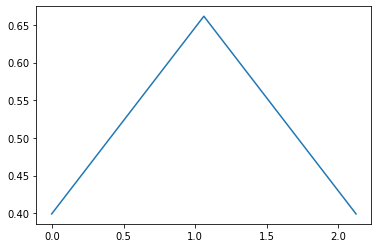

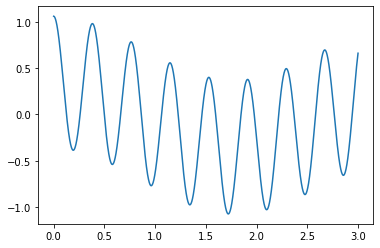

In [3]:
# Milestone 2 - using 2 elements only
v_case = cosserat_rod(2)
t_total = 3
dt = 3E-4
ext_force = np.zeros((3, v_case.n_nodes))
ext_couples = np.zeros((3, v_case.n_elements))
final_pos, position_history = v_case.run(ext_force, ext_couples, t_total, dt)
time_history = np.arange(0, t_total, dt)

plt.figure()
plt.plot(final_pos[2], final_pos[0])
plt.figure()
plt.plot(time_history, position_history[0, 1, :])

In [ ]:
# Milestone 2 - using 2 elements only
v_case = cosserat_rod(2)
t_total = 3
dt = 3E-4
ext_force = np.zeros((3, v_case.n_nodes))
ext_couples = np.zeros((3, v_case.n_elements))
final_pos, position_history = v_case.run(ext_force, ext_couples, t_total, dt)
time_history = np.arange(0, t_total, dt)

plt.figure()
plt.plot(final_pos[2], final_pos[0])
plt.figure()
plt.plot(time_history, position_history[0, 1, :])

In [ ]:
# Milestone 1
stretch_case = cosserat_rod()
t_total = 10
dt = 3E-4
ext_force = np.zeros((3, stretch_case.n_nodes))
ext_force[-1, -1] = 15
ext_couples = np.zeros((3, stretch_case.n_elements))
final_pos, position_history = stretch_case.run(ext_force, ext_couples, t_total, dt)

time_history = np.arange(0, t_total, dt)
plt.plot(time_history, position_history[-1,0,:])
plt.figure()
plt.plot(time_history, position_history[-1,-1,:])
print()
print('Average end displacement (m): ', end = '')
print(np.mean(position_history[-1,-1,:]-position_history[-1,-1, 0]))
print()

In [ ]:
stretch_case = cosserat_rod(1)
t_total = 100
dt = 3E-4
ext_force = np.zeros((3, stretch_case.n_nodes))
ext_force[-1, -1] = 15
ext_couples = np.zeros((3, stretch_case.n_elements))
final_pos, position_history = stretch_case.run(ext_force, t_total, dt)

time_history = np.arange(0, t_total, dt)
plt.plot(time_history, position_history[-1,0,:])
plt.figure()
plt.plot(time_history, position_history[-1,-1,:])
print()
print('Average end displacement (m): ', end = '')
print(np.mean(position_history[-1,-1,:]-position_history[-1,-1, 0]))
print()

In [5]:
print(position_history.shape)

(3, 3, 10000)


In [4]:
import pickle as pk
filename = "milestone2_2elems.dat"
file = open(filename, "wb")
pk.dump(position_history, file)
file.close()